#**Descrição do Conjunto de Dados:**
Nesta competição, você irá prever as vendas para milhares de famílias de produtos vendidos nas lojas Favorita localizadas no Equador. Os dados de treinamento incluem datas, informações das lojas e produtos, se o item estava em promoção, bem como os números de vendas. Arquivos adicionais incluem informações complementares que podem ser úteis na construção dos seus modelos.

##**Descrição dos Arquivos e Informações dos Campos de Dados:**
###**train.csv**
Os dados de treinamento, contendo séries temporais das características store_nbr, family e onpromotion, bem como o alvo de vendas.
store_nbr identifica a loja na qual os produtos são vendidos.
family identifica o tipo de produto vendido.
sales mostra o total de vendas para uma família de produtos em uma loja específica em uma determinada data. Valores fracionados são possíveis, pois os produtos podem ser vendidos em unidades fracionadas (por exemplo, 1,5 kg de queijo, em vez de 1 saco de batatas fritas).
onpromotion mostra o total de itens de uma família de produtos que estavam em promoção em uma loja em uma determinada data.
###**test.csv**
Os dados de teste, com as mesmas características dos dados de treinamento. Você irá prever as vendas alvo para as datas neste arquivo.
As datas nos dados de teste são para os 15 dias após a última data nos dados de treinamento.
###**sample_submission.csv**
Um arquivo de submissão de exemplo no formato correto.
###**stores.csv**
Metadados da loja, incluindo cidade, estado, tipo e cluster.
cluster é um agrupamento de lojas similares.
###**oil.csv**
Preço diário do petróleo. Inclui valores durante os períodos de tempo dos dados de treinamento e teste. (O Equador é um país dependente do petróleo e sua economia é altamente vulnerável a choques nos preços do petróleo.)
###**holidays_events.csv**
Feriados e eventos, com metadados.


**NOTA:** Preste atenção especial à coluna "transferred". Um feriado que é transferido oficialmente acontece no dia do calendário, mas foi movido para outra data pelo governo. Um dia transferido é mais como um dia normal do que um feriado. Para encontrar o dia em que ele foi realmente celebrado, procure a linha correspondente em que o tipo é "Transfer". Por exemplo, o feriado Independencia de Guayaquil foi transferido de 09-10-2012 para 12-10-2012, o que significa que foi celebrado em 12-10-2012. Dias que têm o tipo "Bridge" são dias extras adicionados a um feriado (por exemplo, para estender o período de folga em um final de semana prolongado). Esses dias são frequentemente compensados pelo tipo "Work Day", que é um dia normalmente não programado para trabalho (por exemplo, sábado) e que serve para compensar o dia de folga adicional.
Feriados adicionais são dias adicionados a um feriado do calendário regular, por exemplo, como costuma acontecer em torno do Natal (fazendo da véspera de Natal um feriado).

**Notas Adicionais:**
Os salários no setor público são pagos a cada duas semanas, no dia 15 e no último dia do mês. As vendas de supermercados podem ser afetadas por isso.
Um terremoto de magnitude 7,8 atingiu o Equador em 16 de abril de 2016. As pessoas se uniram para fornecer esforços de ajuda doando água e outros produtos essenciais, o que afetou significativamente as vendas de supermercados por várias semanas após o terremoto.

##Importando Bibliotecas

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarSeasonality
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm #contador de progressão de tempo
import statsmodels.api as sm #teste estacionaridade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings


# Ignorar todos os avisos
warnings.filterwarnings("ignore")

# Carregando os dados de vendas e preços do petróleo
sales_data = pd.read_csv('/content/train.csv')
oil_data = pd.read_csv('/content/oil.csv')
stores_data = pd.read_csv('/content/stores.csv')
holidays_data = pd.read_csv('/content/holidays_events.csv')
transactions_data = pd.read_csv('/content/transactions.csv')

In [110]:
#aumentando o limite de colunas a ser exbida
pd.set_option("display.max_columns", 400)
pd.set_option("display.max_rows", 400)

## Analise Exploratoria (EDA)

In [111]:
sales_data

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


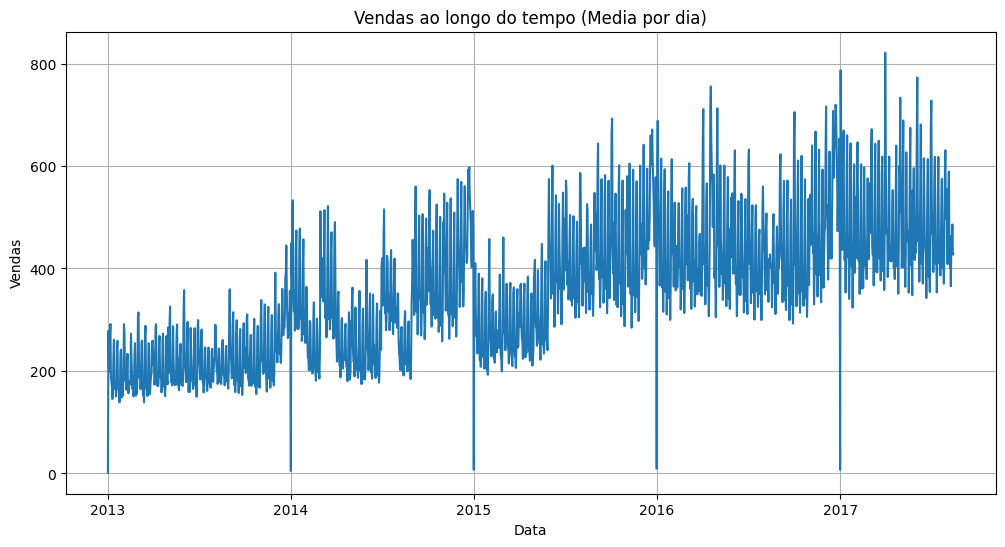

In [112]:
# Convertendo as colunas de data para o formato apropriado
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Agrupando as vendas por data e calculando a soma das vendas para cada dia
sales_by_date = sales_data.groupby('date')['sales'].mean()

# Plotando o gráfico de vendas ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Vendas ao longo do tempo (Media por dia)')
plt.grid(True)
plt.show()


Tem uma tendencia de crescimento no numero medio de vendas ao passar dos anos

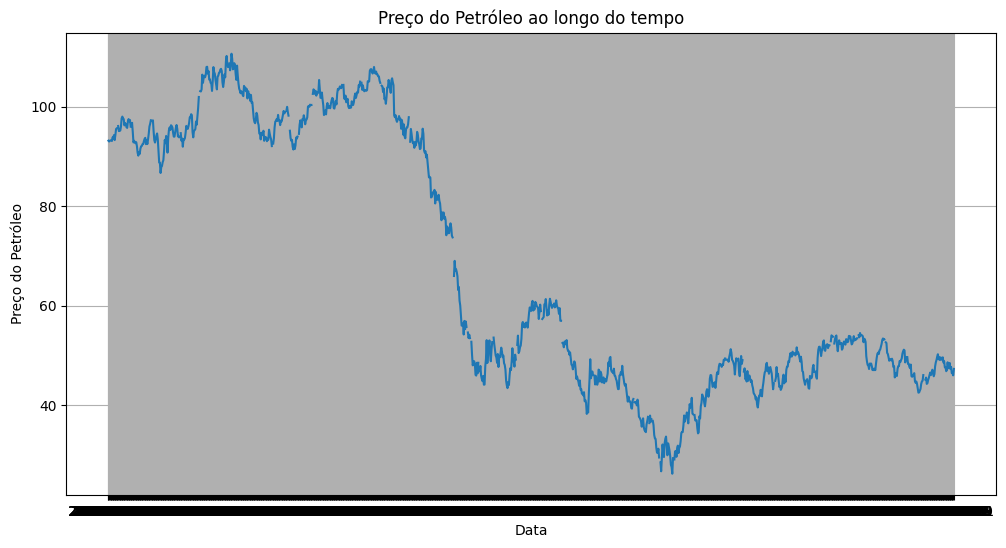

In [113]:
# Plotando o gráfico de preços do petróleo ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(oil_data['date'], oil_data['dcoilwtico'])
plt.xlabel('Data')
plt.ylabel('Preço do Petróleo')
plt.title('Preço do Petróleo ao longo do tempo')
plt.grid(True)
plt.show()

Queda no preço do petroleo que se inicia em julho de 2014 provavelmente pelo maior numero de produção que se iniciou no EUA e canada pela exploração do xisto.

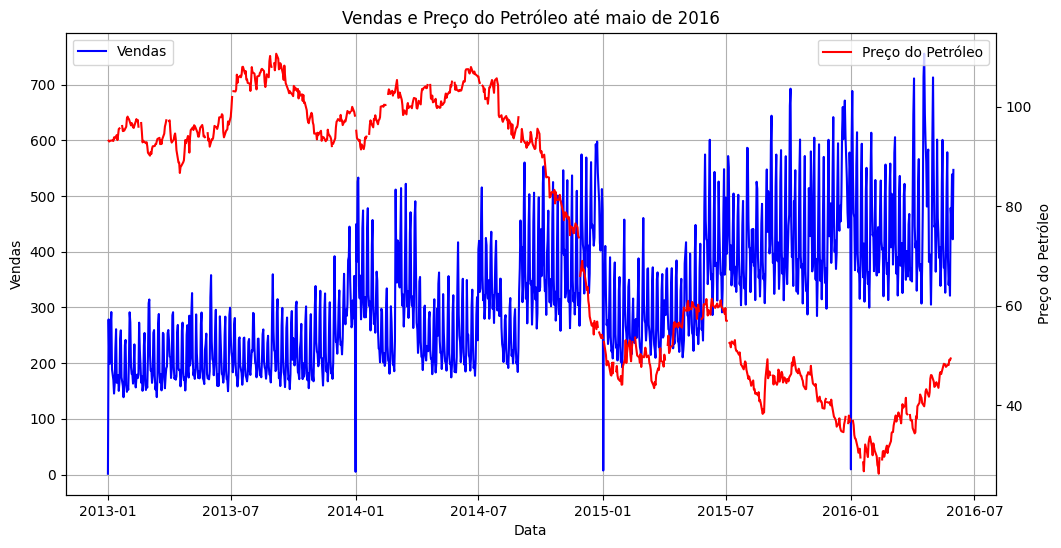

In [114]:
# Convertendo as colunas de data para o formato apropriado
sales_data['date'] = pd.to_datetime(sales_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Filtrando os dados até o mês 5 de 2016
sales_by_date_filtered = sales_by_date[sales_by_date.index <= pd.to_datetime('2016-05-31')]
oil_data_filtered = oil_data[oil_data['date'] <= pd.to_datetime('2016-05-31')]

# Plotando o gráfico com dois eixos y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de vendas ao longo do tempo
ax1.plot(sales_by_date_filtered.index, sales_by_date_filtered.values, label='Vendas', color='b')
ax1.set_xlabel('Data')
ax1.set_ylabel('Vendas')
ax1.set_title('Vendas e Preço do Petróleo até maio de 2016')
ax1.grid(True)

# Criando o segundo eixo y para o preço do petróleo
ax2 = ax1.twinx()
ax2.plot(oil_data_filtered['date'], oil_data_filtered['dcoilwtico'], label='Preço do Petróleo', color='r')
ax2.set_ylabel('Preço do Petróleo')

# Exibindo a legenda para ambos os gráficos
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Exibindo o gráfico combinado
plt.show()


estou vendo uma relação com uma defasagem de 2 meses entre o preço do oleo e o numero de vendas, porem preciso testar de alguma forma para ver se existe de fato isto.

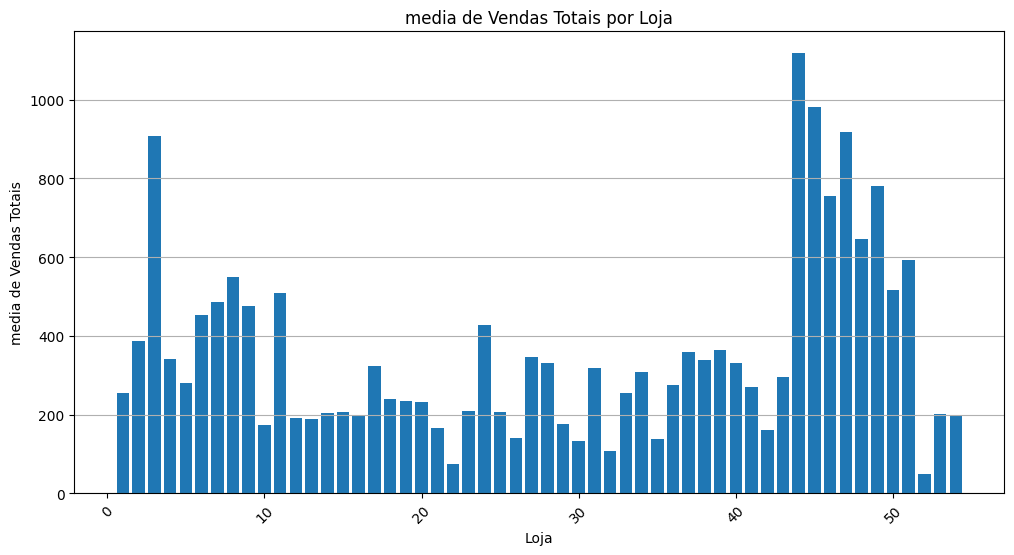

In [115]:
# Agrupando as vendas por loja e calculando a media das vendas totais para cada loja
sales_by_store = sales_data.groupby('store_nbr')['sales'].mean()

# Ordenando as lojas pela media das vendas em ordem decrescente
sales_by_store = sales_by_store.sort_values(ascending=False)

# Plotando o gráfico de vendas totais por loja
plt.figure(figsize=(12, 6))
plt.bar(sales_by_store.index, sales_by_store.values)
plt.xlabel('Loja')
plt.ylabel('media de Vendas Totais')
plt.title('media de Vendas Totais por Loja')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


aqui temos as lojas de numero 44-51 se destacando com um valor medio numero de vendas maior que as demais lojas, e também a loja de numero 3.

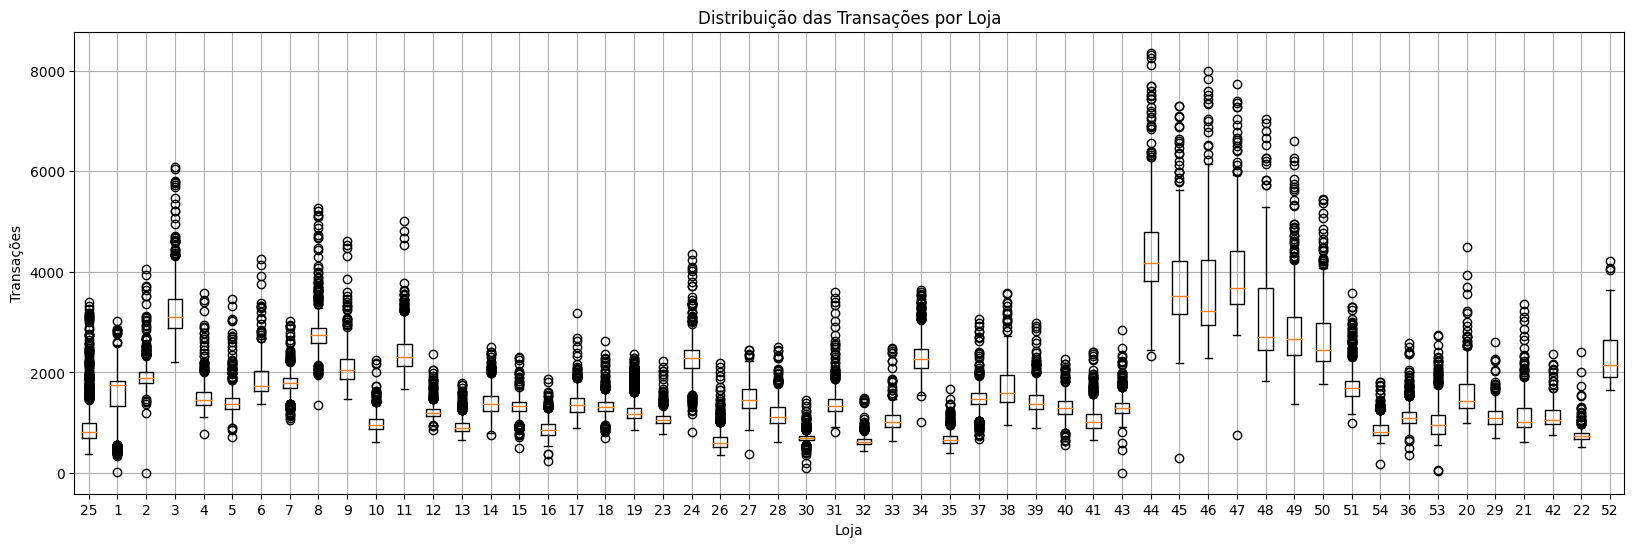

In [116]:

# Plotando o boxplot das transações por loja
plt.figure(figsize=(20, 6))
plt.boxplot([transactions_data[transactions_data['store_nbr'] == store]['transactions'] for store in transactions_data['store_nbr'].unique()],
            labels=transactions_data['store_nbr'].unique())
plt.xlabel('Loja')
plt.ylabel('Transações')
plt.title('Distribuição das Transações por Loja')
plt.grid(True)
plt.show()


olhando as transações, é posivel perceber que as lojas que mencionei anteriormente tem um maior numero de transações, e são poucas lojas que possuem uma mediana acima de 2 mil transações, talvez uma opção de filtro aqui.

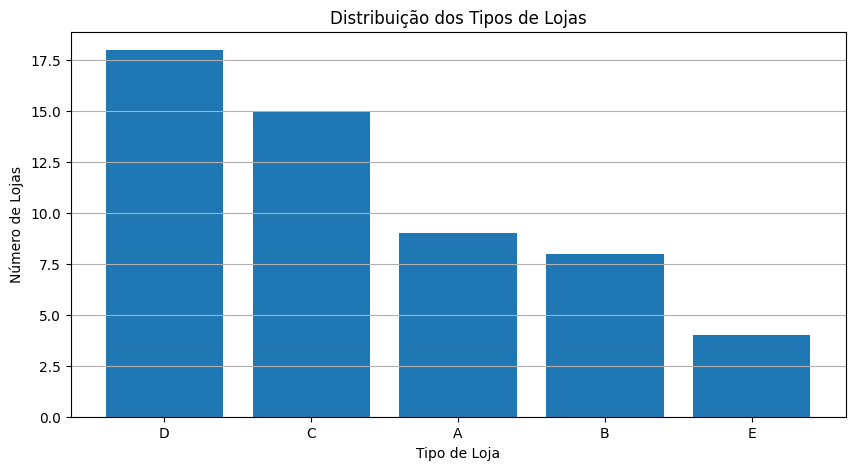

In [117]:
# Contando a ocorrência de cada tipo de loja
store_types_count = stores_data['type'].value_counts()

# Plotando o gráfico de barras para tipos de lojas
plt.figure(figsize=(10, 5))
plt.bar(store_types_count.index, store_types_count.values)
plt.xlabel('Tipo de Loja')
plt.ylabel('Número de Lojas')
plt.title('Distribuição dos Tipos de Lojas')
plt.grid(axis='y')
plt.show()

As lojas são classificadas por 5 tipos reconhecidos por uma letra, é possivel ver que existem mais lojas do tipo D e C, e poucas lojas do tipo E

In [118]:
# Unindo as informações das lojas com os dados de vendas
sales_data = sales_data.merge(stores_data, on='store_nbr')

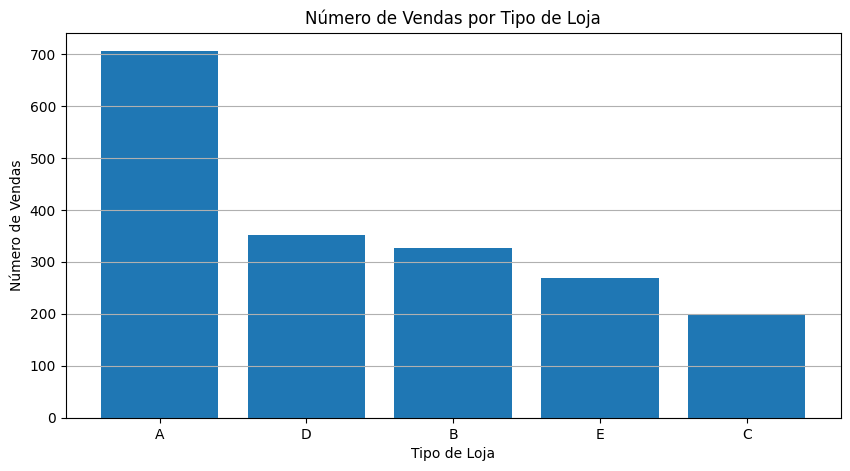

In [119]:
# Agrupando as vendas por tipo de loja e calculando o número total de vendas para cada tipo
sales_by_store_type = sales_data.groupby('type')['sales'].mean()

# Ordenando os tipos de loja pela quantidade de vendas em ordem decrescente
sales_by_store_type = sales_by_store_type.sort_values(ascending=False)

# Plotando o gráfico de barras para o número de vendas por tipo de loja
plt.figure(figsize=(10, 5))
plt.bar(sales_by_store_type.index, sales_by_store_type.values)
plt.xlabel('Tipo de Loja')
plt.ylabel('Número de Vendas')
plt.title('Número de Vendas por Tipo de Loja')
plt.grid(axis='y')
plt.show()


Lojas do tipo A é as que possuem o maior numero de vendas medio, e apesar de lojas do tipo C estarem em grande quantidade, elas são as que efetuam um menor numero de vendas.

In [120]:
# Calculando a mediana de transações por loja
median_transactions_by_store = transactions_data.groupby('store_nbr')['transactions'].median()

# Encontrando as lojas que possuem a mediana de transações acima de 2000
stores_above_median = median_transactions_by_store[median_transactions_by_store > 2000].index

# Filtrando os dados das lojas acima da mediana
filtered_sales = sales_data[sales_data['store_nbr'].isin(stores_above_median)]

# Obtendo informações sobre os tipos, cidades e clusters das lojas acima da mediana
store_info = filtered_sales.groupby('store_nbr').agg({
    'type': 'first',
    'city': 'first',
    'cluster': 'first'
}).reset_index()

store_info


,store_nbr,type,city,cluster
0,3,D,Quito,8
1,8,D,Quito,8
2,9,B,Quito,6
3,11,B,Cayambe,6
4,24,D,Guayaquil,1
5,34,B,Guayaquil,6
6,44,A,Quito,5
7,45,A,Quito,11
8,46,A,Quito,14
9,47,A,Quito,14


Pegando as lojas que tem uma mediana de transações acima de 2 mil, é possivel ver que a maioria dessas lojas estão em Quito capital do equador, e principal cidade de turismo no equador.

In [121]:
!pip install squarify

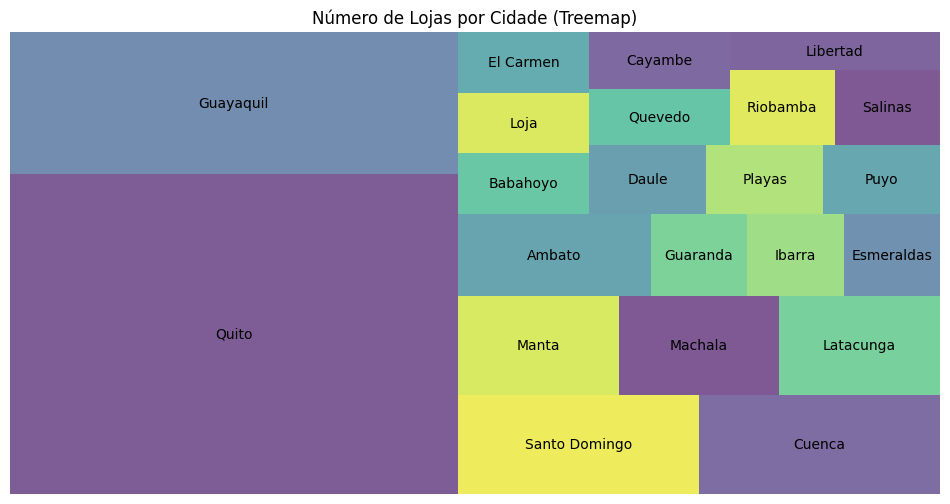

In [122]:
import squarify


#Obtendo o número de lojas por cidade
stores_by_city = sales_data.groupby('city')['store_nbr'].nunique().reset_index()

#Ordenando as cidades pelo número de lojas em ordem decrescente
stores_by_city = stores_by_city.sort_values(by='store_nbr', ascending=False)

#Criando a figura e o eixo para o treemap
fig, ax = plt.subplots(figsize=(12, 6))

#Plotando o treemap
squarify.plot(sizes=stores_by_city['store_nbr'], label=stores_by_city['city'], alpha=0.7, ax=ax)
ax.axis('off')  #Removendo os eixos
plt.title('Número de Lojas por Cidade (Treemap)')
plt.show()

é possivel perceber que o maior numero de lojas esta realmente em Quito, seguido de Guayaquil, esta ultima cendo a cidade mais populosa do pais.

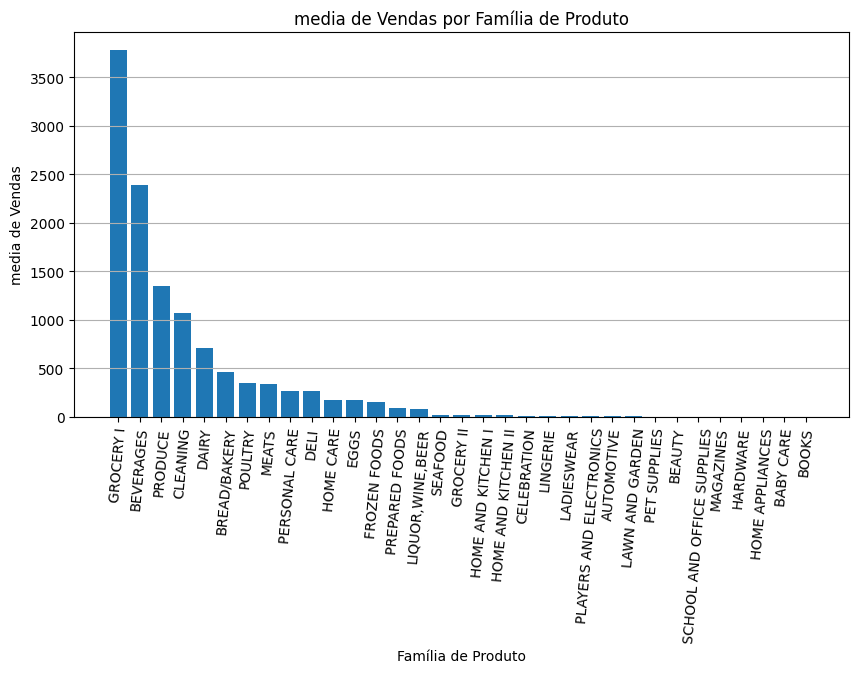

In [123]:
# Agrupando as vendas por tipo de produto e calculando a media de vendas para cada tipo
sales_by_product_type = sales_data.groupby('family')['sales'].mean()

# Ordenando as famílias de produto pela media de vendas em ordem decrescente
sales_by_product_type = sales_by_product_type.sort_values(ascending=False)

# Plotando o gráfico de barras para a media de vendas por tipo de produto
plt.figure(figsize=(10, 5))
plt.bar(sales_by_product_type.index, sales_by_product_type.values)
plt.xlabel('Família de Produto')
plt.ylabel('media de Vendas')
plt.title('media de Vendas por Família de Produto')
plt.xticks(rotation=85)
plt.grid(axis='y')
plt.show()


Por mais que exista muitas categorias de produtos, as vendas estão concentradas em apenas algumas, talves seja possivel filtrar somente as categorias que possuem um maior numero de vendas.

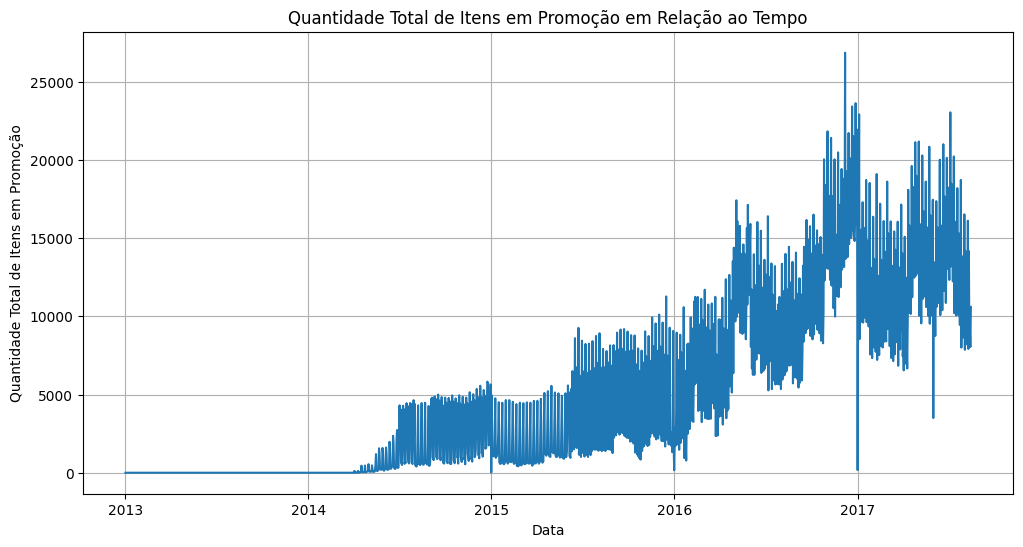

In [124]:
# Convertendo a coluna de data para o formato apropriado
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Agrupando os dados pela data e calculando a quantidade total de itens em promoção para cada data
promotions_by_date = sales_data.groupby('date')['onpromotion'].sum()

# Plotando o gráfico de quantidade total de itens em promoção em relação ao tempo
plt.figure(figsize=(12, 6))
plt.plot(promotions_by_date.index, promotions_by_date.values)
plt.xlabel('Data')
plt.ylabel('Quantidade Total de Itens em Promoção')
plt.title('Quantidade Total de Itens em Promoção em Relação ao Tempo')
plt.grid(True)
plt.show()


Curiosamente as promoções so se iniciam em 2014 proximo a data do inicio da queda do preço do petroleo, também existe uma possivel correlação quanto maior o numero de promoção, maior o numero de vendas.

In [125]:
# Unindo as informações das lojas com os dados de petroleo
sales_data = sales_data.merge(oil_data, on='date')

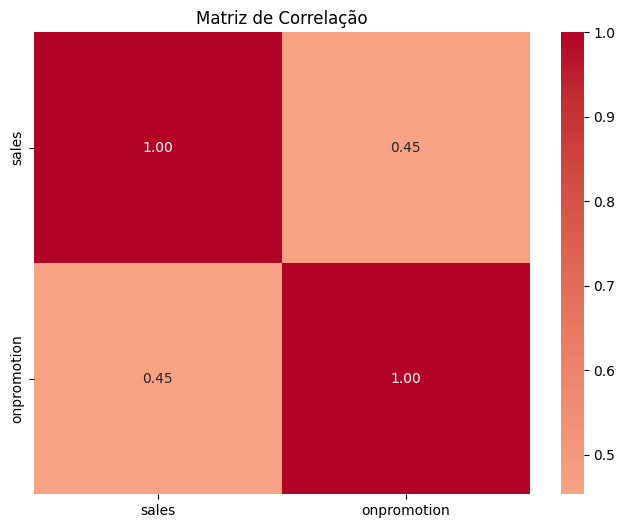

In [126]:
# Calculando a matriz de correlação entre as variáveis de interesse
correlation_matrix = sales_data[['sales', 'onpromotion']].corr()

# Plotando o mapa de calor da matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


Como imaginei existe esta correlação porem não muito expressiva.

##Pre Processamento

In [127]:
# Verificando valores nulos em sales_data
print("Valores nulos em sales_data:")
print(sales_data.isnull().sum())

# Verificando valores nulos em oil_data
print("\nValores nulos em oil_data:")
print(oil_data.isnull().sum())

# Verificando valores nulos em stores_data
print("\nValores nulos em stores_data:")
print(stores_data.isnull().sum())

# Verificando valores nulos em holidays_data
print("\nValores nulos em holidays_data:")
print(holidays_data.isnull().sum())

# Verificando valores nulos em transactions_data
print("\nValores nulos em transactions_data:")
print(transactions_data.isnull().sum())

Valores nulos em sales_data:
id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
dcoilwtico     71280
dtype: int64

Valores nulos em oil_data:
date           0
dcoilwtico    43
dtype: int64

Valores nulos em stores_data:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Valores nulos em holidays_data:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Valores nulos em transactions_data:
date            0
store_nbr       0
transactions    0
dtype: int64


Apenas o Oil_data possui dados nulos, apesar de serem poucos dados quando levamos para uma escala de todas as opções possiveis ficamos com mais de 70 mil dados nulos como é possivel ver em sales_data que ja possuia o merge com oil_data, irei tentar um tratamento simples e se for o caso volto e removo esses valores.

In [128]:
# Filtrando as linhas com valores nulos na coluna "dcoilwtico"
null_values = oil_data[oil_data['dcoilwtico'].isnull()]

# Exibindo as datas dos valores nulos
print("Datas dos valores nulos em oil_data:")
print(null_values['date'])


Datas dos valores nulos em oil_data:
0      2013-01-01
14     2013-01-21
34     2013-02-18
63     2013-03-29
104    2013-05-27
132    2013-07-04
174    2013-09-02
237    2013-11-28
256    2013-12-25
261    2014-01-01
274    2014-01-20
294    2014-02-17
338    2014-04-18
364    2014-05-26
393    2014-07-04
434    2014-09-01
497    2014-11-27
517    2014-12-25
522    2015-01-01
534    2015-01-19
554    2015-02-16
588    2015-04-03
624    2015-05-25
653    2015-07-03
699    2015-09-07
757    2015-11-26
778    2015-12-25
783    2016-01-01
794    2016-01-18
814    2016-02-15
843    2016-03-25
889    2016-05-30
914    2016-07-04
959    2016-09-05
1017   2016-11-24
1039   2016-12-26
1044   2017-01-02
1054   2017-01-16
1079   2017-02-20
1118   2017-04-14
1149   2017-05-29
1174   2017-07-03
1175   2017-07-04
Name: date, dtype: datetime64[ns]


aparentemente os dados nulos são aleatorios, sem seguir um padrão ou uma sequencia de dias.

In [129]:
# Convertendo a coluna de data para o formato apropriado
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Ordenando o dataframe pela coluna de data
oil_data = oil_data.sort_values(by='date')

# Preenchendo os valores nulos com a média entre o valor anterior e o valor posterior
for i in range(1, len(oil_data)-1):
    if pd.isnull(oil_data.at[i, 'dcoilwtico']):
        previous_value = oil_data.at[i-1, 'dcoilwtico']
        next_value = oil_data.at[i+1, 'dcoilwtico']
        oil_data.at[i, 'dcoilwtico'] = (previous_value + next_value) / 2



oil_data.dropna(subset=['dcoilwtico'], inplace=True) #dropando o primeiro e o ultimo valor que ficam nulos
# Exibindo os valores nulos após o preenchimento
print(oil_data[oil_data['dcoilwtico'].isnull()])

Empty DataFrame
Columns: [date, dcoilwtico]
Index: []


para preencher esses dados nulos eu optei por usar a media entre o valor anterior e o proximo valor, caso sejam valores iguais ele manteria o mesmo valor e se fossem valores diferentes ele seria a media entre esses dois valores sem distorcer ou causar ruidos no grafico

In [130]:
# Verificando o número total de linhas do DataFrame
total_linhas = len(oil_data)
# Excluindo as últimas 12 linhas
oil_data = oil_data.drop(oil_data.index[total_linhas - 12:total_linhas])

o conjunto de oil_data possui dias que estão presente somente no conjunto de teste, então estou removendo esses dias deixando apenas os dias presentes no conjunto de treino.

In [131]:
sales_data = pd.read_csv('/content/train.csv')

# Convertendo a coluna "date" para o tipo datetime64[ns]
sales_data['date'] = pd.to_datetime(sales_data['date'])
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Criando um DataFrame com todas as datas únicas presentes em sales_data, transaction_data e oil_data
all_dates = pd.concat([sales_data['date'], oil_data['date']]).drop_duplicates().reset_index(drop=True)

# Mesclando os DataFrames sales_data e transactions_data usando todas as datas únicas
df_train = pd.merge(all_dates, sales_data, on=["date"], how="left")
#df_train = pd.merge(df_train, transactions_data, on=["date", "store_nbr"], how="left")

# Combinando os demais DataFrames, preenchendo os valores ausentes em oil_data usando forward fill (ffill)
df_train = df_train.merge(oil_data, on="date", how="left").ffill()
df_train = df_train.merge(stores_data, on="store_nbr", how="left") \
                    .sort_values(["date", "store_nbr", "family"], ignore_index=True)

# Adicionando a coluna "type" como chave de junção no merge com holidays_data
#df_train = df_train.merge(holidays_data, on=["date"], how="left") \
 #                  .sort_values(["date", "store_nbr", "family"], ignore_index=True)


aqui estou fazendo o merge entre os conjuntos disponiveis para df_train, note que como possuo diversas ocorrencias no mesmo dia em sales, precisei usar o .ffill() pois o preço do oleo so estava sendo preenchido para uma ocorrencia por dia.

In [132]:
# Verificando valores duplicados na coluna "id" após o merge
duplicatas = df_train['id'].duplicated()
print(duplicatas.value_counts())


False    3000888
True           3
Name: id, dtype: int64


irei remover esses dados duplicados durante a modelagem

In [107]:
# Setando o Index
df_train.set_index('date',inplace = True)

#df_train.rename(columns={'type_x': 'Tipos_loja'}, inplace=True)


In [133]:
df_train

,date,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,2013-01-01,0.0,1.0,AUTOMOTIVE,0.000,0.0,NaN,Quito,Pichincha,D,13
1,2013-01-01,1.0,1.0,BABY CARE,0.000,0.0,NaN,Quito,Pichincha,D,13
2,2013-01-01,2.0,1.0,BEAUTY,0.000,0.0,NaN,Quito,Pichincha,D,13
3,2013-01-01,3.0,1.0,BEVERAGES,0.000,0.0,NaN,Quito,Pichincha,D,13
4,2013-01-01,4.0,1.0,BOOKS,0.000,0.0,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...
3000886,2017-08-15,3000751.0,54.0,POULTRY,59.619,0.0,47.57,El Carmen,Manabi,C,3
3000887,2017-08-15,3000752.0,54.0,PREPARED FOODS,94.000,0.0,47.57,El Carmen,Manabi,C,3
3000888,2017-08-15,3000753.0,54.0,PRODUCE,915.371,76.0,47.57,El Carmen,Manabi,C,3
3000889,2017-08-15,3000754.0,54.0,SCHOOL AND OFFICE SUPPLIES,0.000,0.0,47.57,El Carmen,Manabi,C,3


##Feature Engineering

In [71]:
'''# Criar a feature "feriado"
df_train['feriado'] = df_train['description'].apply(lambda x: 1 if pd.notna(x) else 0)

# Criar a feature "tipo_feriado"
def map_locale_to_tipo_feriado(locale):
    if pd.isna(locale):
        return 0
    elif locale == 'National':
        return 1
    elif locale == 'Local':
        return 2
    elif locale == 'Regional':
        return 3
    else:
        return -1  # Valor inválido ou não mapeado

df_train['tipo_feriado'] = df_train['locale'].apply(map_locale_to_tipo_feriado)'''


'# Criar a feature "feriado"\ndf_train[\'feriado\'] = df_train[\'description\'].apply(lambda x: 1 if pd.notna(x) else 0)\n\n# Criar a feature "tipo_feriado"\ndef map_locale_to_tipo_feriado(locale):\n    if pd.isna(locale):\n        return 0\n    elif locale == \'National\':\n        return 1\n    elif locale == \'Local\':\n        return 2\n    elif locale == \'Regional\':\n        return 3\n    else:\n        return -1  # Valor inválido ou não mapeado\n\ndf_train[\'tipo_feriado\'] = df_train[\'locale\'].apply(map_locale_to_tipo_feriado)'

In [134]:
#Realizando o rolling mean para cada família e loja individualmente
df_train['venda_media_7dias'] = df_train.groupby(['family', 'store_nbr'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())

#Realizando o rolling max para cada família e loja individualmente
df_train['valor_maximo_7dias'] = df_train.groupby(['family', 'store_nbr'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).max())

#Realizando o rolling min para cada família e loja individualmente
df_train['valor_minimo_7dias'] = df_train.groupby(['family', 'store_nbr'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).min())

#Realizando o rolling mean para o preço do óleo
df_train['preco_oleo_media_7dias'] = df_train['dcoilwtico'].rolling(7, min_periods=1).mean()

#Realizando o rolling max para o preço do óleo
df_train['preco_oleo_maximo_7dias'] = df_train['dcoilwtico'].rolling(7, min_periods=1).max()

#Realizando o rolling min para o preço do óleo
df_train['preco_oleo_minimo_7dias'] = df_train['dcoilwtico'].rolling(7, min_periods=1).min()


usando o rolling para criar algumas features baseados em alguns periodos e metricas, o uso de transform para usar uma função foi necessario devido ao filtro feito pelo groupby.

In [135]:
#Realizando o shift para cada família e loja individualmente
df_train['vendas_dia_anterior'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(1)
df_train['vendas_7dias_anteriores'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(7)
df_train['vendas_14dias_anteriores'] = df_train.groupby(['family', 'store_nbr'])['sales'].shift(14)

#Realizando o shift para o preço do óleo
df_train['preco_oleo_dia_anterior'] = df_train['dcoilwtico'].shift(1)
df_train['preco_oleo_7dias_anteriores'] = df_train['dcoilwtico'].shift(7)
df_train['preco_oleo_14dias_anteriores'] = df_train['dcoilwtico'].shift(14)


usando shift para pegar criar algumas features pegando determinados periodos no passado

In [136]:
df_train = df_train.reset_index()  # Reseta o índice para que "date" torne-se uma coluna novamente

#Extraindo o mês
df_train['mês'] = df_train.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.month)

#Extraindo o dia da semana (0 = segunda-feira, 1 = terça-feira, ..., 6 = domingo)
df_train['dia_semana'] = df_train.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.dayofweek)

#Extraindo o dia do mês
df_train['dia_mes'] = df_train.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.day)

#Extraindo o ano
df_train['ano'] = df_train.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.year)

#Definindo novamente a coluna "date" como o índice
df_train = df_train.set_index('date')


criando features do mês, dia da semana, dia do mes, e ano.

## Pre_processamento para modelagem.

In [137]:
# Verificar os valores nulos no DataFrame df_train
df_train_nulos = df_train.isnull()

# Somando os valores nulos por coluna
total_nulos_por_coluna = df_train_nulos.sum()

# Criando um DataFrame com o total de nulos por coluna
df_total_nulos = pd.DataFrame(total_nulos_por_coluna, columns=['Total Nulos'])

# Criando uma coluna adicional para indicar a porcentagem de nulos em relação ao total de linhas
df_total_nulos['Porcentagem de Nulos'] = (total_nulos_por_coluna / len(df_train)) * 100

# Ordenando o DataFrame pelo total de nulos em ordem decrescente
df_total_nulos = df_total_nulos.sort_values(by='Total Nulos', ascending=False)

# Realçando visualmente os valores nulos no DataFrame
df_total_nulos_estilizado = df_total_nulos.style.highlight_null(null_color='red')

# Visualizando o DataFrame com os valores nulos destacados
df_total_nulos_estilizado


,Total Nulos,Porcentagem de Nulos
vendas_14dias_anteriores,24948,0.831353
vendas_7dias_anteriores,12474,0.415677
preco_oleo_14dias_anteriores,1796,0.059849
preco_oleo_7dias_anteriores,1789,0.059616
preco_oleo_dia_anterior,1783,0.059416
preco_oleo_media_7dias,1782,0.059382
dcoilwtico,1782,0.059382
vendas_dia_anterior,1782,0.059382
preco_oleo_minimo_7dias,1782,0.059382
preco_oleo_maximo_7dias,1782,0.059382


In [76]:
'''# Dropar as colunas
df_train = df_train.drop(["transferred", "description", "locale_name", "locale"],axis =1)
'''

'# Dropar as colunas\ndf_train = df_train.drop(["transferred", "description", "locale_name", "locale"],axis =1)\n'

Removendo as colunas com dados nulos de holiday_data e que não pretendo usar.

In [138]:
#removendo linhas com nulos
df_train = df_train.dropna()

ao criar features com rolling e shift geramos alguns valores nulos no começo do dataframe(o que ja era esperado),irei remover essas linhas.

In [140]:
df_train

,index,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,venda_media_7dias,valor_maximo_7dias,valor_minimo_7dias,preco_oleo_media_7dias,preco_oleo_maximo_7dias,preco_oleo_minimo_7dias,vendas_dia_anterior,vendas_7dias_anteriores,vendas_14dias_anteriores,preco_oleo_dia_anterior,preco_oleo_7dias_anteriores,preco_oleo_14dias_anteriores,mês,dia_semana,dia_mes,ano
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,24948,24948.0,1.0,AUTOMOTIVE,1.000,0.0,93.26,Quito,Pichincha,D,13,2.000000,3.000,1.000,94.125714,94.27,93.26,2.000,2.000,0.000,94.27,94.27,94.27,1,1,15,2013
2013-01-15,24949,24949.0,1.0,BABY CARE,0.000,0.0,93.26,Quito,Pichincha,D,13,0.000000,0.000,0.000,93.981429,94.27,93.26,0.000,0.000,0.000,93.26,94.27,94.27,1,1,15,2013
2013-01-15,24950,24950.0,1.0,BEAUTY,0.000,0.0,93.26,Quito,Pichincha,D,13,1.142857,3.000,0.000,93.837143,94.27,93.26,2.000,3.000,0.000,93.26,94.27,94.27,1,1,15,2013
2013-01-15,24951,24951.0,1.0,BEVERAGES,1149.000,0.0,93.26,Quito,Pichincha,D,13,1015.428571,1186.000,572.000,93.692857,94.27,93.26,1178.000,1029.000,0.000,93.26,94.27,94.27,1,1,15,2013
2013-01-15,24952,24952.0,1.0,BOOKS,0.000,0.0,93.26,Quito,Pichincha,D,13,0.000000,0.000,0.000,93.548571,94.27,93.26,0.000,0.000,0.000,93.26,94.27,94.27,1,1,15,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000886,3000751.0,54.0,POULTRY,59.619,0.0,47.57,El Carmen,Manabi,C,3,66.849714,91.671,49.666,47.570000,47.57,47.57,56.155,73.289,72.303,47.57,47.57,47.57,8,1,15,2017
2017-08-15,3000887,3000752.0,54.0,PREPARED FOODS,94.000,0.0,47.57,El Carmen,Manabi,C,3,88.428571,147.000,54.000,47.570000,47.57,47.57,147.000,86.000,114.000,47.57,47.57,47.57,8,1,15,2017
2017-08-15,3000888,3000753.0,54.0,PRODUCE,915.371,76.0,47.57,El Carmen,Manabi,C,3,673.538143,915.371,498.122,47.570000,47.57,47.57,585.615,790.013,1045.444,47.57,47.57,47.57,8,1,15,2017


Note que o conjunto original se inicia em 1 de janeiro de 2013 porem como criei features baseadas em 14 dias atras, consequentemente gerei dados nulos para os primeiros dias, apos dropar estes nulos nosso dataframe começou no dia 15-01.

### Removendo o residuo e tornando a serie estacionaria.

In [141]:
df_train_resid = df_train.copy()

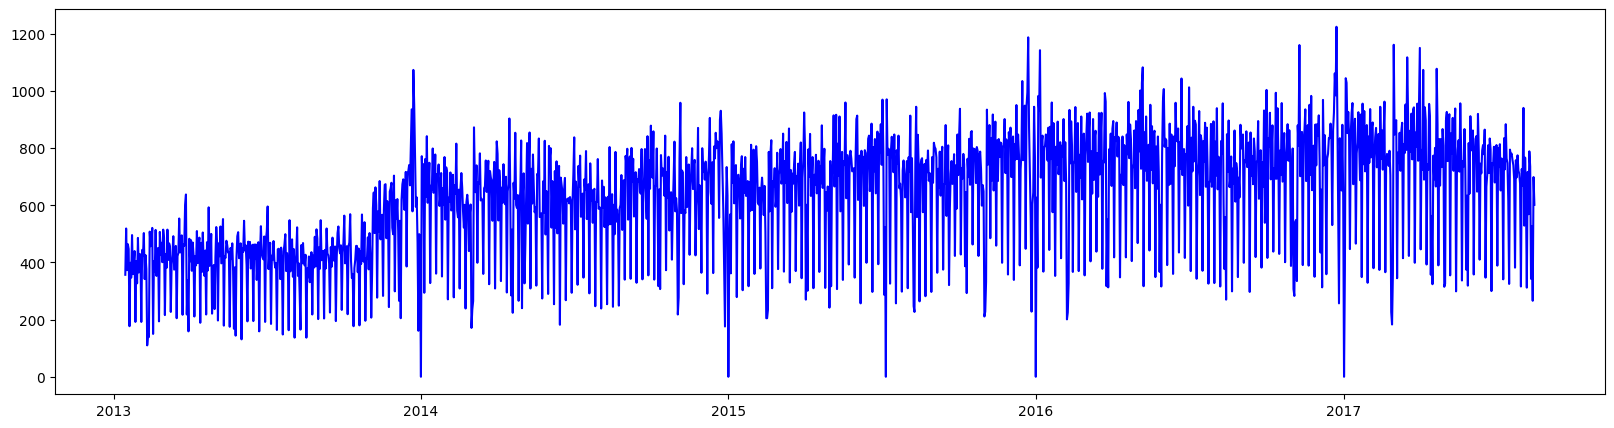

In [142]:
# Filtrando os dados de treino para store_nbr = 1 e family = 'DAIRY'
df_train_resid_subset = df_train_resid[(df_train_resid['store_nbr'] == 1) & (df_train_resid['family'] == 'DAIRY')]

# Plotando treino e teste
plt.figure(figsize=(20, 5))
plt.plot(df_train_resid_subset['sales'], color='b', label='DAIRY')


Possuimos mais de 1700 combinações de Series temporais (Lojas x Family), e olhar cada uma delas seria inviavel, escolhi uma dessas combinações para fazer a analise

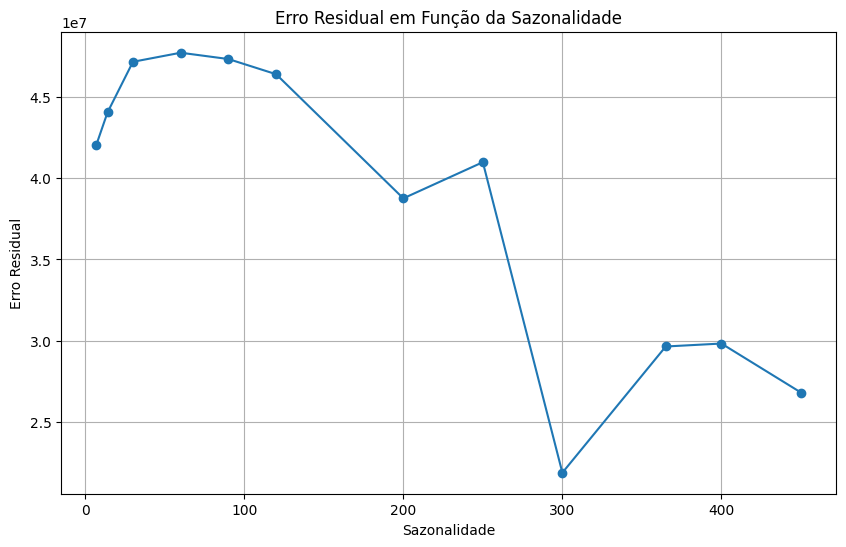

In [143]:
def grid_search_seasonality(data, seasonality_values):
    residual_errors = []

    for seasonality in seasonality_values:
        # Realizando a decomposição com o valor de sazonalidade atual
        decomposition = seasonal_decompose(data, period=seasonality)

        # Calculando o erro residual
        residual_error = np.sum((data - decomposition.seasonal - decomposition.trend).dropna() ** 2)
        residual_errors.append(residual_error)

    return residual_errors


seasonality_values = [7, 14, 30, 60, 90, 120, 200, 250, 300, 365,400,450]  # Valores de sazonalidade a serem testados
residual_errors = grid_search_seasonality(df_train_resid_subset['sales'], seasonality_values)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(seasonality_values, residual_errors, marker='o')
plt.xlabel('Sazonalidade')
plt.ylabel('Erro Residual')
plt.title('Erro Residual em Função da Sazonalidade')
plt.grid(True)
plt.show()


Com este gridSearch foi possivel localizar qual sazonalidade diminui mais o nosso erro residual sendo 300 dias.

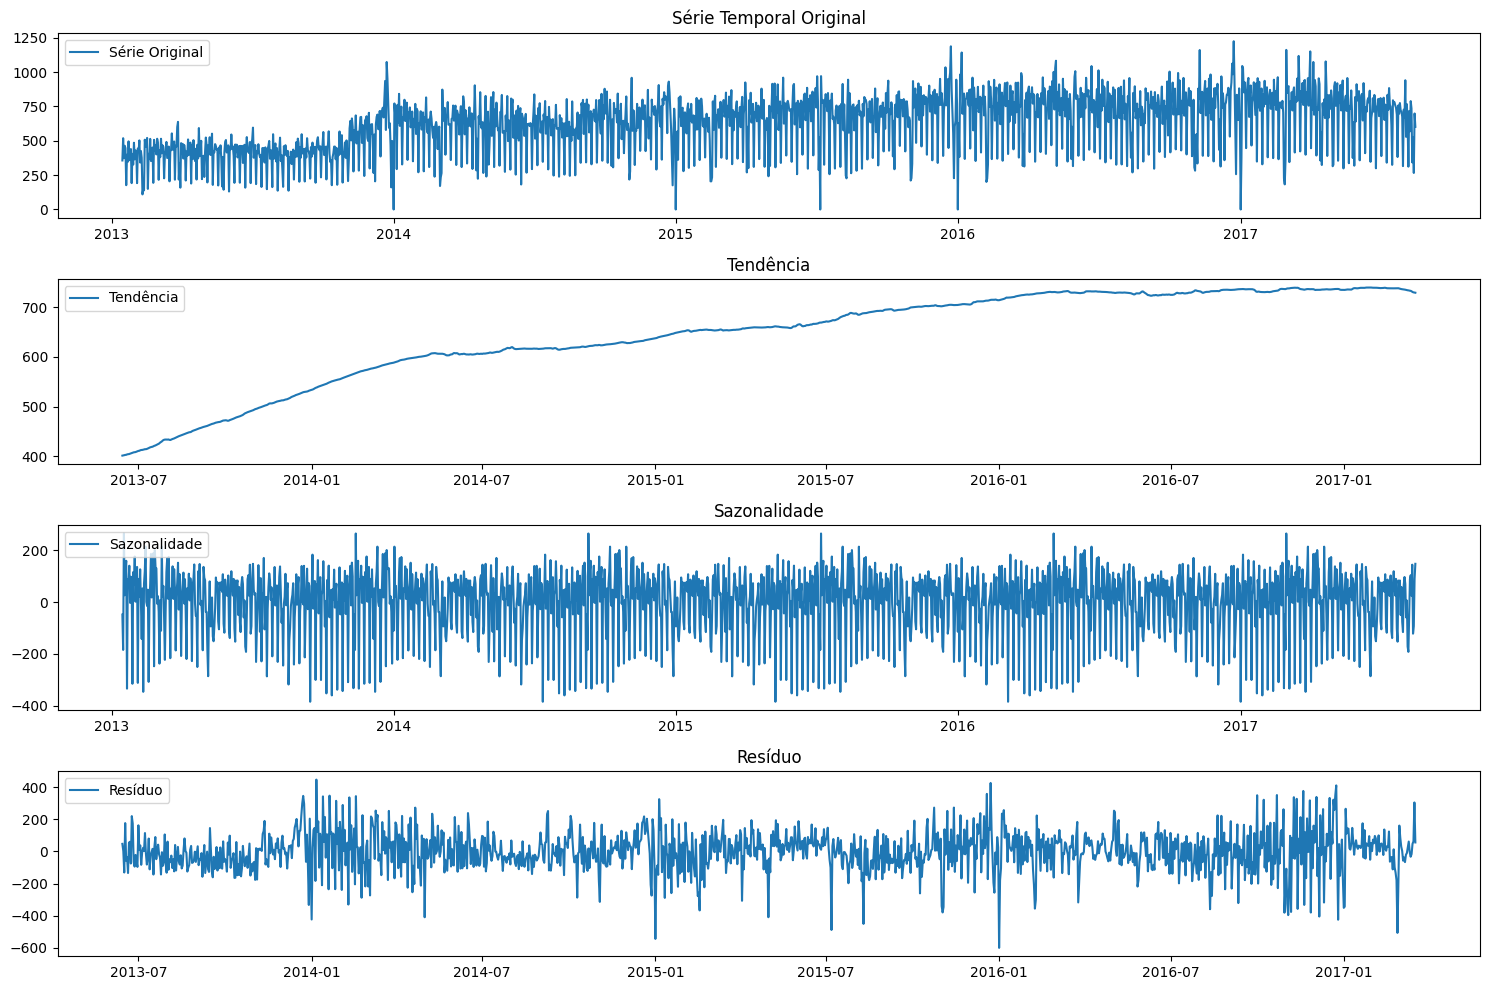

In [144]:
# Definindo o período da decomposição (7 dias)
periodo_decomposicao = 300

# Aplicando a decomposição para a série de treinamento
decomposicao_treino = seasonal_decompose(df_train_resid_subset['sales'], period=periodo_decomposicao)

# Plotando a decomposição
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(df_train_resid_subset['sales'], label='Série Original')
plt.legend(loc='upper left')
plt.title('Série Temporal Original')

plt.subplot(4, 1, 2)
plt.plot(decomposicao_treino.trend, label='Tendência')
plt.legend(loc='upper left')
plt.title('Tendência')

plt.subplot(4, 1, 3)
plt.plot(decomposicao_treino.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.title('Sazonalidade')

plt.subplot(4, 1, 4)
plt.plot(decomposicao_treino.resid, label='Resíduo')
plt.legend(loc='upper left')
plt.title('Resíduo')

plt.tight_layout()
plt.show()


Apesar de o residuo ainda apresentar alguns pontos de sazonalidade, 300 dias ainda é a melhor opção para reduzir o ruido.

<Figure size 1200x600 with 0 Axes>

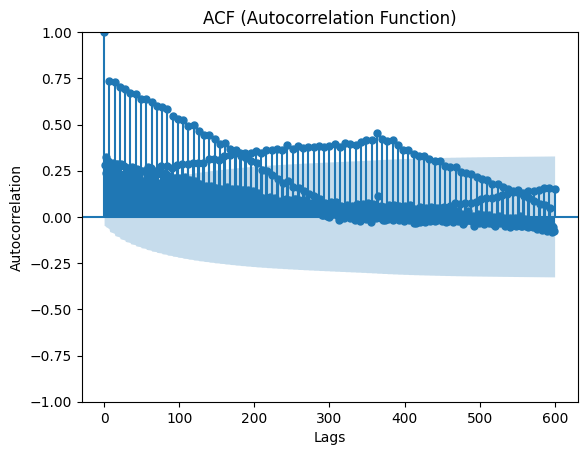

In [145]:
# Plotando ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(df_train_resid_subset['sales'], lags=600, alpha=0.05)
plt.title('ACF (Autocorrelation Function)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

quando olhamos para o ACF é possivel perceber que até 400 dias atras ainda possui uma correlação em sales, talvez usar um conjunto de dados de apenas 400 dias atras para prever sales seja uma boa opção

In [147]:
# Definindo a periodicidade sazonal
seasonality_period = 300

# Função para remover o resíduo e tornar a série estacionária
def remove_residuo(group):
    group = group.sort_values(by='date')  # Garantir que os dados estejam ordenados pela data
    group['residual'] = group['sales'] - group['sales'].rolling(seasonality_period, min_periods=1).mean()
    return group

# Aplicando a função de remoção do resíduo para cada combinação única de "store_nbr" e "family"
df_train_resid = df_train_resid.groupby(['store_nbr', 'family']).apply(remove_residuo)



Sabendo que 300 dias é a melhor opção para remover a tendencia e sazonalidade do conjunto, estou aplicando uma função que cria uma nova feature chamada residual, que armazena o valor de sales, sem a sazonalidade e tendencia ou seja o valor residual.

In [148]:
# Função para executar o teste de ADF e retornar o resultado
def adf_test(series):
    result = sm.tsa.adfuller(series, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f"ADF Statistic: {adf_statistic}")
    print(f"P-Value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value}")

    if p_value <= 0.05:
        print("A série é estacionária (rejeitamos a hipótese nula).")
    else:
        print("A série não é estacionária (não rejeitamos a hipótese nula).")

# Filtrando os dados de treino para store_nbr = 1 e family = 'DAIRY'
df_train_resid_subset = df_train_resid[(df_train_resid['store_nbr'] == 1) & (df_train_resid['family'] == 'DAIRY')]

# Executando o teste de ADF na série original
print("Teste de ADF para a série original:")
adf_test(df_train_resid_subset['sales'])

# Executando o teste de ADF na série residual
print("\nTeste de ADF para a série residual:")
adf_test(df_train_resid_subset['residual'])


Teste de ADF para a série original:
ADF Statistic: -2.5744035409580017
P-Value: 0.09840376957374664
Critical Values:
   1%: -3.4343218063763605
   5%: -2.863294325252669
   10%: -2.567703962071947
A série não é estacionária (não rejeitamos a hipótese nula).

Teste de ADF para a série residual:
ADF Statistic: -4.369281997741335
P-Value: 0.0003362766788564833
Critical Values:
   1%: -3.4343218063763605
   5%: -2.863294325252669
   10%: -2.567703962071947
A série é estacionária (rejeitamos a hipótese nula).


Podemos observar que o valor do ADF Statistic é menor que todos os valores críticos, o que significa que a série residual é estacionária com um alto nível de confiança (mais que 99%, pois é menor que o 1% Critical Value).

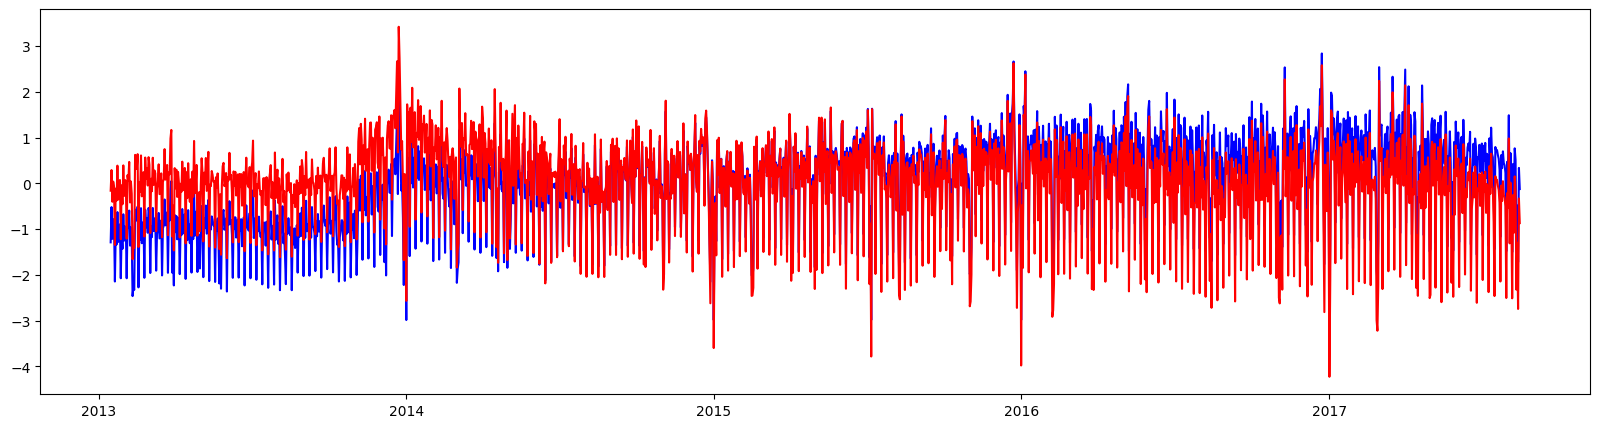

In [149]:
# Normalizando a série original e os resíduos
df_train_resid_subset['sales_normalized'] = (df_train_resid_subset['sales'] - df_train_resid_subset['sales'].mean()) / df_train_resid_subset['sales'].std()
df_train_resid_subset['residual_normalized'] = (df_train_resid_subset['residual'] - df_train_resid_subset['residual'].mean()) / df_train_resid_subset['residual'].std()

# Plotando a série original e o resíduo normalizados
plt.figure(figsize=(20, 5))
plt.plot(df_train_resid_subset['sales_normalized'], color='b', label='Original (Normalized)')
plt.plot(df_train_resid_subset['residual_normalized'], color='r', label='Residual (Normalized)')


Para ser possivel uma comparação entre a sales original e a residual, eu criei features de ambas na mesma escala fazendo um standartScale. É possivel perceber que por mais que a residual (VERMELHA) esteja apresentando pontos de sazonalidade mais acentuada, sua media esta mais estavel em torno de zero e provavelmente possui uma variancia menor, por isso ela é estacionaria.

##Modelagem

Como ja mencionei anteriormente, existem mais de 1700 combinações unicas de series temporias para serem previstas aqui, o metodo que irei utilizar para prever cada uma é aplicar estruturas de repetição para cada combinação de loja e family unica. gerando assim um dataframe para cada combinação unica que eu irei concatenar no final juntamento com  a ID unica, o valor original e o valor predito.

###Regressão linear - 1 (Todas as features)

In [150]:
df_train_final = df_train_resid.copy()

In [ ]:
# Remoção das linhas duplicadas ID eram linhas que tinham dados nulos referente ao natal, pois a loja não abre.
df_train_final= df_train_final.drop_duplicates(subset='id', keep=False)

In [151]:
# Criando uma instância de CalendarSeasonality para capturar a sazonalidade do dia da semana
week = CalendarSeasonality('D','W').in_sample(df_train_final.index)

# Adicionando o efeito do CalendarSeasonality ao DataFrame
df_train_final = pd.concat([df_train_final, week], axis=1)

Por mais que eu tenha criado uma feature que indica qual é o dia da semana, resolvi complementar criando algumas features binarias indicando o dia da semana com a biblioteca CalendarSeasonality, depois de alguns testes percebi que desempenhava melhor desta forma.

In [153]:
# Definindo o número de dias para a janela deslizante (últimos 15 dias)
janela_deslizante = 15

# Obtendo o período do índice da última data
ultimo_periodo = df_train_final.index.to_period('D').max()

# Obtendo o período do índice da data de início da janela deslizante (15 dias antes da última data)
data_inicio_janela = ultimo_periodo - janela_deslizante + 1

# Dados de treino (até a data de início da janela deslizante)
df_train_resid_treino = df_train_final[df_train_final.index.to_period('D') < data_inicio_janela]

# Dados de teste (últimos 15 dias, incluindo a data de início da janela deslizante)
df_train_resid_teste = df_train_final[df_train_final.index.to_period('D') >= data_inicio_janela]



Talvez eu tenha complicado esta divisão de treino e teste, poderia ter feito o mesmo de forma mais simplificada, porem como estou lidando com datas repetidas tive alguns problemas e o que funcionou foi pegar o ultimo dia do conjunto e subtrair os 15 dias de teste, apos isso apliquei o .to_period para ele aplicar em todas as datas que coincidem com a logica ao inves de só aplicar nas ultimas 15 linhas.

In [ ]:
# Função para realizar a previsão usando o modelo de regressão linear
def perform_linear_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo de regressão linear
    model = LinearRegression()

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# calculando regressão linear para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                          'preco_oleo_dia_anterior', 'preco_oleo_7dias_anteriores', 'preco_oleo_14dias_anteriores',
                          'feriado', 'tipo_feriado', 'mês', 'dia_semana', 'dia_mes', 'ano']

        # Fazer a previsão usando o modelo de regressão linear para a combinação atual
        previsoes_sales_original = perform_linear_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])

# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
predictions_df


Média RMSLE: 0.47734257785098133
Média RMSE: 161.63267107553798
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.527292    2.477272
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.449435    2.216210
3           1.0                   BEVERAGES  0.424237  681.871921
4           1.0                       BOOKS  0.533008    0.704605
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.224548   12.707828
1778       54.0              PREPARED FOODS  0.305121   29.373788
1779       54.0                     PRODUCE  0.333523  230.326643
1780       54.0  SCHOOL AND OFFICE SUPPLIES  1.228219    2.419519
1781       54.0                     SEAFOOD  0.790869    3.008518

[1782 rows x 4 columns]
Previsões Finais:


,id,store_nbr,family,sales,previsao
2017-08-01,2974158.0,1.0,AUTOMOTIVE,5.0,4.907721
2017-08-02,2975940.0,1.0,AUTOMOTIVE,4.0,4.525956
2017-08-03,2977722.0,1.0,AUTOMOTIVE,3.0,4.456692
2017-08-04,2979504.0,1.0,AUTOMOTIVE,8.0,4.387427
2017-08-05,2981286.0,1.0,AUTOMOTIVE,5.0,3.880662
...,...,...,...,...,...
2017-08-11,2993627.0,54.0,SEAFOOD,0.0,2.003523
2017-08-12,2995409.0,54.0,SEAFOOD,1.0,1.999427
2017-08-13,2997191.0,54.0,SEAFOOD,2.0,1.995330
2017-08-14,2998973.0,54.0,SEAFOOD,0.0,1.979094


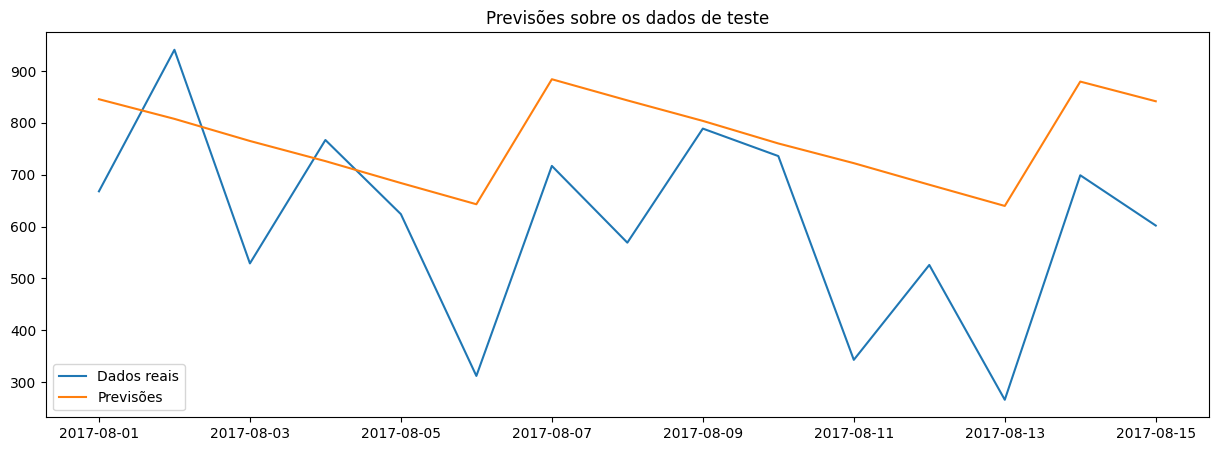

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'DAIRY')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste')
plt.show()

Para esse primeiro teste usando Regressão linear eu quis usar todas as features que eu criei, eu já suspeitava que o resultado não seria muito satisfatorio pois a regressão não lidaria muito bem com um numero maior de features devido as altas correlações, que podem atrapalhar o modelo a capturar relações nao lineares.

###Regressão Linear 2 - (Aplicando calendarSazonality)

In [ ]:
# Função para realizar a previsão usando o modelo de regressão linear
def perform_linear_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo de regressão linear
    model = LinearRegression()

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# calculando regressão linear para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                          'preco_oleo_dia_anterior', 'preco_oleo_7dias_anteriores', 'preco_oleo_14dias_anteriores',
                          's(D=1, period=W)', 's(D=2, period=W)','s(D=3, period=W)','s(D=4, period=W)','s(D=5, period=W)','s(D=6, period=W)','s(D=7, period=W)',
                         ]

        # Fazer a previsão usando o modelo de regressão linear para a combinação atual
        previsoes_sales_original = perform_linear_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])

# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
predictions_df


Média RMSLE: 0.44991612777008766
Média RMSE: 129.30509941341114
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.538681    2.692929
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.457229    2.511796
3           1.0                   BEVERAGES  0.248983  436.263323
4           1.0                       BOOKS  0.263535    0.305393
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.222968   14.076908
1778       54.0              PREPARED FOODS  0.302006   29.212252
1779       54.0                     PRODUCE  0.315033  202.951449
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.749038    1.141361
1781       54.0                     SEAFOOD  0.780938    3.097407

[1782 rows x 4 columns]
Previsões Finais:


,id,store_nbr,family,sales,previsao
2017-08-01,2974158.0,1.0,AUTOMOTIVE,5.0,4.233345
2017-08-02,2975940.0,1.0,AUTOMOTIVE,4.0,3.936062
2017-08-03,2977722.0,1.0,AUTOMOTIVE,3.0,3.472607
2017-08-04,2979504.0,1.0,AUTOMOTIVE,8.0,4.178841
2017-08-05,2981286.0,1.0,AUTOMOTIVE,5.0,4.303562
...,...,...,...,...,...
2017-08-11,2993627.0,54.0,SEAFOOD,0.0,1.109502
2017-08-12,2995409.0,54.0,SEAFOOD,1.0,1.732119
2017-08-13,2997191.0,54.0,SEAFOOD,2.0,2.447734
2017-08-14,2998973.0,54.0,SEAFOOD,0.0,2.043263


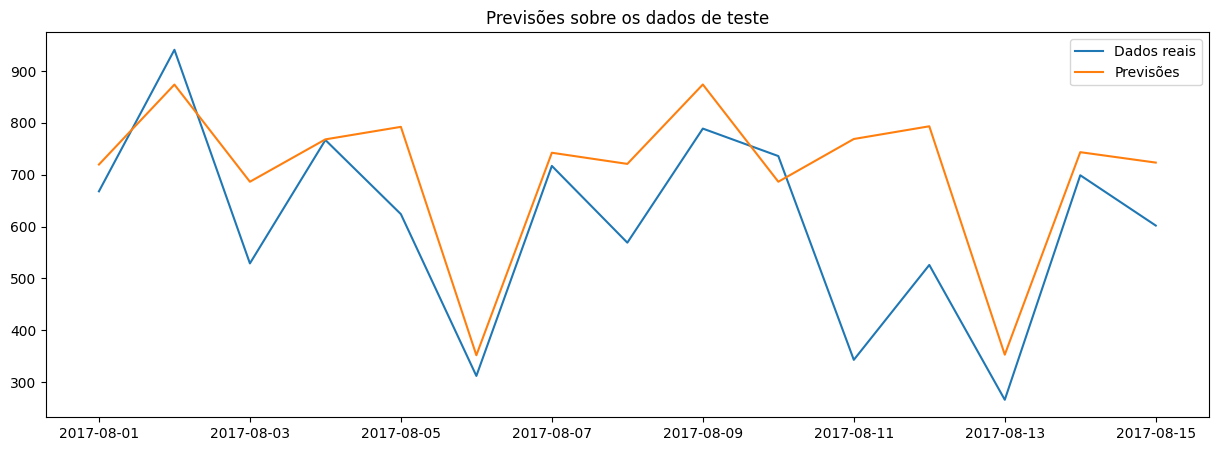

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'DAIRY')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste')
plt.show()

Ao remover algumas features com relação a feriados e dia do mês, Mês e Ano. e subistituir o dia da semana pelo calendarSazonality, conseguimos melhorar consideravelmente o desempenho do modelo, porem acredito que ainda é possivel uma melhora removendo mais algumas features.

###Regressão Linear 3 (Remoção de Features)

In [ ]:
# Função para realizar a previsão usando o modelo de regressão linear
def perform_linear_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo de regressão linear
    model = LinearRegression()

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# calculando regressão linear para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = [
                          's(D=1, period=W)', 's(D=2, period=W)','s(D=3, period=W)','s(D=4, period=W)','s(D=5, period=W)','s(D=6, period=W)','s(D=7, period=W)',
                          ]

        # Fazer a previsão usando o modelo de regressão linear para a combinação atual
        previsoes_sales_original = perform_linear_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])

# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
predictions_df


Média RMSLE: 0.4476855164570436
Média RMSE: 126.77494204802818
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.521966    2.583303
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.471003    2.564763
3           1.0                   BEVERAGES  0.249210  437.603321
4           1.0                       BOOKS  0.208103    0.232857
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.221964   13.962488
1778       54.0              PREPARED FOODS  0.306074   29.683188
1779       54.0                     PRODUCE  0.278822  186.447713
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.722789    1.088014
1781       54.0                     SEAFOOD  0.785775    3.117986

[1782 rows x 4 columns]
Previsões Finais:


,id,store_nbr,family,sales,previsao
2017-08-01,2974158.0,1.0,AUTOMOTIVE,5.0,4.328125
2017-08-02,2975940.0,1.0,AUTOMOTIVE,4.0,4.250000
2017-08-03,2977722.0,1.0,AUTOMOTIVE,3.0,3.640625
2017-08-04,2979504.0,1.0,AUTOMOTIVE,8.0,4.468750
2017-08-05,2981286.0,1.0,AUTOMOTIVE,5.0,4.390625
...,...,...,...,...,...
2017-08-11,2993627.0,54.0,SEAFOOD,0.0,1.097656
2017-08-12,2995409.0,54.0,SEAFOOD,1.0,1.687500
2017-08-13,2997191.0,54.0,SEAFOOD,2.0,2.453125
2017-08-14,2998973.0,54.0,SEAFOOD,0.0,2.070312


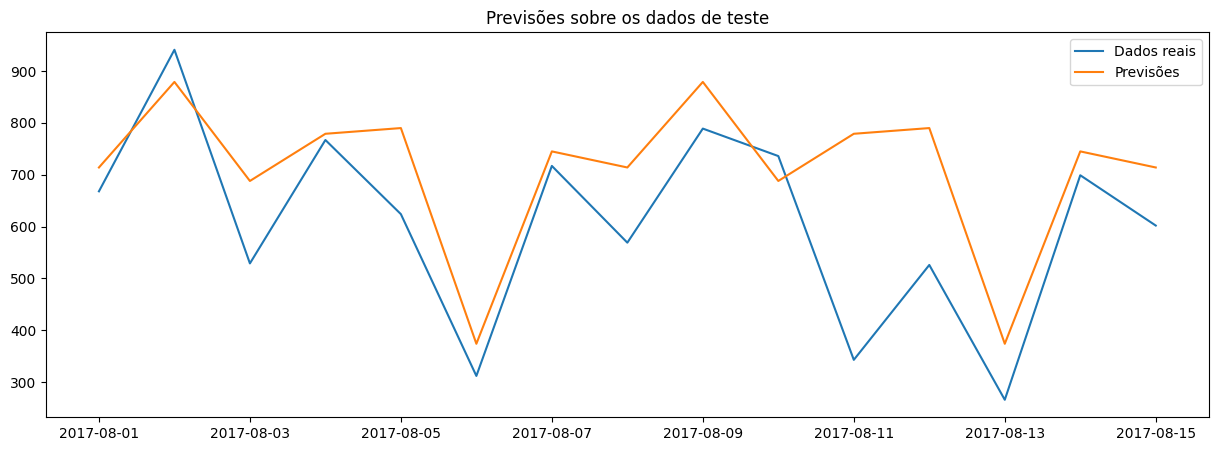

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'DAIRY')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste')
plt.show()

Deixando apenas a informação do calendar sazonality, temos uma pequena melhoria nas metricas, porem não muito significativas. Como o intuito de criar as features era utilizalas para o modelo desempenhar melhor, vamos partir para um modelo de arvore, onde acredito que ira se beneficiar melhor.

### LIGHTGBM 1 - (Mesmas features que a Regressão 2)

In [ ]:
# Dicionário para mapear os nomes atuais para os novos nomes
rename_dict = {
    's(D=1, period=W)': 's_D_1_period_W',
    's(D=2, period=W)': 's_D_2_period_W',
    's(D=3, period=W)': 's_D_3_period_W',
    's(D=4, period=W)': 's_D_4_period_W',
    's(D=5, period=W)': 's_D_5_period_W',
    's(D=6, period=W)': 's_D_6_period_W',
    's(D=7, period=W)': 's_D_7_period_W'
}

# Renomeando as colunas com base no dicionário
df_train_final.rename(columns=rename_dict, inplace=True)

O modelo dO LGBM não aceita features com alguns caracteries especiais então tive que renomear as colunas acima.

In [ ]:
# Definindo o número de dias para a janela deslizante (últimos 15 dias)
janela_deslizante = 15

# Obtendo o período do índice da última data
ultimo_periodo = df_train_final.index.to_period('D').max()

# Obtendo o período do índice da data de início da janela deslizante (15 dias antes da última data)
data_inicio_janela = ultimo_periodo - janela_deslizante + 1

# Dados de treino (até a data de início da janela deslizante)
df_train_resid_treino = df_train_final[df_train_final.index.to_period('D') < data_inicio_janela]

# Dados de teste (últimos 15 dias, incluindo a data de início da janela deslizante)
df_train_resid_teste = df_train_final[df_train_final.index.to_period('D') >= data_inicio_janela]



In [ ]:
# Função para realizar a previsão usando o LightGBM
def perform_lightgbm_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo LightGBM para regressão
    model = lgb.LGBMRegressor()

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# Calculando previsões usando LightGBM para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                          'preco_oleo_dia_anterior', 'preco_oleo_7dias_anteriores', 'preco_oleo_14dias_anteriores',
                         's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                         ]

        # Fazer a previsão usando o modelo LightGBM para a combinação atual
        previsoes_sales_original = perform_lightgbm_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])


# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
print(predictions_df)


Média RMSLE: 0.483893007792145
Média RMSE: 131.89937048736647
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.564675    2.950823
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.571644    2.894187
3           1.0                   BEVERAGES  0.243291  439.536875
4           1.0                       BOOKS  0.264541    0.356423
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.253587   15.795471
1778       54.0              PREPARED FOODS  0.321794   29.290483
1779       54.0                     PRODUCE  0.396950  209.001175
1780       54.0  SCHOOL AND OFFICE SUPPLIES  1.164773    2.966140
1781       54.0                     SEAFOOD  0.813635    3.216300

[1782 rows x 4 columns]
Previsões Finais:
                   id  store_nbr      family  sales  previsao
2017-0

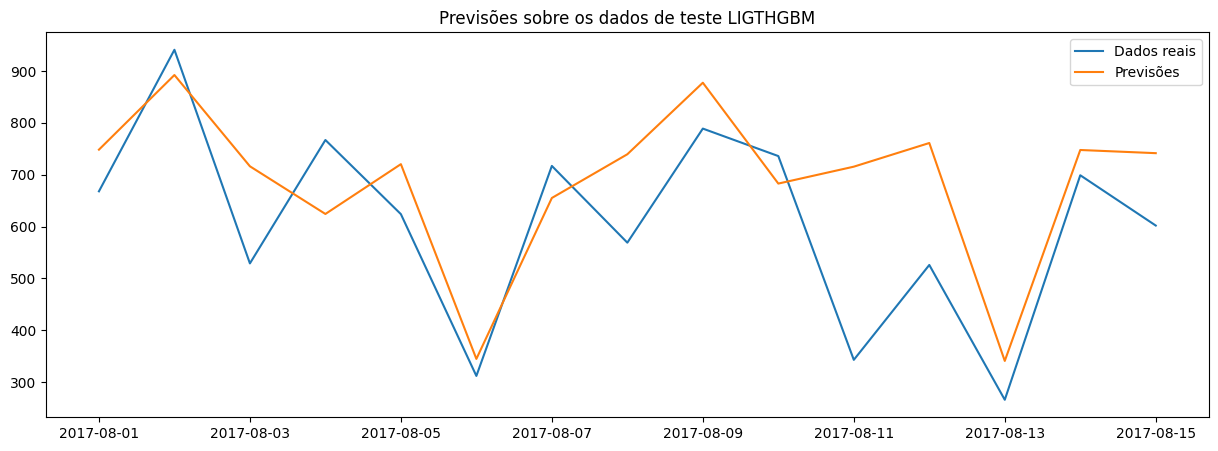

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'DAIRY')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste LIGTHGBM')
plt.show()

Eu acreditava fielmente que o desempenho aqui seria melhor, porem foi ligeiramente inferior, então comecei a suspeitar da qualidade das features que criei e que ao inves de ajudar estavam atrapalhando o desempenho dos modelos então vamos tirar elas e deixar apenas o calendarSazonality e ver se melhora o desempenho.

### LIGHTGBM 2 - (Mesmas features que a Regressão 3)

In [ ]:
# Função para realizar a previsão usando o LightGBM
def perform_lightgbm_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo LightGBM para regressão
    model = lgb.LGBMRegressor(n_estimators = 100,max_depth=6,learning_rate=0.1,boosting_type='goss')

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# Calculando previsões usando LightGBM para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = [
                         's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                         ]

        # Fazer a previsão usando o modelo LightGBM para a combinação atual
        previsoes_sales_original = perform_lightgbm_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])


# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
print(predictions_df)


Média RMSLE: 0.5341427127854292
Média RMSE: 164.79769525906292
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.564534    2.848333
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.494201    2.673902
3           1.0                   BEVERAGES  0.306235  572.661276
4           1.0                       BOOKS  0.127920    0.137075
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.258875   16.438360
1778       54.0              PREPARED FOODS  0.407931   36.107759
1779       54.0                     PRODUCE  0.646669  349.533284
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.486539    0.636608
1781       54.0                     SEAFOOD  0.741492    3.011052

[1782 rows x 4 columns]
Previsões Finais:
                   id  store_nbr      family  sales  previsao
2017-

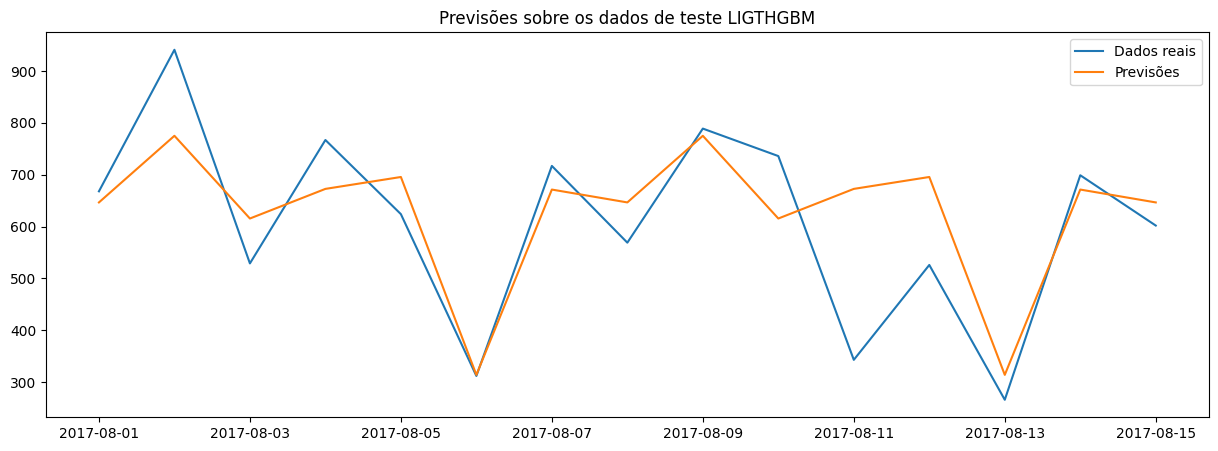

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'DAIRY')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste LIGTHGBM')
plt.show()

Este é um bom exemplo de como os modelos funcionam de forma diferente o desempenho nas metricas piorou consideravelmente ao inves de melhorar como foi o caso da regressão, neste ponto comecei a suspeitar fortemente que para um modelo de arvore estava com pouca complexidade nos meus dados(poucas Features), porem antes de pensar em criar mais features, resolvi testar uma tunagem de hiperparametros.

### LIGHTGBM 3 - (Tunando hiperparametros.)

In [ ]:
# Função para realizar a previsão usando o LightGBM com grid search para parâmetros
def perform_lightgbm_regression_with_grid_search(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Definindo os parâmetros para o grid search
    param_grid = {
        'learning_rate': [0.01],
        'max_depth': [3, 6],
        'n_estimators': [100,200],
        'boosting_type': ["gbdt","dart","goss"]
    }

    # Inicializando o modelo LightGBM para regressão
    model = lgb.LGBMRegressor()

    # Realizando o grid search para encontrar os melhores parâmetros
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)

    # Melhores parâmetros encontrados
    best_params = grid_search.best_params_
    print("Melhores parâmetros:", best_params)

    # Treinando o modelo usando os dados de treino com os melhores parâmetros
    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train)

    # Fazendo as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions


# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])


# Calculando previsões usando LightGBM com grid search para cada combinação de store_nbr e family
num_combinations = len(df_train_resid_teste['store_nbr'].unique()) * len(df_train_resid_teste['family'].unique())
with tqdm(total=num_combinations, desc='Progresso') as pbar: #CONTADOR DE TEMPO (PROGRESSO)
    for store_nbr in df_train_resid_teste['store_nbr'].unique():
        for family in df_train_resid_teste['family'].unique():
            df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
            df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

            # Colunas que serão usadas no treinamento do modelo
            colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                              'preco_oleo_dia_anterior', 'preco_oleo_7dias_anteriores', 'preco_oleo_14dias_anteriores',
                             's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                             ]

            # Fazer a previsão usando o modelo LightGBM com grid search para a combinação atual
            previsoes_sales_original = perform_lightgbm_regression_with_grid_search(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

            # Adicionar as previsões ao DataFrame de previsões
            df_store_family_test['previsao'] = previsoes_sales_original

            # Calcular as métricas RMSLE e RMSE
            rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

            # Adicionar os resultados ao DataFrame de métricas
            metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

            # Adicionar os resultados ao DataFrame de previsões finais
            predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])

            pbar.update(1)  # Atualizar a barra de progresso


# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
print(predictions_df)



Progresso:   0%|          | 1/1782 [00:05<2:32:10,  5.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   0%|          | 2/1782 [00:05<1:17:04,  2.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   0%|          | 3/1782 [00:09<1:25:32,  2.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   0%|          | 4/1782 [00:14<1:51:33,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   0%|          | 5/1782 [00:16<1:36:30,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   0%|          | 6/1782 [00:20<1:37:49,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   0%|          | 7/1782 [00:25<1:54:14,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   0%|          | 8/1782 [00:28<1:50:45,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   1%|          | 9/1782 [00:34<2:07:43,  4.32s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 10/1782 [00:39<2:13:32,  4.52s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 11/1782 [00:42<2:05:18,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   1%|          | 12/1782 [00:45<1:54:52,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   1%|          | 13/1782 [00:50<2:05:43,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 14/1782 [00:54<1:58:39,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   1%|          | 15/1782 [00:57<1:50:44,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   1%|          | 16/1782 [01:02<2:02:38,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 17/1782 [01:05<1:54:29,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 18/1782 [01:09<1:47:16,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   1%|          | 19/1782 [01:14<1:59:50,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 20/1782 [01:17<1:51:46,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 21/1782 [01:20<1:47:31,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|          | 22/1782 [01:25<1:59:45,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|▏         | 23/1782 [01:28<1:53:06,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   1%|▏         | 25/1782 [01:37<2:03:58,  4.23s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   1%|▏         | 26/1782 [01:41<1:57:27,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 27/1782 [01:44<1:50:01,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   2%|▏         | 28/1782 [01:49<2:01:15,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 29/1782 [01:52<1:54:13,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 30/1782 [01:56<1:49:16,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 31/1782 [02:01<2:00:38,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 32/1782 [02:04<1:53:43,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 33/1782 [02:08<1:50:35,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 34/1782 [02:13<2:01:28,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 35/1782 [02:15<1:44:00,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   2%|▏         | 36/1782 [02:18<1:41:10,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 38/1782 [02:26<1:42:46,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   2%|▏         | 39/1782 [02:29<1:42:36,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 40/1782 [02:32<1:40:00,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   2%|▏         | 41/1782 [02:38<1:56:13,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 42/1782 [02:41<1:51:46,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 43/1782 [02:45<1:49:06,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   2%|▏         | 44/1782 [02:50<2:00:34,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 45/1782 [02:53<1:51:03,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   3%|▎         | 46/1782 [02:56<1:47:57,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   3%|▎         | 47/1782 [03:01<1:59:28,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 48/1782 [03:05<1:51:32,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 49/1782 [03:08<1:46:16,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 50/1782 [03:13<1:59:18,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   3%|▎         | 51/1782 [03:16<1:50:03,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   3%|▎         | 52/1782 [03:19<1:45:02,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 53/1782 [03:24<1:56:24,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 54/1782 [03:28<1:50:08,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   3%|▎         | 55/1782 [03:31<1:45:12,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 56/1782 [03:36<1:57:27,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 57/1782 [03:39<1:51:11,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 58/1782 [03:43<1:46:07,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   3%|▎         | 59/1782 [03:48<1:58:46,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 60/1782 [03:51<1:49:56,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   3%|▎         | 61/1782 [03:54<1:45:02,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   3%|▎         | 62/1782 [03:58<1:42:37,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   4%|▎         | 63/1782 [04:03<1:55:31,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   4%|▎         | 64/1782 [04:06<1:49:10,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   4%|▎         | 65/1782 [04:09<1:45:45,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▎         | 66/1782 [04:15<1:59:21,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 67/1782 [04:18<1:51:56,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   4%|▍         | 68/1782 [04:20<1:37:07,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   4%|▍         | 69/1782 [04:25<1:52:54,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 70/1782 [04:29<1:47:15,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   4%|▍         | 71/1782 [04:31<1:34:08,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   4%|▍         | 72/1782 [04:36<1:51:19,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 73/1782 [04:40<1:45:57,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   4%|▍         | 74/1782 [04:43<1:43:54,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 75/1782 [04:48<1:57:39,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 76/1782 [04:52<1:52:43,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 77/1782 [04:56<1:49:07,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 78/1782 [05:00<1:58:49,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   4%|▍         | 79/1782 [05:04<1:52:46,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   4%|▍         | 80/1782 [05:07<1:47:14,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▍         | 81/1782 [05:12<1:58:55,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▍         | 82/1782 [05:16<1:50:33,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   5%|▍         | 83/1782 [05:19<1:44:14,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▍         | 84/1782 [05:24<1:55:16,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   5%|▍         | 85/1782 [05:27<1:49:25,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▍         | 86/1782 [05:31<1:44:25,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   5%|▍         | 88/1782 [05:39<1:52:28,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   5%|▍         | 89/1782 [05:43<1:49:10,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 90/1782 [05:48<2:00:58,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 91/1782 [05:52<1:55:56,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   5%|▌         | 92/1782 [05:56<1:52:48,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   5%|▌         | 93/1782 [06:01<2:03:07,  4.37s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   5%|▌         | 94/1782 [06:04<1:54:17,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 95/1782 [06:08<1:48:45,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 96/1782 [06:13<1:59:17,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 97/1782 [06:16<1:52:02,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   5%|▌         | 98/1782 [06:19<1:45:53,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   6%|▌         | 99/1782 [06:25<1:57:36,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 100/1782 [06:28<1:50:09,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   6%|▌         | 101/1782 [06:30<1:34:36,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   6%|▌         | 102/1782 [06:33<1:34:08,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 103/1782 [06:38<1:48:16,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 104/1782 [06:41<1:33:21,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   6%|▌         | 105/1782 [06:44<1:34:08,  3.37s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 106/1782 [06:49<1:48:28,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 107/1782 [06:52<1:44:14,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 108/1782 [06:56<1:42:52,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   6%|▌         | 109/1782 [07:01<1:55:58,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   6%|▌         | 110/1782 [07:05<1:49:27,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▌         | 111/1782 [07:08<1:43:10,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   6%|▋         | 112/1782 [07:13<1:56:03,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   6%|▋         | 113/1782 [07:16<1:47:59,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   6%|▋         | 114/1782 [07:19<1:41:40,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   6%|▋         | 115/1782 [07:23<1:38:26,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 116/1782 [07:28<1:49:33,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   7%|▋         | 117/1782 [07:31<1:42:52,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   7%|▋         | 118/1782 [07:34<1:39:17,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 119/1782 [07:39<1:50:42,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 120/1782 [07:42<1:45:48,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   7%|▋         | 121/1782 [07:46<1:41:12,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 122/1782 [07:51<1:52:55,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 123/1782 [07:54<1:47:12,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 124/1782 [07:58<1:44:18,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   7%|▋         | 125/1782 [08:03<1:57:05,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   7%|▋         | 126/1782 [08:06<1:50:10,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 127/1782 [08:10<1:43:33,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 128/1782 [08:15<1:55:12,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 129/1782 [08:18<1:48:02,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 130/1782 [08:21<1:42:56,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 131/1782 [08:26<1:53:49,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   7%|▋         | 132/1782 [08:30<1:48:08,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   7%|▋         | 133/1782 [08:34<1:45:00,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   8%|▊         | 134/1782 [08:37<1:45:35,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 135/1782 [08:41<1:41:51,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   8%|▊         | 136/1782 [08:44<1:37:49,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   8%|▊         | 137/1782 [08:46<1:27:56,  3.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 138/1782 [08:51<1:43:16,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 139/1782 [08:55<1:39:53,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   8%|▊         | 140/1782 [08:58<1:37:21,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   8%|▊         | 141/1782 [09:03<1:50:46,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   8%|▊         | 142/1782 [09:07<1:45:01,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 143/1782 [09:10<1:42:02,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   8%|▊         | 144/1782 [09:15<1:50:31,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 145/1782 [09:18<1:45:43,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   8%|▊         | 146/1782 [09:22<1:40:46,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 147/1782 [09:27<1:50:49,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 148/1782 [09:30<1:44:02,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   8%|▊         | 149/1782 [09:33<1:39:09,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   8%|▊         | 150/1782 [09:38<1:50:00,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   8%|▊         | 151/1782 [09:41<1:43:51,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▊         | 152/1782 [09:45<1:39:24,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▊         | 153/1782 [09:50<1:52:04,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▊         | 154/1782 [09:53<1:46:40,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   9%|▊         | 155/1782 [09:57<1:42:15,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 156/1782 [10:02<1:52:46,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 157/1782 [10:05<1:46:53,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:   9%|▉         | 158/1782 [10:09<1:43:01,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   9%|▉         | 159/1782 [10:14<1:54:02,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 160/1782 [10:17<1:45:55,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 161/1782 [10:20<1:40:25,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▉         | 162/1782 [10:25<1:50:06,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▉         | 163/1782 [10:29<1:43:14,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▉         | 164/1782 [10:32<1:40:02,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:   9%|▉         | 165/1782 [10:37<1:51:10,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▉         | 166/1782 [10:40<1:43:16,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 167/1782 [10:42<1:27:16,  3.24s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:   9%|▉         | 168/1782 [10:46<1:27:54,  3.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:   9%|▉         | 169/1782 [10:51<1:42:37,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|▉         | 170/1782 [10:53<1:28:49,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  10%|▉         | 171/1782 [10:56<1:30:59,  3.39s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|▉         | 172/1782 [11:01<1:44:35,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|▉         | 173/1782 [11:05<1:41:58,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|▉         | 174/1782 [11:08<1:39:43,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|▉         | 175/1782 [11:14<1:52:47,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|▉         | 176/1782 [11:17<1:47:26,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|▉         | 177/1782 [11:20<1:39:52,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  10%|▉         | 178/1782 [11:26<1:52:33,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|█         | 179/1782 [11:29<1:46:46,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  10%|█         | 180/1782 [11:32<1:40:12,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  10%|█         | 181/1782 [11:37<1:49:54,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|█         | 182/1782 [11:41<1:42:35,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|█         | 183/1782 [11:44<1:35:16,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  10%|█         | 184/1782 [11:47<1:32:40,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|█         | 185/1782 [11:52<1:44:50,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  10%|█         | 186/1782 [11:55<1:39:42,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  10%|█         | 187/1782 [11:58<1:35:48,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  11%|█         | 188/1782 [12:04<1:48:07,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 189/1782 [12:07<1:42:44,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 190/1782 [12:11<1:40:05,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  11%|█         | 191/1782 [12:16<1:52:20,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  11%|█         | 192/1782 [12:19<1:45:42,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 193/1782 [12:23<1:40:42,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 194/1782 [12:28<1:51:23,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 195/1782 [12:31<1:44:23,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 196/1782 [12:35<1:39:44,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 197/1782 [12:39<1:48:49,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 198/1782 [12:43<1:44:10,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  11%|█         | 199/1782 [12:46<1:39:12,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█         | 200/1782 [12:50<1:40:54,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  11%|█▏        | 201/1782 [12:54<1:36:03,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█▏        | 202/1782 [12:57<1:33:10,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  11%|█▏        | 203/1782 [12:59<1:22:56,  3.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  11%|█▏        | 204/1782 [13:04<1:38:18,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 205/1782 [13:07<1:34:35,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 206/1782 [13:11<1:34:07,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  12%|█▏        | 207/1782 [13:16<1:45:18,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 208/1782 [13:19<1:39:26,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 209/1782 [13:23<1:37:10,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  12%|█▏        | 210/1782 [13:28<1:45:47,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  12%|█▏        | 211/1782 [13:31<1:40:02,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 212/1782 [13:34<1:35:50,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 213/1782 [13:39<1:46:43,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 214/1782 [13:42<1:39:38,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 215/1782 [13:46<1:34:43,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 216/1782 [13:51<1:44:28,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  12%|█▏        | 217/1782 [13:54<1:38:48,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 218/1782 [13:57<1:33:06,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  12%|█▏        | 219/1782 [14:02<1:45:28,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  12%|█▏        | 220/1782 [14:05<1:39:21,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 221/1782 [14:09<1:35:51,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  12%|█▏        | 222/1782 [14:14<1:46:37,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 223/1782 [14:17<1:40:06,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 224/1782 [14:21<1:37:20,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  13%|█▎        | 225/1782 [14:26<1:48:23,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 226/1782 [14:29<1:41:33,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 227/1782 [14:32<1:37:04,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 229/1782 [14:41<1:41:18,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 230/1782 [14:44<1:36:04,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 231/1782 [14:47<1:32:57,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  13%|█▎        | 232/1782 [14:52<1:43:36,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 233/1782 [14:54<1:29:27,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  13%|█▎        | 234/1782 [14:58<1:28:08,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 235/1782 [15:03<1:40:49,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 236/1782 [15:05<1:28:19,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  13%|█▎        | 237/1782 [15:09<1:28:43,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  13%|█▎        | 238/1782 [15:14<1:41:33,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 239/1782 [15:17<1:36:43,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  13%|█▎        | 240/1782 [15:21<1:34:49,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▎        | 241/1782 [15:26<1:47:48,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▎        | 242/1782 [15:29<1:42:24,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▎        | 243/1782 [15:33<1:35:43,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  14%|█▎        | 244/1782 [15:38<1:47:09,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▎        | 245/1782 [15:41<1:39:40,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 246/1782 [15:44<1:33:48,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  14%|█▍        | 247/1782 [15:47<1:29:13,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 248/1782 [15:52<1:40:09,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 249/1782 [15:55<1:33:49,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  14%|█▍        | 250/1782 [15:59<1:30:53,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 251/1782 [16:04<1:43:33,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 252/1782 [16:07<1:38:08,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  14%|█▍        | 253/1782 [16:10<1:33:21,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  14%|█▍        | 254/1782 [16:16<1:44:41,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 255/1782 [16:19<1:39:20,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  14%|█▍        | 256/1782 [16:22<1:35:54,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▍        | 257/1782 [16:28<1:47:46,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  14%|█▍        | 258/1782 [16:31<1:40:28,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▍        | 259/1782 [16:34<1:35:00,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  15%|█▍        | 260/1782 [16:40<1:46:06,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▍        | 261/1782 [16:43<1:41:31,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  15%|█▍        | 262/1782 [16:46<1:36:18,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▍        | 263/1782 [16:52<1:46:55,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▍        | 264/1782 [16:55<1:41:08,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▍        | 265/1782 [16:58<1:35:36,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  15%|█▍        | 266/1782 [17:03<1:44:19,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  15%|█▍        | 267/1782 [17:07<1:39:02,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▌        | 268/1782 [17:10<1:34:44,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▌        | 269/1782 [17:11<1:12:45,  2.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  15%|█▌        | 270/1782 [17:16<1:29:40,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▌        | 271/1782 [17:19<1:27:53,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▌        | 272/1782 [17:23<1:28:25,  3.51s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  15%|█▌        | 273/1782 [17:28<1:42:11,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  15%|█▌        | 274/1782 [17:32<1:37:21,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  15%|█▌        | 275/1782 [17:35<1:33:30,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  15%|█▌        | 276/1782 [17:40<1:43:46,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  16%|█▌        | 277/1782 [17:44<1:39:42,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  16%|█▌        | 278/1782 [17:47<1:33:38,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  16%|█▌        | 279/1782 [17:52<1:41:57,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  16%|█▌        | 280/1782 [17:55<1:35:38,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  16%|█▌        | 281/1782 [17:58<1:31:42,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 282/1782 [18:03<1:40:51,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  16%|█▌        | 283/1782 [18:07<1:35:59,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 284/1782 [18:10<1:31:54,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 285/1782 [18:15<1:43:48,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  16%|█▌        | 286/1782 [18:19<1:36:34,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 287/1782 [18:22<1:32:35,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 288/1782 [18:27<1:43:41,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▌        | 289/1782 [18:30<1:37:55,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▋        | 290/1782 [18:34<1:35:10,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  16%|█▋        | 291/1782 [18:39<1:44:41,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▋        | 292/1782 [18:42<1:37:42,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▋        | 293/1782 [18:46<1:33:07,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  16%|█▋        | 294/1782 [18:51<1:44:18,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  17%|█▋        | 295/1782 [18:54<1:37:23,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  17%|█▋        | 296/1782 [18:58<1:33:37,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  17%|█▋        | 297/1782 [19:03<1:44:33,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  17%|█▋        | 298/1782 [19:06<1:36:48,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  17%|█▋        | 299/1782 [19:09<1:31:43,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  17%|█▋        | 300/1782 [19:14<1:41:08,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  17%|█▋        | 301/1782 [19:18<1:35:33,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  17%|█▋        | 302/1782 [19:19<1:12:58,  2.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  17%|█▋        | 303/1782 [19:22<1:15:14,  3.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  17%|█▋        | 304/1782 [19:27<1:29:55,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  17%|█▋        | 305/1782 [19:30<1:28:00,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  17%|█▋        | 306/1782 [19:34<1:27:15,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  17%|█▋        | 307/1782 [19:39<1:39:12,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  17%|█▋        | 308/1782 [19:42<1:33:50,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  17%|█▋        | 309/1782 [19:45<1:28:52,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  17%|█▋        | 310/1782 [19:51<1:41:05,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  17%|█▋        | 311/1782 [19:54<1:34:28,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  18%|█▊        | 312/1782 [19:57<1:29:32,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  18%|█▊        | 313/1782 [20:02<1:38:20,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 314/1782 [20:05<1:33:53,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  18%|█▊        | 315/1782 [20:09<1:28:46,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  18%|█▊        | 316/1782 [20:14<1:39:32,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 317/1782 [20:17<1:33:01,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 318/1782 [20:19<1:20:44,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  18%|█▊        | 319/1782 [20:22<1:21:29,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  18%|█▊        | 320/1782 [20:27<1:33:30,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 321/1782 [20:31<1:29:19,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 322/1782 [20:34<1:27:36,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  18%|█▊        | 323/1782 [20:40<1:41:13,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  18%|█▊        | 324/1782 [20:43<1:34:14,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  18%|█▊        | 325/1782 [20:46<1:31:06,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  18%|█▊        | 326/1782 [20:51<1:40:43,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 327/1782 [20:55<1:34:48,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 328/1782 [20:58<1:30:46,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  18%|█▊        | 329/1782 [21:03<1:40:09,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  19%|█▊        | 330/1782 [21:06<1:33:12,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  19%|█▊        | 331/1782 [21:10<1:29:00,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  19%|█▊        | 332/1782 [21:15<1:39:41,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  19%|█▊        | 333/1782 [21:18<1:33:43,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  19%|█▊        | 334/1782 [21:22<1:31:16,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 335/1782 [21:23<1:10:12,  2.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  19%|█▉        | 336/1782 [21:28<1:28:10,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  19%|█▉        | 337/1782 [21:31<1:26:24,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  19%|█▉        | 338/1782 [21:35<1:26:51,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 339/1782 [21:41<1:41:25,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 340/1782 [21:44<1:37:05,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 341/1782 [21:48<1:31:56,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  19%|█▉        | 342/1782 [21:53<1:40:58,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  19%|█▉        | 343/1782 [21:56<1:36:32,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 344/1782 [22:00<1:31:46,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  19%|█▉        | 345/1782 [22:05<1:39:59,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  19%|█▉        | 346/1782 [22:08<1:34:47,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  19%|█▉        | 347/1782 [22:12<1:31:37,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  20%|█▉        | 348/1782 [22:17<1:41:59,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  20%|█▉        | 349/1782 [22:20<1:35:46,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  20%|█▉        | 350/1782 [22:24<1:31:23,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|█▉        | 351/1782 [22:29<1:42:14,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  20%|█▉        | 352/1782 [22:33<1:35:53,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|█▉        | 353/1782 [22:36<1:31:35,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|█▉        | 354/1782 [22:41<1:41:39,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|█▉        | 355/1782 [22:45<1:35:16,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|█▉        | 356/1782 [22:48<1:32:20,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  20%|██        | 357/1782 [22:53<1:41:44,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|██        | 358/1782 [22:57<1:36:28,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  20%|██        | 359/1782 [23:00<1:31:55,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  20%|██        | 360/1782 [23:06<1:41:13,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|██        | 361/1782 [23:09<1:35:10,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|██        | 362/1782 [23:12<1:29:58,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  20%|██        | 363/1782 [23:17<1:39:35,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|██        | 364/1782 [23:21<1:32:59,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  20%|██        | 365/1782 [23:23<1:21:51,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██        | 366/1782 [23:28<1:34:09,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██        | 367/1782 [23:32<1:31:16,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  21%|██        | 368/1782 [23:33<1:09:32,  2.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██        | 369/1782 [23:36<1:13:31,  3.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  21%|██        | 370/1782 [23:41<1:28:01,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██        | 371/1782 [23:45<1:25:18,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██        | 372/1782 [23:48<1:23:16,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██        | 373/1782 [23:53<1:35:06,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  21%|██        | 374/1782 [23:57<1:29:35,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██        | 375/1782 [24:00<1:25:39,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  21%|██        | 376/1782 [24:05<1:36:44,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  21%|██        | 377/1782 [24:08<1:30:41,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██        | 378/1782 [24:12<1:25:48,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██▏       | 379/1782 [24:17<1:34:54,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██▏       | 380/1782 [24:20<1:30:49,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  21%|██▏       | 381/1782 [24:23<1:25:30,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  21%|██▏       | 382/1782 [24:28<1:36:08,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  21%|██▏       | 383/1782 [24:32<1:29:23,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 384/1782 [24:34<1:19:58,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  22%|██▏       | 385/1782 [24:39<1:30:27,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  22%|██▏       | 386/1782 [24:42<1:26:37,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  22%|██▏       | 388/1782 [24:51<1:36:08,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 389/1782 [24:55<1:31:56,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  22%|██▏       | 390/1782 [24:58<1:27:52,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 391/1782 [25:03<1:37:05,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  22%|██▏       | 392/1782 [25:06<1:29:40,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 393/1782 [25:10<1:26:32,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  22%|██▏       | 394/1782 [25:15<1:36:03,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  22%|██▏       | 395/1782 [25:18<1:29:27,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 396/1782 [25:22<1:26:28,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  22%|██▏       | 397/1782 [25:27<1:38:18,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  22%|██▏       | 398/1782 [25:28<1:14:36,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 399/1782 [25:31<1:14:59,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  22%|██▏       | 400/1782 [25:34<1:14:58,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 401/1782 [25:35<58:32,  2.54s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  23%|██▎       | 402/1782 [25:41<1:17:12,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 403/1782 [25:44<1:16:14,  3.32s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  23%|██▎       | 404/1782 [25:47<1:17:14,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  23%|██▎       | 405/1782 [25:53<1:30:42,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  23%|██▎       | 406/1782 [25:56<1:27:55,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  23%|██▎       | 407/1782 [26:00<1:25:01,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  23%|██▎       | 408/1782 [26:05<1:33:35,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  23%|██▎       | 409/1782 [26:08<1:29:56,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  23%|██▎       | 410/1782 [26:11<1:25:46,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 411/1782 [26:16<1:34:31,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  23%|██▎       | 412/1782 [26:20<1:29:00,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  23%|██▎       | 413/1782 [26:23<1:24:28,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 414/1782 [26:28<1:33:16,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 415/1782 [26:31<1:28:16,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  23%|██▎       | 416/1782 [26:35<1:24:42,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  23%|██▎       | 417/1782 [26:40<1:32:28,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  23%|██▎       | 418/1782 [26:43<1:28:03,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▎       | 419/1782 [26:47<1:24:52,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▎       | 420/1782 [26:52<1:34:09,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▎       | 421/1782 [26:55<1:29:21,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▎       | 422/1782 [26:59<1:26:19,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  24%|██▎       | 423/1782 [27:04<1:34:43,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  24%|██▍       | 424/1782 [27:07<1:29:19,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 425/1782 [27:10<1:25:38,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 426/1782 [27:15<1:33:55,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 427/1782 [27:19<1:28:00,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 428/1782 [27:22<1:22:49,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  24%|██▍       | 430/1782 [27:30<1:26:52,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  24%|██▍       | 431/1782 [27:32<1:15:33,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  24%|██▍       | 432/1782 [27:36<1:15:18,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 433/1782 [27:41<1:27:56,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  24%|██▍       | 434/1782 [27:42<1:07:02,  2.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  24%|██▍       | 435/1782 [27:45<1:09:07,  3.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  24%|██▍       | 436/1782 [27:48<1:10:17,  3.13s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▍       | 437/1782 [27:54<1:24:25,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  25%|██▍       | 438/1782 [27:57<1:21:33,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▍       | 439/1782 [28:00<1:19:01,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▍       | 440/1782 [28:05<1:29:28,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▍       | 441/1782 [28:08<1:23:40,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  25%|██▍       | 442/1782 [28:12<1:21:22,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  25%|██▍       | 443/1782 [28:17<1:30:08,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▍       | 444/1782 [28:20<1:24:52,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▍       | 445/1782 [28:23<1:22:11,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  25%|██▌       | 446/1782 [28:29<1:31:32,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▌       | 447/1782 [28:32<1:25:02,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▌       | 448/1782 [28:35<1:21:25,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▌       | 449/1782 [28:40<1:29:56,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▌       | 450/1782 [28:41<1:08:31,  3.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▌       | 451/1782 [28:44<1:09:20,  3.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▌       | 452/1782 [28:47<1:10:08,  3.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  25%|██▌       | 453/1782 [28:52<1:23:12,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  25%|██▌       | 454/1782 [28:56<1:20:05,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▌       | 455/1782 [28:59<1:18:01,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  26%|██▌       | 457/1782 [29:08<1:25:33,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▌       | 458/1782 [29:11<1:21:23,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▌       | 459/1782 [29:16<1:30:26,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▌       | 460/1782 [29:19<1:24:53,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▌       | 461/1782 [29:23<1:20:50,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▌       | 462/1782 [29:28<1:29:33,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▌       | 463/1782 [29:31<1:24:35,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▌       | 464/1782 [29:34<1:20:17,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  26%|██▌       | 465/1782 [29:37<1:16:42,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▌       | 466/1782 [29:42<1:27:58,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▌       | 467/1782 [29:43<1:07:05,  3.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▋       | 468/1782 [29:47<1:08:51,  3.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  26%|██▋       | 469/1782 [29:52<1:21:10,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▋       | 470/1782 [29:55<1:18:28,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  26%|██▋       | 471/1782 [29:59<1:18:11,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  26%|██▋       | 472/1782 [30:04<1:29:08,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  27%|██▋       | 473/1782 [30:07<1:24:42,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  27%|██▋       | 474/1782 [30:10<1:20:37,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  27%|██▋       | 475/1782 [30:16<1:29:36,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 476/1782 [30:19<1:23:39,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 477/1782 [30:22<1:18:38,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 478/1782 [30:25<1:15:14,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 479/1782 [30:30<1:26:23,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 480/1782 [30:33<1:20:47,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 481/1782 [30:37<1:18:33,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 482/1782 [30:42<1:26:58,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 483/1782 [30:44<1:17:42,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 484/1782 [30:47<1:15:03,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 485/1782 [30:52<1:25:27,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 486/1782 [30:56<1:21:30,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 487/1782 [30:59<1:19:03,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  27%|██▋       | 488/1782 [31:04<1:28:36,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  27%|██▋       | 489/1782 [31:08<1:24:02,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  27%|██▋       | 490/1782 [31:11<1:19:59,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  28%|██▊       | 491/1782 [31:16<1:29:24,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 492/1782 [31:20<1:24:05,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  28%|██▊       | 493/1782 [31:23<1:20:18,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  28%|██▊       | 494/1782 [31:28<1:27:32,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 495/1782 [31:31<1:22:02,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 496/1782 [31:34<1:17:45,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 497/1782 [31:37<1:14:08,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 498/1782 [31:42<1:23:26,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 499/1782 [31:46<1:19:35,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  28%|██▊       | 500/1782 [31:46<1:01:07,  2.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 501/1782 [31:50<1:05:24,  3.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 502/1782 [31:55<1:16:57,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  28%|██▊       | 503/1782 [31:58<1:15:14,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 504/1782 [32:01<1:14:14,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 505/1782 [32:07<1:24:38,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  28%|██▊       | 506/1782 [32:10<1:20:35,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  28%|██▊       | 507/1782 [32:13<1:17:17,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  29%|██▊       | 508/1782 [32:18<1:26:59,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▊       | 509/1782 [32:22<1:20:52,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▊       | 510/1782 [32:25<1:16:30,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▊       | 511/1782 [32:30<1:25:44,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▊       | 512/1782 [32:33<1:20:39,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 513/1782 [32:36<1:16:12,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 514/1782 [32:41<1:26:03,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 515/1782 [32:42<1:05:22,  3.10s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 516/1782 [32:44<59:48,  2.83s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 517/1782 [32:48<1:03:03,  2.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 518/1782 [32:53<1:17:01,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 519/1782 [32:56<1:14:31,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 520/1782 [33:00<1:13:19,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 521/1782 [33:05<1:24:16,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 522/1782 [33:08<1:20:22,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 523/1782 [33:12<1:17:20,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  29%|██▉       | 524/1782 [33:17<1:26:22,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  29%|██▉       | 525/1782 [33:20<1:22:36,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|██▉       | 526/1782 [33:23<1:18:08,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  30%|██▉       | 528/1782 [33:31<1:19:08,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  30%|██▉       | 529/1782 [33:35<1:16:16,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  30%|██▉       | 530/1782 [33:38<1:11:13,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  30%|██▉       | 531/1782 [33:43<1:22:08,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  30%|██▉       | 532/1782 [33:46<1:18:24,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  30%|██▉       | 533/1782 [33:47<59:59,  2.88s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  30%|██▉       | 534/1782 [33:52<1:15:08,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 535/1782 [33:56<1:13:20,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  30%|███       | 536/1782 [33:59<1:13:38,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 537/1782 [34:04<1:23:58,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 538/1782 [34:08<1:21:23,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 539/1782 [34:11<1:18:06,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  30%|███       | 540/1782 [34:17<1:26:28,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 541/1782 [34:20<1:22:37,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  30%|███       | 542/1782 [34:23<1:17:08,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  30%|███       | 543/1782 [34:28<1:25:42,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  31%|███       | 544/1782 [34:32<1:20:10,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 545/1782 [34:35<1:16:27,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 546/1782 [34:38<1:14:31,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  31%|███       | 547/1782 [34:43<1:22:49,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 548/1782 [34:47<1:18:36,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 549/1782 [34:49<1:11:51,  3.50s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  31%|███       | 550/1782 [34:54<1:21:29,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  31%|███       | 551/1782 [34:58<1:17:31,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 552/1782 [35:01<1:15:03,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 553/1782 [35:06<1:22:50,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 554/1782 [35:10<1:19:37,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  31%|███       | 555/1782 [35:13<1:16:45,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███       | 556/1782 [35:18<1:25:14,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███▏      | 557/1782 [35:22<1:21:17,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  31%|███▏      | 558/1782 [35:25<1:17:07,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  31%|███▏      | 559/1782 [35:30<1:26:18,  4.23s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  31%|███▏      | 560/1782 [35:34<1:19:53,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  31%|███▏      | 561/1782 [35:37<1:15:51,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  32%|███▏      | 562/1782 [35:42<1:24:04,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 563/1782 [35:45<1:17:59,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 564/1782 [35:48<1:14:43,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 565/1782 [35:54<1:23:15,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  32%|███▏      | 566/1782 [35:54<1:03:20,  3.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 567/1782 [35:58<1:04:36,  3.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 568/1782 [36:01<1:06:21,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  32%|███▏      | 569/1782 [36:06<1:18:10,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 570/1782 [36:10<1:15:28,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  32%|███▏      | 571/1782 [36:13<1:13:57,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  32%|███▏      | 572/1782 [36:19<1:24:19,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  32%|███▏      | 573/1782 [36:22<1:18:25,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  32%|███▏      | 574/1782 [36:25<1:15:28,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  32%|███▏      | 575/1782 [36:31<1:23:48,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 576/1782 [36:34<1:17:21,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  32%|███▏      | 577/1782 [36:37<1:14:25,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  32%|███▏      | 578/1782 [36:42<1:22:27,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  32%|███▏      | 579/1782 [36:45<1:17:14,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  33%|███▎      | 580/1782 [36:49<1:14:04,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 581/1782 [36:54<1:22:30,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  33%|███▎      | 582/1782 [36:57<1:17:47,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  33%|███▎      | 583/1782 [37:00<1:14:47,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 584/1782 [37:06<1:23:35,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 585/1782 [37:09<1:18:33,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 586/1782 [37:12<1:15:23,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 587/1782 [37:18<1:23:13,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 588/1782 [37:21<1:18:29,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 589/1782 [37:24<1:14:54,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 590/1782 [37:30<1:23:13,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  33%|███▎      | 591/1782 [37:33<1:18:06,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  33%|███▎      | 592/1782 [37:36<1:14:31,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 593/1782 [37:41<1:22:56,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  33%|███▎      | 594/1782 [37:45<1:18:07,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 595/1782 [37:48<1:14:35,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  33%|███▎      | 596/1782 [37:53<1:20:03,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▎      | 597/1782 [37:56<1:15:11,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▎      | 598/1782 [38:00<1:13:42,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  34%|███▎      | 599/1782 [38:00<56:33,  2.87s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▎      | 600/1782 [38:06<1:09:53,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▎      | 601/1782 [38:09<1:09:02,  3.51s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▍      | 602/1782 [38:13<1:09:34,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  34%|███▍      | 603/1782 [38:18<1:20:33,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  34%|███▍      | 604/1782 [38:22<1:17:18,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  34%|███▍      | 605/1782 [38:25<1:13:51,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▍      | 606/1782 [38:30<1:22:23,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  34%|███▍      | 607/1782 [38:34<1:18:47,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  34%|███▍      | 608/1782 [38:37<1:14:48,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▍      | 609/1782 [38:42<1:22:01,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▍      | 610/1782 [38:45<1:16:31,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▍      | 611/1782 [38:49<1:12:27,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▍      | 612/1782 [38:54<1:20:14,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  34%|███▍      | 613/1782 [38:57<1:15:30,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  34%|███▍      | 614/1782 [39:01<1:13:07,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  35%|███▍      | 615/1782 [39:05<1:15:34,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  35%|███▍      | 616/1782 [39:08<1:11:09,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  35%|███▍      | 617/1782 [39:11<1:08:55,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▍      | 618/1782 [39:16<1:19:00,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▍      | 619/1782 [39:20<1:14:47,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▍      | 620/1782 [39:23<1:12:57,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  35%|███▍      | 621/1782 [39:29<1:21:10,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▍      | 622/1782 [39:32<1:16:24,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▍      | 623/1782 [39:35<1:13:03,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▌      | 624/1782 [39:41<1:21:05,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▌      | 625/1782 [39:44<1:17:27,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  35%|███▌      | 626/1782 [39:47<1:10:37,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  35%|███▌      | 627/1782 [39:50<1:07:12,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  35%|███▌      | 628/1782 [39:55<1:14:04,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▌      | 629/1782 [39:58<1:09:27,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▌      | 630/1782 [40:01<1:06:09,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  35%|███▌      | 631/1782 [40:06<1:13:43,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  35%|███▌      | 632/1782 [40:07<56:45,  2.96s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  36%|███▌      | 633/1782 [40:09<56:33,  2.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 634/1782 [40:13<57:56,  3.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▌      | 635/1782 [40:17<1:07:53,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 636/1782 [40:20<1:04:16,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 637/1782 [40:23<1:01:35,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 638/1782 [40:26<1:00:16,  3.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▌      | 639/1782 [40:31<1:08:25,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  36%|███▌      | 640/1782 [40:34<1:04:24,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 641/1782 [40:37<1:02:20,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▌      | 642/1782 [40:42<1:10:32,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 643/1782 [40:45<1:06:26,  3.50s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▌      | 644/1782 [40:48<1:03:23,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▌      | 645/1782 [40:51<1:01:33,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  36%|███▋      | 646/1782 [40:55<1:09:57,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▋      | 647/1782 [40:58<1:07:00,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  36%|███▋      | 648/1782 [41:01<1:03:07,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▋      | 649/1782 [41:06<1:10:21,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  36%|███▋      | 650/1782 [41:09<1:05:41,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 651/1782 [41:12<1:03:39,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  37%|███▋      | 653/1782 [41:20<1:07:02,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 654/1782 [41:23<1:03:50,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 655/1782 [41:26<1:02:08,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 656/1782 [41:31<1:09:51,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 657/1782 [41:34<1:05:20,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 658/1782 [41:37<1:02:57,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 659/1782 [41:42<1:14:07,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 660/1782 [41:45<1:08:20,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 661/1782 [41:48<1:04:30,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 662/1782 [41:50<59:20,  3.18s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  37%|███▋      | 663/1782 [41:55<1:07:20,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 664/1782 [41:58<1:03:17,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  37%|███▋      | 665/1782 [41:59<49:00,  2.63s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  37%|███▋      | 666/1782 [42:02<50:38,  2.72s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  37%|███▋      | 667/1782 [42:07<1:02:00,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  37%|███▋      | 668/1782 [42:10<59:55,  3.23s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 669/1782 [42:12<58:27,  3.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 670/1782 [42:15<57:33,  3.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 671/1782 [42:20<1:05:20,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 672/1782 [42:23<1:01:15,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  38%|███▊      | 673/1782 [42:26<58:38,  3.17s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 674/1782 [42:30<1:07:24,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 675/1782 [42:33<1:03:17,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 676/1782 [42:36<1:00:06,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 677/1782 [42:39<57:34,  3.13s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  38%|███▊      | 679/1782 [42:47<1:02:55,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 680/1782 [42:50<1:00:47,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  38%|███▊      | 681/1782 [42:54<1:07:59,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 682/1782 [42:57<1:02:51,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  38%|███▊      | 683/1782 [43:00<1:00:18,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 684/1782 [43:03<58:13,  3.18s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 685/1782 [43:08<1:06:18,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  38%|███▊      | 686/1782 [43:11<1:01:52,  3.39s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▊      | 687/1782 [43:14<1:00:11,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▊      | 688/1782 [43:18<1:08:03,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▊      | 689/1782 [43:21<1:03:04,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▊      | 690/1782 [43:24<1:00:28,  3.32s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 691/1782 [43:27<57:48,  3.18s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 692/1782 [43:32<1:05:54,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  39%|███▉      | 693/1782 [43:35<1:01:32,  3.39s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 694/1782 [43:38<59:06,  3.26s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 695/1782 [43:42<1:05:25,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 696/1782 [43:45<1:02:25,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 697/1782 [43:48<1:00:12,  3.33s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 698/1782 [43:49<46:48,  2.59s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 700/1782 [43:57<59:37,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 701/1782 [44:00<58:06,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 702/1782 [44:03<57:01,  3.17s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  39%|███▉      | 703/1782 [44:08<1:05:58,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 704/1782 [44:11<1:02:11,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 705/1782 [44:13<58:21,  3.25s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 707/1782 [44:21<1:04:55,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 708/1782 [44:24<1:01:06,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 709/1782 [44:27<58:43,  3.28s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 710/1782 [44:32<1:07:10,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|███▉      | 711/1782 [44:35<1:01:07,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  40%|███▉      | 712/1782 [44:38<59:03,  3.31s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|████      | 713/1782 [44:40<53:24,  3.00s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  40%|████      | 714/1782 [44:44<58:03,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  40%|████      | 715/1782 [44:47<55:40,  3.13s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|████      | 716/1782 [44:50<54:45,  3.08s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  40%|████      | 718/1782 [44:57<1:03:42,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|████      | 719/1782 [45:00<1:00:30,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|████      | 720/1782 [45:03<58:03,  3.28s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  40%|████      | 721/1782 [45:08<1:06:10,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  41%|████      | 722/1782 [45:12<1:03:23,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  41%|████      | 724/1782 [45:19<1:07:43,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████      | 725/1782 [45:22<1:02:03,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████      | 726/1782 [45:25<58:32,  3.33s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████      | 727/1782 [45:28<58:50,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████      | 728/1782 [45:31<55:09,  3.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████      | 729/1782 [45:34<56:05,  3.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████      | 730/1782 [45:38<56:33,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████      | 731/1782 [45:40<51:41,  2.95s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████      | 732/1782 [45:46<1:04:48,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  41%|████      | 733/1782 [45:49<1:03:31,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  41%|████      | 734/1782 [45:52<1:01:35,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████      | 735/1782 [45:58<1:11:21,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  41%|████▏     | 736/1782 [46:01<1:07:32,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████▏     | 737/1782 [46:04<1:05:17,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  41%|████▏     | 738/1782 [46:09<1:11:27,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  41%|████▏     | 739/1782 [46:13<1:07:21,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  42%|████▏     | 740/1782 [46:16<1:03:57,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  42%|████▏     | 741/1782 [46:20<1:06:20,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 742/1782 [46:23<1:03:08,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 743/1782 [46:27<1:01:33,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 744/1782 [46:32<1:09:11,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 745/1782 [46:35<1:05:37,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 746/1782 [46:38<1:03:21,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 747/1782 [46:44<1:11:16,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 748/1782 [46:47<1:07:22,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 749/1782 [46:50<1:04:36,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 750/1782 [46:56<1:12:03,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 751/1782 [46:59<1:07:46,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  42%|████▏     | 752/1782 [47:03<1:05:36,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  42%|████▏     | 753/1782 [47:08<1:11:37,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 754/1782 [47:11<1:06:28,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 755/1782 [47:14<1:03:13,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 756/1782 [47:17<1:01:01,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  42%|████▏     | 757/1782 [47:22<1:08:28,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 758/1782 [47:26<1:04:16,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 759/1782 [47:29<1:01:58,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  43%|████▎     | 760/1782 [47:34<1:08:19,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  43%|████▎     | 761/1782 [47:36<58:34,  3.44s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  43%|████▎     | 762/1782 [47:39<58:07,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 763/1782 [47:44<1:06:27,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 764/1782 [47:46<57:41,  3.40s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  43%|████▎     | 765/1782 [47:50<58:04,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  43%|████▎     | 767/1782 [47:59<1:06:55,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  43%|████▎     | 768/1782 [48:02<1:04:48,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  43%|████▎     | 769/1782 [48:05<1:01:39,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 770/1782 [48:11<1:09:47,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  43%|████▎     | 771/1782 [48:14<1:03:56,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  43%|████▎     | 772/1782 [48:17<1:01:03,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 773/1782 [48:22<1:07:57,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  43%|████▎     | 774/1782 [48:25<1:03:10,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  43%|████▎     | 775/1782 [48:28<1:00:38,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▎     | 776/1782 [48:33<1:06:51,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  44%|████▎     | 777/1782 [48:36<1:00:54,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  44%|████▎     | 778/1782 [48:39<59:34,  3.56s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▎     | 779/1782 [48:45<1:07:18,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▍     | 780/1782 [48:48<1:04:26,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  44%|████▍     | 781/1782 [48:51<1:01:20,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  44%|████▍     | 782/1782 [48:56<1:08:19,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▍     | 783/1782 [49:00<1:04:17,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▍     | 784/1782 [49:03<1:02:19,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  44%|████▍     | 785/1782 [49:08<1:09:48,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  44%|████▍     | 786/1782 [49:12<1:05:44,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▍     | 787/1782 [49:15<1:02:25,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  44%|████▍     | 789/1782 [49:24<1:05:46,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  44%|████▍     | 790/1782 [49:27<1:02:35,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  44%|████▍     | 791/1782 [49:30<59:21,  3.59s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  44%|████▍     | 792/1782 [49:35<1:06:25,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  45%|████▍     | 793/1782 [49:39<1:03:22,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  45%|████▍     | 794/1782 [49:41<54:25,  3.31s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  45%|████▍     | 795/1782 [49:46<1:03:00,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  45%|████▍     | 796/1782 [49:49<1:00:21,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▍     | 797/1782 [49:51<53:09,  3.24s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  45%|████▍     | 798/1782 [49:56<1:02:14,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▍     | 799/1782 [50:00<59:54,  3.66s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▍     | 800/1782 [50:03<58:11,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▍     | 801/1782 [50:06<57:04,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 802/1782 [50:11<1:04:44,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 803/1782 [50:15<1:01:31,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 804/1782 [50:18<58:48,  3.61s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 805/1782 [50:23<1:05:52,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 806/1782 [50:26<1:02:01,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 807/1782 [50:30<59:53,  3.69s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 808/1782 [50:35<1:07:27,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 809/1782 [50:38<1:03:27,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  45%|████▌     | 810/1782 [50:42<1:00:18,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▌     | 811/1782 [50:47<1:06:29,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▌     | 812/1782 [50:47<50:26,  3.12s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  46%|████▌     | 813/1782 [50:51<52:18,  3.24s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  46%|████▌     | 814/1782 [50:54<52:26,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  46%|████▌     | 815/1782 [50:59<1:01:00,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  46%|████▌     | 817/1782 [51:06<59:03,  3.67s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▌     | 818/1782 [51:12<1:05:45,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▌     | 819/1782 [51:15<1:01:49,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▌     | 820/1782 [51:18<59:42,  3.72s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  46%|████▌     | 821/1782 [51:23<1:06:22,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  46%|████▌     | 822/1782 [51:27<1:02:32,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  46%|████▌     | 824/1782 [51:35<1:06:58,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  46%|████▋     | 825/1782 [51:39<1:03:13,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  46%|████▋     | 826/1782 [51:42<59:36,  3.74s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  46%|████▋     | 827/1782 [51:46<1:01:19,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  46%|████▋     | 828/1782 [51:50<58:43,  3.69s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 829/1782 [51:53<56:56,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 830/1782 [51:57<58:26,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  47%|████▋     | 831/1782 [52:00<56:55,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 832/1782 [52:03<55:07,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  47%|████▋     | 833/1782 [52:07<54:48,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 834/1782 [52:12<1:02:26,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 835/1782 [52:15<59:30,  3.77s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 836/1782 [52:19<58:42,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  47%|████▋     | 837/1782 [52:24<1:04:19,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  47%|████▋     | 838/1782 [52:27<1:01:12,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  47%|████▋     | 839/1782 [52:31<59:31,  3.79s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  47%|████▋     | 840/1782 [52:36<1:07:29,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  47%|████▋     | 841/1782 [52:40<1:03:42,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 842/1782 [52:43<1:00:18,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 843/1782 [52:49<1:07:17,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  47%|████▋     | 844/1782 [52:52<1:03:22,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  47%|████▋     | 845/1782 [52:56<1:00:48,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  47%|████▋     | 846/1782 [53:01<1:08:27,  4.39s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 847/1782 [53:05<1:05:10,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  48%|████▊     | 849/1782 [53:14<1:05:26,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 850/1782 [53:17<1:01:19,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 851/1782 [53:20<58:31,  3.77s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 852/1782 [53:25<1:04:28,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 853/1782 [53:29<1:00:46,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 854/1782 [53:32<58:38,  3.79s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  48%|████▊     | 855/1782 [53:37<1:04:29,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 856/1782 [53:41<1:00:44,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 857/1782 [53:44<56:37,  3.67s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 858/1782 [53:49<1:03:24,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  48%|████▊     | 859/1782 [53:52<59:52,  3.89s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 860/1782 [53:54<52:24,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 861/1782 [54:00<1:00:12,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 862/1782 [54:03<57:34,  3.75s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  48%|████▊     | 863/1782 [54:05<50:03,  3.27s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  48%|████▊     | 864/1782 [54:11<59:57,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▊     | 865/1782 [54:14<57:28,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▊     | 866/1782 [54:18<56:36,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▊     | 867/1782 [54:23<1:04:21,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▊     | 868/1782 [54:27<1:01:31,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▉     | 869/1782 [54:30<59:35,  3.92s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▉     | 870/1782 [54:35<1:05:26,  4.31s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▉     | 871/1782 [54:39<1:02:20,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  49%|████▉     | 872/1782 [54:42<59:00,  3.89s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 873/1782 [54:47<1:04:12,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 874/1782 [54:51<59:43,  3.95s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 875/1782 [54:54<56:41,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 876/1782 [54:59<1:02:50,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 877/1782 [55:02<58:58,  3.91s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 878/1782 [55:06<56:07,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 879/1782 [55:11<1:03:15,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  49%|████▉     | 880/1782 [55:14<58:58,  3.92s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  49%|████▉     | 881/1782 [55:18<56:28,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  49%|████▉     | 882/1782 [55:23<1:02:12,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|████▉     | 883/1782 [55:26<59:28,  3.97s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  50%|████▉     | 884/1782 [55:30<57:43,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  50%|████▉     | 885/1782 [55:35<1:03:04,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|████▉     | 886/1782 [55:38<59:14,  3.97s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|████▉     | 887/1782 [55:42<57:38,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  50%|████▉     | 888/1782 [55:47<1:03:11,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|████▉     | 889/1782 [55:51<59:43,  4.01s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  50%|████▉     | 890/1782 [55:54<54:59,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  50%|█████     | 891/1782 [55:57<53:30,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  50%|█████     | 892/1782 [56:02<1:00:03,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|█████     | 893/1782 [56:04<52:12,  3.52s/it]  

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  50%|█████     | 894/1782 [56:08<52:26,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  50%|█████     | 895/1782 [56:13<59:51,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|█████     | 896/1782 [56:14<45:34,  3.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  50%|█████     | 897/1782 [56:17<47:18,  3.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|█████     | 898/1782 [56:21<48:18,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  50%|█████     | 899/1782 [56:26<57:13,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 900/1782 [56:30<56:04,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 901/1782 [56:35<1:02:55,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 902/1782 [56:39<1:00:21,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 903/1782 [56:42<56:41,  3.87s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  51%|█████     | 904/1782 [56:48<1:02:58,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 905/1782 [56:51<58:33,  4.01s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████     | 906/1782 [56:54<55:37,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████     | 907/1782 [57:00<1:02:05,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 908/1782 [57:03<57:42,  3.96s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████     | 909/1782 [57:06<54:54,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████     | 910/1782 [57:11<1:00:50,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████     | 911/1782 [57:12<46:08,  3.18s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  51%|█████     | 912/1782 [57:16<47:21,  3.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████     | 913/1782 [57:19<48:23,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████▏    | 914/1782 [57:24<56:06,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████▏    | 915/1782 [57:28<53:41,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  51%|█████▏    | 916/1782 [57:31<53:03,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  51%|█████▏    | 917/1782 [57:36<59:41,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  52%|█████▏    | 918/1782 [57:40<56:48,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 919/1782 [57:43<54:16,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 920/1782 [57:49<1:01:32,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  52%|█████▏    | 921/1782 [57:52<58:20,  4.07s/it]  

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  52%|█████▏    | 922/1782 [57:56<55:05,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 923/1782 [58:01<1:00:27,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  52%|█████▏    | 924/1782 [58:04<56:08,  3.93s/it]  

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 925/1782 [58:07<51:23,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 926/1782 [58:11<55:36,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  52%|█████▏    | 927/1782 [58:14<52:08,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  52%|█████▏    | 928/1782 [58:17<49:00,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 929/1782 [58:18<37:45,  2.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  52%|█████▏    | 930/1782 [58:21<39:00,  2.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 931/1782 [58:26<48:11,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  52%|█████▏    | 932/1782 [58:29<46:04,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 933/1782 [58:32<44:44,  3.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 934/1782 [58:37<51:30,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  52%|█████▏    | 935/1782 [58:40<48:34,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 936/1782 [58:43<45:43,  3.24s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  53%|█████▎    | 937/1782 [58:46<44:46,  3.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 938/1782 [58:50<50:12,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 939/1782 [58:53<47:04,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 940/1782 [58:56<45:22,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 941/1782 [59:01<51:35,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 942/1782 [59:04<48:37,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 943/1782 [59:07<47:10,  3.37s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  53%|█████▎    | 944/1782 [59:08<36:29,  2.61s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  53%|█████▎    | 945/1782 [59:12<45:56,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 946/1782 [59:15<44:42,  3.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 947/1782 [59:18<43:28,  3.12s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 948/1782 [59:21<42:41,  3.07s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 949/1782 [59:26<49:40,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 950/1782 [59:29<46:50,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 951/1782 [59:32<45:52,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 952/1782 [59:37<52:03,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  53%|█████▎    | 953/1782 [59:40<49:08,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▎    | 954/1782 [59:43<46:35,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▎    | 956/1782 [59:51<49:50,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▎    | 957/1782 [59:54<47:11,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 958/1782 [59:57<46:35,  3.39s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  54%|█████▍    | 959/1782 [1:00:02<52:10,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  54%|█████▍    | 960/1782 [1:00:05<50:01,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 961/1782 [1:00:09<48:48,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 962/1782 [1:00:10<37:46,  2.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  54%|█████▍    | 963/1782 [1:00:15<47:13,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  54%|█████▍    | 964/1782 [1:00:18<46:01,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 965/1782 [1:00:21<46:12,  3.39s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  54%|█████▍    | 966/1782 [1:00:27<53:57,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  54%|█████▍    | 967/1782 [1:00:30<52:17,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  54%|█████▍    | 968/1782 [1:00:33<50:18,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 969/1782 [1:00:38<55:04,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  54%|█████▍    | 970/1782 [1:00:42<52:04,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  54%|█████▍    | 971/1782 [1:00:45<49:41,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  55%|█████▍    | 972/1782 [1:00:50<54:48,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  55%|█████▍    | 973/1782 [1:00:53<51:01,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▍    | 974/1782 [1:00:56<48:23,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▍    | 975/1782 [1:01:02<55:13,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▍    | 976/1782 [1:01:05<52:14,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▍    | 977/1782 [1:01:08<50:22,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  55%|█████▍    | 978/1782 [1:01:09<38:41,  2.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  55%|█████▍    | 979/1782 [1:01:14<47:20,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▍    | 980/1782 [1:01:18<46:54,  3.51s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 981/1782 [1:01:21<46:39,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 982/1782 [1:01:27<54:15,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  55%|█████▌    | 983/1782 [1:01:30<51:19,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 984/1782 [1:01:33<49:04,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  55%|█████▌    | 985/1782 [1:01:39<55:19,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 986/1782 [1:01:42<52:33,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  55%|█████▌    | 987/1782 [1:01:45<50:05,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 988/1782 [1:01:51<55:50,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  55%|█████▌    | 989/1782 [1:01:54<51:01,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  56%|█████▌    | 990/1782 [1:01:57<48:11,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  56%|█████▌    | 991/1782 [1:02:02<54:00,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  56%|█████▌    | 992/1782 [1:02:05<50:33,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  56%|█████▌    | 993/1782 [1:02:09<48:27,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  56%|█████▌    | 994/1782 [1:02:14<54:39,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  56%|█████▌    | 995/1782 [1:02:15<41:25,  3.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  56%|█████▌    | 996/1782 [1:02:18<42:45,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  56%|█████▌    | 997/1782 [1:02:22<43:12,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  56%|█████▌    | 998/1782 [1:02:27<51:18,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  56%|█████▌    | 999/1782 [1:02:30<49:45,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  56%|█████▌    | 1000/1782 [1:02:34<48:19,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  56%|█████▌    | 1001/1782 [1:02:39<54:17,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  56%|█████▌    | 1002/1782 [1:02:42<50:20,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  56%|█████▋    | 1003/1782 [1:02:46<48:43,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  56%|█████▋    | 1004/1782 [1:02:51<53:38,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  56%|█████▋    | 1005/1782 [1:02:54<49:59,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  56%|█████▋    | 1006/1782 [1:02:57<47:55,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1007/1782 [1:03:03<53:22,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1008/1782 [1:03:06<50:03,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1009/1782 [1:03:09<47:48,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1010/1782 [1:03:14<53:15,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1011/1782 [1:03:18<50:04,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1012/1782 [1:03:21<48:10,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1013/1782 [1:03:26<53:30,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1014/1782 [1:03:30<50:26,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1015/1782 [1:03:33<48:59,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1016/1782 [1:03:38<54:38,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1017/1782 [1:03:42<50:48,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1018/1782 [1:03:45<48:03,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1019/1782 [1:03:50<53:14,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1020/1782 [1:03:54<50:21,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1021/1782 [1:03:57<47:45,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  57%|█████▋    | 1022/1782 [1:04:02<53:23,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1023/1782 [1:04:05<49:11,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  57%|█████▋    | 1024/1782 [1:04:09<46:59,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1025/1782 [1:04:14<51:13,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1026/1782 [1:04:17<48:21,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1027/1782 [1:04:20<46:04,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1028/1782 [1:04:21<35:21,  2.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1029/1782 [1:04:26<44:15,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1030/1782 [1:04:29<43:27,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1031/1782 [1:04:33<43:13,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1032/1782 [1:04:38<50:05,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1033/1782 [1:04:42<48:02,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1034/1782 [1:04:45<46:20,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1035/1782 [1:04:50<50:53,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1036/1782 [1:04:53<48:03,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1037/1782 [1:04:57<46:04,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1038/1782 [1:05:02<50:36,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  58%|█████▊    | 1039/1782 [1:05:05<47:33,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1040/1782 [1:05:08<45:12,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1041/1782 [1:05:13<50:05,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  58%|█████▊    | 1042/1782 [1:05:16<47:02,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▊    | 1043/1782 [1:05:17<36:03,  2.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  59%|█████▊    | 1044/1782 [1:05:19<31:24,  2.55s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▊    | 1046/1782 [1:05:27<42:45,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1047/1782 [1:05:31<41:57,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1048/1782 [1:05:34<41:39,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  59%|█████▉    | 1049/1782 [1:05:39<48:06,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1050/1782 [1:05:43<45:45,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1051/1782 [1:05:46<44:05,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1052/1782 [1:05:51<50:02,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  59%|█████▉    | 1053/1782 [1:05:54<46:50,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  59%|█████▉    | 1054/1782 [1:05:58<45:04,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1055/1782 [1:06:02<46:36,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  59%|█████▉    | 1056/1782 [1:06:05<44:49,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  59%|█████▉    | 1057/1782 [1:06:09<43:32,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1058/1782 [1:06:13<47:17,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1059/1782 [1:06:17<45:02,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  59%|█████▉    | 1060/1782 [1:06:20<43:40,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|█████▉    | 1061/1782 [1:06:21<33:33,  2.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1062/1782 [1:06:26<42:04,  3.51s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1063/1782 [1:06:29<40:58,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1064/1782 [1:06:33<41:05,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|█████▉    | 1065/1782 [1:06:38<47:33,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|█████▉    | 1066/1782 [1:06:42<45:57,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1067/1782 [1:06:45<44:28,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1068/1782 [1:06:50<48:48,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  60%|█████▉    | 1069/1782 [1:06:53<46:15,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|██████    | 1070/1782 [1:06:57<43:51,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|██████    | 1071/1782 [1:07:02<48:59,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|██████    | 1072/1782 [1:07:05<46:12,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  60%|██████    | 1073/1782 [1:07:09<44:38,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  60%|██████    | 1074/1782 [1:07:14<48:38,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|██████    | 1075/1782 [1:07:17<45:52,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  60%|██████    | 1076/1782 [1:07:18<35:00,  2.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|██████    | 1077/1782 [1:07:20<32:06,  2.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  60%|██████    | 1078/1782 [1:07:25<40:23,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  61%|██████    | 1079/1782 [1:07:28<40:02,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████    | 1080/1782 [1:07:32<40:00,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████    | 1081/1782 [1:07:37<46:23,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████    | 1082/1782 [1:07:41<44:58,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  61%|██████    | 1083/1782 [1:07:44<42:59,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  61%|██████    | 1084/1782 [1:07:49<47:49,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████    | 1085/1782 [1:07:52<45:32,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  61%|██████    | 1086/1782 [1:07:56<43:13,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████    | 1088/1782 [1:08:04<44:07,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  61%|██████    | 1089/1782 [1:08:07<41:27,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  61%|██████    | 1090/1782 [1:08:10<40:17,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  61%|██████    | 1091/1782 [1:08:15<45:33,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████▏   | 1092/1782 [1:08:18<43:04,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  61%|██████▏   | 1093/1782 [1:08:22<42:14,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  61%|██████▏   | 1094/1782 [1:08:23<32:28,  2.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  61%|██████▏   | 1095/1782 [1:08:28<40:23,  3.53s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1096/1782 [1:08:31<39:29,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1097/1782 [1:08:34<39:15,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1098/1782 [1:08:40<45:51,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1099/1782 [1:08:43<43:27,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1100/1782 [1:08:46<41:49,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1101/1782 [1:08:51<46:02,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1102/1782 [1:08:55<43:48,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1103/1782 [1:08:58<41:40,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1104/1782 [1:09:03<46:29,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1105/1782 [1:09:07<43:52,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1106/1782 [1:09:10<42:24,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1107/1782 [1:09:15<46:17,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1108/1782 [1:09:18<43:26,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1109/1782 [1:09:22<41:25,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1110/1782 [1:09:27<47:00,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  62%|██████▏   | 1111/1782 [1:09:30<44:12,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1112/1782 [1:09:34<42:13,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  62%|██████▏   | 1113/1782 [1:09:39<46:53,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1114/1782 [1:09:42<44:06,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1115/1782 [1:09:46<42:03,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1116/1782 [1:09:51<46:13,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1117/1782 [1:09:54<43:33,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1118/1782 [1:09:57<41:26,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1119/1782 [1:10:02<45:18,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1120/1782 [1:10:06<42:32,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1121/1782 [1:10:09<40:54,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1122/1782 [1:10:14<44:48,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1123/1782 [1:10:17<42:37,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1124/1782 [1:10:20<39:07,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1125/1782 [1:10:23<38:00,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1126/1782 [1:10:29<43:37,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1127/1782 [1:10:29<33:11,  3.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1128/1782 [1:10:33<33:54,  3.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  63%|██████▎   | 1129/1782 [1:10:38<39:30,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1130/1782 [1:10:41<40:08,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  63%|██████▎   | 1131/1782 [1:10:45<39:30,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  64%|██████▎   | 1132/1782 [1:10:48<38:37,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▎   | 1133/1782 [1:10:53<43:04,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▎   | 1134/1782 [1:10:57<41:01,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  64%|██████▎   | 1135/1782 [1:11:00<39:31,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▎   | 1136/1782 [1:11:05<43:48,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▍   | 1137/1782 [1:11:08<40:38,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▍   | 1138/1782 [1:11:11<38:50,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1139/1782 [1:11:16<43:43,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1140/1782 [1:11:19<39:58,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▍   | 1141/1782 [1:11:23<38:34,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1142/1782 [1:11:24<29:38,  2.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▍   | 1143/1782 [1:11:28<35:25,  3.33s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  64%|██████▍   | 1144/1782 [1:11:31<35:06,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1145/1782 [1:11:35<34:55,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1146/1782 [1:11:40<40:31,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1147/1782 [1:11:43<39:01,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1148/1782 [1:11:46<37:57,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  64%|██████▍   | 1149/1782 [1:11:51<42:17,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▍   | 1150/1782 [1:11:55<39:49,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▍   | 1151/1782 [1:11:58<38:20,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▍   | 1152/1782 [1:12:03<42:55,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▍   | 1153/1782 [1:12:06<40:16,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▍   | 1154/1782 [1:12:09<36:25,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▍   | 1155/1782 [1:12:12<35:58,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▍   | 1156/1782 [1:12:18<41:29,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▍   | 1157/1782 [1:12:20<37:36,  3.61s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▍   | 1158/1782 [1:12:24<36:38,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1159/1782 [1:12:29<41:42,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1160/1782 [1:12:30<31:43,  3.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▌   | 1161/1782 [1:12:33<32:31,  3.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  65%|██████▌   | 1162/1782 [1:12:36<33:18,  3.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1163/1782 [1:12:42<39:23,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1164/1782 [1:12:45<38:21,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1165/1782 [1:12:49<37:26,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1166/1782 [1:12:54<42:19,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  65%|██████▌   | 1167/1782 [1:12:57<40:03,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1168/1782 [1:13:01<38:27,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1169/1782 [1:13:06<42:03,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1170/1782 [1:13:09<39:09,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1171/1782 [1:13:12<37:14,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1172/1782 [1:13:17<41:07,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1173/1782 [1:13:20<38:03,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1174/1782 [1:13:23<37:00,  3.65s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1175/1782 [1:13:28<40:13,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1176/1782 [1:13:32<38:55,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1177/1782 [1:13:35<37:03,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1178/1782 [1:13:40<41:25,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  66%|██████▌   | 1179/1782 [1:13:44<39:00,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▌   | 1180/1782 [1:13:47<37:38,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▋   | 1181/1782 [1:13:52<41:46,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▋   | 1182/1782 [1:13:55<39:13,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  66%|██████▋   | 1183/1782 [1:13:59<37:38,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▋   | 1184/1782 [1:14:04<41:42,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  66%|██████▋   | 1185/1782 [1:14:07<39:10,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1186/1782 [1:14:11<37:18,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1187/1782 [1:14:16<41:52,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1188/1782 [1:14:19<39:15,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1189/1782 [1:14:22<36:32,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1190/1782 [1:14:25<31:44,  3.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1191/1782 [1:14:30<37:52,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1192/1782 [1:14:33<35:59,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1193/1782 [1:14:36<32:24,  3.30s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1194/1782 [1:14:41<38:13,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1195/1782 [1:14:44<36:29,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1196/1782 [1:14:48<35:33,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1197/1782 [1:14:53<40:35,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1198/1782 [1:14:57<38:36,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1199/1782 [1:15:00<36:37,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1200/1782 [1:15:05<39:38,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  67%|██████▋   | 1201/1782 [1:15:08<38:05,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  67%|██████▋   | 1202/1782 [1:15:12<36:17,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1203/1782 [1:15:17<39:45,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  68%|██████▊   | 1204/1782 [1:15:20<36:56,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1205/1782 [1:15:23<35:15,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  68%|██████▊   | 1206/1782 [1:15:28<38:42,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  68%|██████▊   | 1207/1782 [1:15:31<36:39,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1208/1782 [1:15:35<35:10,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1209/1782 [1:15:40<40:15,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1210/1782 [1:15:43<37:50,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1211/1782 [1:15:47<36:45,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1212/1782 [1:15:52<40:19,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1213/1782 [1:15:56<37:44,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1214/1782 [1:15:59<36:42,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1215/1782 [1:16:04<40:08,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1216/1782 [1:16:08<37:32,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1217/1782 [1:16:11<36:15,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  68%|██████▊   | 1218/1782 [1:16:16<39:52,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1219/1782 [1:16:20<37:08,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  68%|██████▊   | 1220/1782 [1:16:23<35:22,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▊   | 1221/1782 [1:16:28<38:56,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▊   | 1222/1782 [1:16:31<36:35,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▊   | 1223/1782 [1:16:34<31:40,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▊   | 1224/1782 [1:16:37<32:00,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  69%|██████▊   | 1225/1782 [1:16:42<36:26,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1226/1782 [1:16:44<31:45,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▉   | 1227/1782 [1:16:48<31:32,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▉   | 1228/1782 [1:16:53<36:02,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1229/1782 [1:16:56<34:48,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1230/1782 [1:17:00<33:48,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1231/1782 [1:17:05<37:53,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1232/1782 [1:17:09<36:26,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1233/1782 [1:17:12<33:55,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▉   | 1234/1782 [1:17:17<38:11,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1235/1782 [1:17:20<35:28,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  69%|██████▉   | 1236/1782 [1:17:24<33:58,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  69%|██████▉   | 1237/1782 [1:17:29<37:50,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  69%|██████▉   | 1238/1782 [1:17:32<35:09,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1239/1782 [1:17:35<33:11,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  70%|██████▉   | 1240/1782 [1:17:40<37:05,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1241/1782 [1:17:44<34:54,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1242/1782 [1:17:47<33:57,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1243/1782 [1:17:52<37:47,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1244/1782 [1:17:56<35:28,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  70%|██████▉   | 1246/1782 [1:18:05<38:20,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  70%|██████▉   | 1247/1782 [1:18:08<36:28,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  70%|███████   | 1248/1782 [1:18:12<34:31,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|███████   | 1249/1782 [1:18:17<37:31,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|███████   | 1250/1782 [1:18:20<34:58,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  70%|███████   | 1251/1782 [1:18:23<33:07,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  70%|███████   | 1252/1782 [1:18:28<36:42,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|███████   | 1253/1782 [1:18:32<34:13,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  70%|███████   | 1254/1782 [1:18:35<32:42,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  70%|███████   | 1255/1782 [1:18:40<36:59,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1257/1782 [1:18:47<33:30,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  71%|███████   | 1258/1782 [1:18:52<36:46,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  71%|███████   | 1259/1782 [1:18:53<27:50,  3.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  71%|███████   | 1260/1782 [1:18:57<28:51,  3.32s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1261/1782 [1:19:00<28:46,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  71%|███████   | 1262/1782 [1:19:05<33:59,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1263/1782 [1:19:09<33:00,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1264/1782 [1:19:13<32:16,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1265/1782 [1:19:18<35:50,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  71%|███████   | 1266/1782 [1:19:21<32:55,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  71%|███████   | 1267/1782 [1:19:24<31:32,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  71%|███████   | 1268/1782 [1:19:29<35:25,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████   | 1269/1782 [1:19:33<32:52,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████▏  | 1271/1782 [1:19:41<35:27,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  71%|███████▏  | 1272/1782 [1:19:44<32:59,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  71%|███████▏  | 1273/1782 [1:19:48<31:30,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  71%|███████▏  | 1274/1782 [1:19:53<35:12,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1275/1782 [1:19:56<33:16,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1276/1782 [1:20:00<31:25,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1277/1782 [1:20:05<35:21,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1278/1782 [1:20:08<33:12,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1279/1782 [1:20:12<31:39,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  72%|███████▏  | 1280/1782 [1:20:17<35:34,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1281/1782 [1:20:20<33:33,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1282/1782 [1:20:24<31:39,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  72%|███████▏  | 1283/1782 [1:20:29<35:27,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1284/1782 [1:20:32<33:07,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1285/1782 [1:20:36<31:21,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1286/1782 [1:20:41<34:20,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  72%|███████▏  | 1287/1782 [1:20:44<31:56,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  72%|███████▏  | 1288/1782 [1:20:47<30:53,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1289/1782 [1:20:52<33:36,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  72%|███████▏  | 1290/1782 [1:20:56<31:39,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  72%|███████▏  | 1291/1782 [1:20:59<30:23,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1292/1782 [1:21:00<23:14,  2.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1293/1782 [1:21:05<28:48,  3.54s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1294/1782 [1:21:08<27:56,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1295/1782 [1:21:12<28:09,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1296/1782 [1:21:17<32:41,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1297/1782 [1:21:21<31:13,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1298/1782 [1:21:24<29:56,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1299/1782 [1:21:29<32:57,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1300/1782 [1:21:32<31:21,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1301/1782 [1:21:36<29:42,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1302/1782 [1:21:41<33:05,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1303/1782 [1:21:44<30:49,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1304/1782 [1:21:47<29:25,  3.69s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1305/1782 [1:21:52<32:15,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1306/1782 [1:21:55<30:20,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  73%|███████▎  | 1307/1782 [1:21:56<23:14,  2.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1308/1782 [1:21:59<23:30,  2.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  73%|███████▎  | 1309/1782 [1:22:04<28:24,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  74%|███████▎  | 1310/1782 [1:22:08<28:14,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▎  | 1311/1782 [1:22:11<27:53,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  74%|███████▎  | 1312/1782 [1:22:17<32:05,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▎  | 1313/1782 [1:22:20<30:26,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▎  | 1314/1782 [1:22:24<28:49,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  74%|███████▍  | 1315/1782 [1:22:29<32:36,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1316/1782 [1:22:32<30:48,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1317/1782 [1:22:36<29:44,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1318/1782 [1:22:41<32:38,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1319/1782 [1:22:44<29:53,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  74%|███████▍  | 1320/1782 [1:22:47<28:34,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1321/1782 [1:22:53<32:07,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1322/1782 [1:22:55<28:03,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  74%|███████▍  | 1323/1782 [1:22:59<27:29,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1324/1782 [1:23:04<30:57,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1325/1782 [1:23:06<26:15,  3.45s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  74%|███████▍  | 1326/1782 [1:23:09<26:30,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  74%|███████▍  | 1327/1782 [1:23:13<26:18,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1328/1782 [1:23:18<30:24,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1329/1782 [1:23:21<29:10,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1330/1782 [1:23:25<28:29,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1331/1782 [1:23:30<31:53,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1332/1782 [1:23:34<29:33,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  75%|███████▍  | 1333/1782 [1:23:37<28:33,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1334/1782 [1:23:42<31:24,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1335/1782 [1:23:46<29:16,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▍  | 1336/1782 [1:23:49<27:28,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1337/1782 [1:23:54<30:18,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1338/1782 [1:23:57<28:21,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  75%|███████▌  | 1339/1782 [1:24:00<27:04,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1340/1782 [1:24:05<30:06,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1341/1782 [1:24:09<28:19,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  75%|███████▌  | 1342/1782 [1:24:12<27:42,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1343/1782 [1:24:17<30:39,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1344/1782 [1:24:21<28:46,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  75%|███████▌  | 1345/1782 [1:24:24<27:54,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1346/1782 [1:24:30<30:54,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1347/1782 [1:24:33<29:12,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1348/1782 [1:24:36<27:45,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1349/1782 [1:24:42<30:58,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1350/1782 [1:24:45<29:19,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1351/1782 [1:24:49<27:58,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1352/1782 [1:24:54<30:16,  4.23s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  76%|███████▌  | 1353/1782 [1:24:57<28:04,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  76%|███████▌  | 1354/1782 [1:25:00<25:59,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1355/1782 [1:25:04<26:19,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  76%|███████▌  | 1356/1782 [1:25:07<24:34,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1357/1782 [1:25:10<23:28,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▌  | 1358/1782 [1:25:12<21:29,  3.04s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  76%|███████▋  | 1359/1782 [1:25:17<25:05,  3.56s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▋  | 1360/1782 [1:25:20<23:48,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▋  | 1361/1782 [1:25:23<22:50,  3.26s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▋  | 1362/1782 [1:25:28<25:53,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  76%|███████▋  | 1363/1782 [1:25:31<24:21,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1364/1782 [1:25:34<23:09,  3.32s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1365/1782 [1:25:36<22:17,  3.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1366/1782 [1:25:41<25:29,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1367/1782 [1:25:44<23:59,  3.47s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1368/1782 [1:25:47<22:42,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1369/1782 [1:25:52<25:49,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1370/1782 [1:25:55<23:53,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  77%|███████▋  | 1371/1782 [1:25:58<22:28,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1372/1782 [1:26:01<21:43,  3.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1373/1782 [1:26:05<24:40,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1375/1782 [1:26:11<22:36,  3.33s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1377/1782 [1:26:19<24:08,  3.58s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1378/1782 [1:26:22<22:55,  3.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1379/1782 [1:26:25<22:01,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1380/1782 [1:26:30<24:58,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  77%|███████▋  | 1381/1782 [1:26:33<23:21,  3.49s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1382/1782 [1:26:36<22:14,  3.34s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1383/1782 [1:26:41<25:01,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1384/1782 [1:26:44<23:19,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1385/1782 [1:26:47<22:20,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1386/1782 [1:26:50<21:20,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1387/1782 [1:26:55<24:31,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1388/1782 [1:26:57<22:42,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1389/1782 [1:27:01<22:29,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1390/1782 [1:27:06<26:18,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1391/1782 [1:27:07<20:06,  3.09s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1392/1782 [1:27:10<20:34,  3.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1393/1782 [1:27:14<21:05,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1394/1782 [1:27:19<24:54,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1395/1782 [1:27:23<24:23,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  78%|███████▊  | 1397/1782 [1:27:31<25:26,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  78%|███████▊  | 1398/1782 [1:27:35<23:50,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▊  | 1399/1782 [1:27:38<23:26,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  79%|███████▊  | 1400/1782 [1:27:43<25:27,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▊  | 1401/1782 [1:27:46<23:56,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  79%|███████▊  | 1402/1782 [1:27:49<23:10,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  79%|███████▊  | 1403/1782 [1:27:55<25:51,  4.09s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1404/1782 [1:27:58<23:38,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1405/1782 [1:28:01<22:46,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1406/1782 [1:28:02<17:27,  2.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1407/1782 [1:28:07<21:28,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1408/1782 [1:28:10<21:15,  3.41s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1409/1782 [1:28:13<21:17,  3.42s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1410/1782 [1:28:18<24:12,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1411/1782 [1:28:22<23:25,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1412/1782 [1:28:25<22:33,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1413/1782 [1:28:31<25:15,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1414/1782 [1:28:34<23:46,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  79%|███████▉  | 1415/1782 [1:28:37<22:53,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  79%|███████▉  | 1416/1782 [1:28:42<25:20,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|███████▉  | 1417/1782 [1:28:46<24:01,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|███████▉  | 1418/1782 [1:28:49<22:04,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  80%|███████▉  | 1419/1782 [1:28:54<24:13,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  80%|███████▉  | 1420/1782 [1:28:57<23:01,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  80%|███████▉  | 1421/1782 [1:28:58<17:37,  2.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  80%|███████▉  | 1422/1782 [1:29:01<18:43,  3.12s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  80%|███████▉  | 1423/1782 [1:29:07<22:17,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|███████▉  | 1424/1782 [1:29:09<19:38,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  80%|███████▉  | 1425/1782 [1:29:12<20:03,  3.37s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  80%|████████  | 1426/1782 [1:29:18<23:04,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  80%|████████  | 1427/1782 [1:29:21<22:12,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|████████  | 1428/1782 [1:29:25<21:54,  3.71s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  80%|████████  | 1429/1782 [1:29:30<24:46,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  80%|████████  | 1430/1782 [1:29:33<23:17,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|████████  | 1431/1782 [1:29:37<21:51,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  80%|████████  | 1432/1782 [1:29:42<24:27,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  80%|████████  | 1433/1782 [1:29:45<23:20,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  80%|████████  | 1434/1782 [1:29:49<22:28,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  81%|████████  | 1435/1782 [1:29:54<24:57,  4.32s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  81%|████████  | 1436/1782 [1:29:58<23:33,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1437/1782 [1:30:02<23:23,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  81%|████████  | 1438/1782 [1:30:08<26:39,  4.65s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1439/1782 [1:30:11<24:39,  4.31s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1440/1782 [1:30:15<23:20,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1441/1782 [1:30:20<25:25,  4.47s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  81%|████████  | 1442/1782 [1:30:24<23:47,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1444/1782 [1:30:33<23:47,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1445/1782 [1:30:36<22:24,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1446/1782 [1:30:41<24:29,  4.37s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████  | 1447/1782 [1:30:45<22:39,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████▏ | 1448/1782 [1:30:48<21:29,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  81%|████████▏ | 1449/1782 [1:30:53<23:35,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████▏ | 1450/1782 [1:30:57<22:08,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████▏ | 1451/1782 [1:31:00<21:12,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  81%|████████▏ | 1452/1782 [1:31:06<23:28,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1453/1782 [1:31:09<21:58,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1454/1782 [1:31:10<16:43,  3.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  82%|████████▏ | 1455/1782 [1:31:13<17:10,  3.15s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1456/1782 [1:31:18<20:27,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1457/1782 [1:31:21<17:50,  3.29s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  82%|████████▏ | 1458/1782 [1:31:24<18:12,  3.37s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1459/1782 [1:31:27<18:11,  3.38s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1460/1782 [1:31:33<21:09,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1461/1782 [1:31:36<20:27,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1463/1782 [1:31:45<21:48,  4.10s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1464/1782 [1:31:48<20:08,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1466/1782 [1:31:57<20:59,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  82%|████████▏ | 1467/1782 [1:32:00<19:48,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1469/1782 [1:32:09<21:04,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  82%|████████▏ | 1470/1782 [1:32:12<19:47,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1471/1782 [1:32:15<18:59,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1472/1782 [1:32:21<21:25,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1473/1782 [1:32:24<20:18,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  83%|████████▎ | 1474/1782 [1:32:27<19:10,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  83%|████████▎ | 1475/1782 [1:32:32<21:17,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1476/1782 [1:32:36<20:12,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1477/1782 [1:32:40<19:32,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1478/1782 [1:32:45<21:41,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1479/1782 [1:32:48<20:20,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1480/1782 [1:32:52<19:07,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1481/1782 [1:32:57<21:23,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1482/1782 [1:33:00<20:07,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1483/1782 [1:33:04<19:05,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1484/1782 [1:33:09<20:55,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  83%|████████▎ | 1485/1782 [1:33:12<19:56,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1486/1782 [1:33:16<18:51,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  83%|████████▎ | 1487/1782 [1:33:18<17:01,  3.46s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  84%|████████▎ | 1488/1782 [1:33:22<16:52,  3.44s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▎ | 1489/1782 [1:33:25<16:46,  3.43s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▎ | 1490/1782 [1:33:28<15:07,  3.11s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  84%|████████▎ | 1491/1782 [1:33:33<18:19,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  84%|████████▎ | 1492/1782 [1:33:36<17:33,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1493/1782 [1:33:40<17:28,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1494/1782 [1:33:45<19:59,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1495/1782 [1:33:49<19:13,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1496/1782 [1:33:54<21:11,  4.45s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1497/1782 [1:33:57<19:11,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  84%|████████▍ | 1498/1782 [1:34:01<18:32,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1500/1782 [1:34:09<18:38,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  84%|████████▍ | 1501/1782 [1:34:13<17:35,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1502/1782 [1:34:16<16:46,  3.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1503/1782 [1:34:21<18:57,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  84%|████████▍ | 1504/1782 [1:34:24<17:50,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  84%|████████▍ | 1505/1782 [1:34:28<17:13,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1506/1782 [1:34:33<19:15,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  85%|████████▍ | 1507/1782 [1:34:37<18:12,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1508/1782 [1:34:40<17:12,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1509/1782 [1:34:45<19:05,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1510/1782 [1:34:49<18:10,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1511/1782 [1:34:52<17:30,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1512/1782 [1:34:57<19:05,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1513/1782 [1:35:01<17:46,  3.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▍ | 1514/1782 [1:35:04<17:02,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1515/1782 [1:35:09<19:01,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1516/1782 [1:35:13<17:42,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1517/1782 [1:35:16<16:38,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  85%|████████▌ | 1518/1782 [1:35:21<18:44,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1519/1782 [1:35:25<17:33,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1520/1782 [1:35:26<13:23,  3.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1522/1782 [1:35:34<15:46,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  85%|████████▌ | 1523/1782 [1:35:37<13:58,  3.24s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  86%|████████▌ | 1524/1782 [1:35:40<14:25,  3.36s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1525/1782 [1:35:45<16:54,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1526/1782 [1:35:49<16:19,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1527/1782 [1:35:53<15:54,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1528/1782 [1:35:58<17:53,  4.23s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1529/1782 [1:36:02<17:01,  4.04s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1530/1782 [1:36:05<15:49,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  86%|████████▌ | 1531/1782 [1:36:10<17:42,  4.23s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1532/1782 [1:36:13<16:39,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  86%|████████▌ | 1533/1782 [1:36:17<15:43,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  86%|████████▌ | 1534/1782 [1:36:22<17:14,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1535/1782 [1:36:25<16:13,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  86%|████████▌ | 1536/1782 [1:36:29<15:23,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  86%|████████▋ | 1537/1782 [1:36:34<16:52,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  86%|████████▋ | 1538/1782 [1:36:37<15:59,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  86%|████████▋ | 1539/1782 [1:36:40<15:18,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  86%|████████▋ | 1540/1782 [1:36:46<16:52,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  86%|████████▋ | 1541/1782 [1:36:49<15:49,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1542/1782 [1:36:52<15:03,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1543/1782 [1:36:58<16:58,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1544/1782 [1:37:01<16:07,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1545/1782 [1:37:05<15:07,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1546/1782 [1:37:10<16:42,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1547/1782 [1:37:13<15:54,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1548/1782 [1:37:17<15:02,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1549/1782 [1:37:22<16:27,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1550/1782 [1:37:25<15:17,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  87%|████████▋ | 1551/1782 [1:37:29<14:49,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1552/1782 [1:37:34<16:09,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1553/1782 [1:37:35<12:15,  3.21s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  87%|████████▋ | 1554/1782 [1:37:38<12:21,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1555/1782 [1:37:42<12:40,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1556/1782 [1:37:46<13:10,  3.50s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  87%|████████▋ | 1557/1782 [1:37:49<13:13,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1558/1782 [1:37:53<13:00,  3.48s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  87%|████████▋ | 1559/1782 [1:37:58<15:04,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1560/1782 [1:38:02<14:30,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1561/1782 [1:38:05<14:08,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1562/1782 [1:38:10<15:37,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1563/1782 [1:38:14<14:19,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  88%|████████▊ | 1564/1782 [1:38:17<13:58,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1565/1782 [1:38:23<15:32,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1566/1782 [1:38:26<14:22,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1567/1782 [1:38:29<13:40,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1568/1782 [1:38:34<14:55,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  88%|████████▊ | 1569/1782 [1:38:38<13:56,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1570/1782 [1:38:41<13:12,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1571/1782 [1:38:46<14:35,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1572/1782 [1:38:49<13:38,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  88%|████████▊ | 1573/1782 [1:38:53<12:56,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1574/1782 [1:38:58<14:15,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1575/1782 [1:39:01<13:25,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1576/1782 [1:39:05<13:01,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  88%|████████▊ | 1577/1782 [1:39:10<14:35,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▊ | 1578/1782 [1:39:13<13:40,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▊ | 1579/1782 [1:39:17<12:50,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▊ | 1580/1782 [1:39:22<14:21,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▊ | 1581/1782 [1:39:26<13:37,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1582/1782 [1:39:29<12:46,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1583/1782 [1:39:34<14:03,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  89%|████████▉ | 1584/1782 [1:39:38<13:23,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1585/1782 [1:39:41<12:43,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1586/1782 [1:39:43<10:17,  3.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  89%|████████▉ | 1587/1782 [1:39:47<11:35,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1588/1782 [1:39:51<11:19,  3.50s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1589/1782 [1:39:53<10:14,  3.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  89%|████████▉ | 1590/1782 [1:39:58<12:16,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1591/1782 [1:40:02<11:46,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1592/1782 [1:40:05<11:29,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1593/1782 [1:40:11<13:07,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  89%|████████▉ | 1594/1782 [1:40:14<12:30,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1595/1782 [1:40:18<12:05,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1596/1782 [1:40:23<13:01,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  90%|████████▉ | 1597/1782 [1:40:26<12:11,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1598/1782 [1:40:30<11:36,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1599/1782 [1:40:35<12:36,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  90%|████████▉ | 1600/1782 [1:40:38<11:56,  3.94s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1601/1782 [1:40:41<11:14,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|████████▉ | 1602/1782 [1:40:46<12:23,  4.13s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  90%|████████▉ | 1603/1782 [1:40:50<11:39,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|█████████ | 1604/1782 [1:40:53<11:03,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|█████████ | 1605/1782 [1:40:58<12:22,  4.20s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|█████████ | 1606/1782 [1:41:02<11:31,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  90%|█████████ | 1607/1782 [1:41:05<10:59,  3.77s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|█████████ | 1608/1782 [1:41:10<12:08,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|█████████ | 1609/1782 [1:41:14<11:31,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|█████████ | 1610/1782 [1:41:17<11:04,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  90%|█████████ | 1611/1782 [1:41:22<12:11,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  90%|█████████ | 1612/1782 [1:41:26<11:18,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████ | 1613/1782 [1:41:29<10:53,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1614/1782 [1:41:35<12:02,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1615/1782 [1:41:38<11:21,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1616/1782 [1:41:42<10:35,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  91%|█████████ | 1617/1782 [1:41:47<11:48,  4.30s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1618/1782 [1:41:50<10:59,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████ | 1619/1782 [1:41:51<08:22,  3.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  91%|█████████ | 1620/1782 [1:41:54<08:29,  3.14s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████ | 1621/1782 [1:42:00<09:58,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████ | 1622/1782 [1:42:02<08:40,  3.25s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  91%|█████████ | 1623/1782 [1:42:05<08:52,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1624/1782 [1:42:10<10:15,  3.90s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████ | 1625/1782 [1:42:14<09:58,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████ | 1626/1782 [1:42:18<09:45,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████▏| 1627/1782 [1:42:23<11:02,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  91%|█████████▏| 1628/1782 [1:42:27<10:19,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  91%|█████████▏| 1629/1782 [1:42:30<09:31,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  91%|█████████▏| 1630/1782 [1:42:35<10:40,  4.21s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1631/1782 [1:42:38<09:52,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  92%|█████████▏| 1632/1782 [1:42:42<09:21,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  92%|█████████▏| 1633/1782 [1:42:47<10:16,  4.14s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1634/1782 [1:42:50<09:24,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  92%|█████████▏| 1635/1782 [1:42:53<08:55,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  92%|█████████▏| 1636/1782 [1:42:58<09:56,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1637/1782 [1:43:01<09:16,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1638/1782 [1:43:05<09:00,  3.75s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1639/1782 [1:43:10<09:56,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1640/1782 [1:43:14<09:27,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1641/1782 [1:43:17<08:54,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1642/1782 [1:43:22<09:51,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1643/1782 [1:43:26<09:20,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1644/1782 [1:43:29<08:52,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1645/1782 [1:43:34<09:40,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1646/1782 [1:43:38<09:01,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  92%|█████████▏| 1647/1782 [1:43:41<08:40,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  92%|█████████▏| 1648/1782 [1:43:46<09:28,  4.25s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1649/1782 [1:43:50<08:49,  3.98s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1650/1782 [1:43:53<08:20,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1651/1782 [1:43:58<09:06,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1652/1782 [1:43:59<06:53,  3.18s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1653/1782 [1:44:02<06:56,  3.23s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1654/1782 [1:44:06<06:58,  3.27s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1655/1782 [1:44:10<07:23,  3.50s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1656/1782 [1:44:13<07:23,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1657/1782 [1:44:17<07:19,  3.52s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1658/1782 [1:44:22<08:25,  4.08s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1659/1782 [1:44:26<07:55,  3.87s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1660/1782 [1:44:29<07:36,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1661/1782 [1:44:34<08:26,  4.19s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1662/1782 [1:44:37<07:45,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1663/1782 [1:44:41<07:25,  3.74s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  93%|█████████▎| 1664/1782 [1:44:46<08:05,  4.12s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1665/1782 [1:44:49<07:25,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  93%|█████████▎| 1666/1782 [1:44:52<07:05,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▎| 1668/1782 [1:45:01<07:14,  3.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  94%|█████████▎| 1669/1782 [1:45:04<06:54,  3.67s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▎| 1670/1782 [1:45:07<06:37,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1671/1782 [1:45:12<07:30,  4.06s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  94%|█████████▍| 1672/1782 [1:45:16<07:04,  3.86s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1673/1782 [1:45:19<06:45,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1674/1782 [1:45:24<07:29,  4.16s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1675/1782 [1:45:28<07:05,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1676/1782 [1:45:31<06:48,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1677/1782 [1:45:37<07:24,  4.24s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  94%|█████████▍| 1678/1782 [1:45:40<06:50,  3.95s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  94%|█████████▍| 1679/1782 [1:45:43<06:27,  3.76s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  94%|█████████▍| 1680/1782 [1:45:49<07:15,  4.27s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1681/1782 [1:45:52<06:43,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  94%|█████████▍| 1682/1782 [1:45:55<06:19,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  94%|█████████▍| 1683/1782 [1:46:01<06:58,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  95%|█████████▍| 1684/1782 [1:46:03<05:54,  3.62s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1685/1782 [1:46:04<04:30,  2.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1686/1782 [1:46:06<04:11,  2.62s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1687/1782 [1:46:08<03:59,  2.52s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1688/1782 [1:46:11<03:59,  2.54s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1689/1782 [1:46:13<03:48,  2.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1690/1782 [1:46:15<03:37,  2.36s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1691/1782 [1:46:17<03:32,  2.33s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▍| 1692/1782 [1:46:20<03:27,  2.31s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1693/1782 [1:46:24<04:09,  2.81s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1694/1782 [1:46:26<03:51,  2.63s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1695/1782 [1:46:28<03:38,  2.51s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1696/1782 [1:46:30<03:30,  2.44s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1697/1782 [1:46:34<04:09,  2.93s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1698/1782 [1:46:37<03:48,  2.72s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1699/1782 [1:46:39<03:33,  2.57s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1700/1782 [1:46:41<03:23,  2.48s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  95%|█████████▌| 1701/1782 [1:46:43<03:14,  2.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1702/1782 [1:46:47<03:52,  2.91s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1703/1782 [1:46:50<03:34,  2.71s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1704/1782 [1:46:52<03:20,  2.56s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1705/1782 [1:46:54<03:09,  2.46s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1706/1782 [1:46:56<03:02,  2.40s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1707/1782 [1:47:01<03:38,  2.91s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1708/1782 [1:47:03<03:21,  2.72s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1709/1782 [1:47:05<03:09,  2.59s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1710/1782 [1:47:07<02:59,  2.49s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1711/1782 [1:47:11<03:28,  2.94s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1712/1782 [1:47:14<03:11,  2.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1713/1782 [1:47:16<02:57,  2.57s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1714/1782 [1:47:18<02:45,  2.44s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▌| 1715/1782 [1:47:20<02:37,  2.36s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▋| 1716/1782 [1:47:24<03:07,  2.84s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▋| 1717/1782 [1:47:28<03:16,  3.03s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  96%|█████████▋| 1718/1782 [1:47:30<02:55,  2.74s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  96%|█████████▋| 1719/1782 [1:47:33<03:13,  3.07s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1720/1782 [1:47:38<03:42,  3.59s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1721/1782 [1:47:40<03:14,  3.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  97%|█████████▋| 1722/1782 [1:47:44<03:16,  3.28s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1723/1782 [1:47:49<03:49,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1724/1782 [1:47:53<03:39,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1725/1782 [1:47:56<03:29,  3.68s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1726/1782 [1:48:02<03:53,  4.17s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1727/1782 [1:48:05<03:38,  3.97s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1728/1782 [1:48:08<03:24,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1729/1782 [1:48:14<03:43,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1730/1782 [1:48:17<03:27,  3.99s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1731/1782 [1:48:21<03:15,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1732/1782 [1:48:26<03:28,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1733/1782 [1:48:29<03:10,  3.88s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1734/1782 [1:48:32<02:54,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  97%|█████████▋| 1735/1782 [1:48:37<03:13,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1736/1782 [1:48:41<03:00,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  97%|█████████▋| 1737/1782 [1:48:44<02:47,  3.73s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1738/1782 [1:48:49<03:03,  4.18s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1739/1782 [1:48:52<02:48,  3.91s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1740/1782 [1:48:56<02:38,  3.78s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1741/1782 [1:49:01<02:54,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1742/1782 [1:49:05<02:40,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1743/1782 [1:49:08<02:28,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1744/1782 [1:49:13<02:40,  4.22s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1745/1782 [1:49:17<02:28,  4.01s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1746/1782 [1:49:20<02:18,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1747/1782 [1:49:25<02:29,  4.26s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1748/1782 [1:49:29<02:15,  4.00s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1749/1782 [1:49:32<02:06,  3.84s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1750/1782 [1:49:37<02:16,  4.28s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1751/1782 [1:49:41<02:01,  3.93s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1752/1782 [1:49:44<01:51,  3.72s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1753/1782 [1:49:49<02:00,  4.15s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  98%|█████████▊| 1754/1782 [1:49:50<01:28,  3.17s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  98%|█████████▊| 1755/1782 [1:49:53<01:28,  3.27s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▊| 1756/1782 [1:49:57<01:26,  3.31s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▊| 1757/1782 [1:50:02<01:38,  3.92s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  99%|█████████▊| 1758/1782 [1:50:06<01:31,  3.82s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1760/1782 [1:50:15<01:28,  4.03s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1761/1782 [1:50:18<01:20,  3.83s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1762/1782 [1:50:23<01:25,  4.29s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1763/1782 [1:50:27<01:16,  4.02s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1764/1782 [1:50:30<01:08,  3.80s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1766/1782 [1:50:38<01:05,  4.07s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1767/1782 [1:50:41<00:56,  3.79s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1768/1782 [1:50:45<00:50,  3.64s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1769/1782 [1:50:47<00:43,  3.35s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1770/1782 [1:50:48<00:31,  2.60s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso:  99%|█████████▉| 1771/1782 [1:50:52<00:30,  2.81s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1772/1782 [1:50:55<00:29,  2.96s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso:  99%|█████████▉| 1773/1782 [1:51:00<00:32,  3.63s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1774/1782 [1:51:03<00:28,  3.55s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1775/1782 [1:51:07<00:24,  3.57s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1776/1782 [1:51:12<00:24,  4.05s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}


Progresso: 100%|█████████▉| 1777/1782 [1:51:16<00:19,  3.85s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso: 100%|█████████▉| 1778/1782 [1:51:19<00:14,  3.70s/it]

Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1779/1782 [1:51:24<00:12,  4.11s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1780/1782 [1:51:27<00:07,  3.89s/it]

Melhores parâmetros: {'boosting_type': 'goss', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Progresso: 100%|█████████▉| 1781/1782 [1:51:31<00:03,  3.66s/it]

Melhores parâmetros: {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


Progresso: 100%|██████████| 1782/1782 [1:51:35<00:00,  3.76s/it]

Média RMSLE: 0.4790310494078862
Média RMSE: 132.48391319848525
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.523688    2.641666
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.477658    2.588244
3           1.0                   BEVERAGES  0.277508  493.174859
4           1.0                       BOOKS  0.099950    0.105115
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.237253   15.122725
1778       54.0              PREPARED FOODS  0.310034   29.953846
1779       54.0                     PRODUCE  0.323463  220.846282
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.790818    1.227666
1781       54.0                     SEAFOOD  0.764089    3.051782

[1782 rows x 4 columns]
Previsões Finais:
                   id  store_nbr      family  sales  previsao
2017-

O tunagem demorou 2 horas e me retornou um resultado muito semelhante ao valores default, então provavelmente eu opte por não utilizar os parametros encontrados.

### CRIANDO Features para o LightGBM

Irei criar algumas novas features para ver se o desempenho do LGBM melhora

In [ ]:
# Realizando o rolling mean para o preço do óleo e de promoçoes  -- Medias moveis.
df_train_final['preco_oleo_media_28dias'] = df_train_final['dcoilwtico'].rolling(28, min_periods=1).mean()

df_train_final['preco_onpromotion_media_7dias'] = df_train_final['onpromotion'].rolling(7, min_periods=1).mean()
df_train_final['preco_onpromotion_media_28dias'] = df_train_final['onpromotion'].rolling(28, min_periods=1).mean()


#colunas para representar o dia e a semana do ano
df_train_final['dia_do_ano'] = df_train_final.index.dayofyear
df_train_final['semana_do_ano'] = df_train_final.index.weekofyear

In [ ]:
# Criando uma coluna de Feriados Nacionais
df_train_final['Feriado'] = 0

#Iterarndo sobre os feriados e marcando as datas correspondentes como feriado (1)
for _, feriado in holidays_data.iterrows():
    date = feriado['date']
    if feriado['locale'] == 'National':
        df_train_final.loc[df_train_final.index == date, 'Feriado'] = 1

In [ ]:
# Criando uma coluna de Feriados Locais
df_train_final['Feriado_local'] = 0

# Iterando sobre os feriados e marcando as datas correspondentes como feriado local (1)
for _, feriado in holidays_data.iterrows():
    date = feriado['date']
    locale_name = feriado['locale_name']
    if feriado['locale'] == 'Local' and df_train_final['city'].eq(locale_name).any():
        df_train_final.loc[df_train_final.index == date, 'Feriado_local'] = 1

In [ ]:
df_train_final

,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,venda_media_7dias,valor_maximo_7dias,valor_minimo_7dias,preco_oleo_media_7dias,preco_oleo_maximo_7dias,preco_oleo_minimo_7dias,vendas_dia_anterior,vendas_7dias_anteriores,vendas_14dias_anteriores,preco_oleo_dia_anterior,preco_oleo_7dias_anteriores,preco_oleo_14dias_anteriores,mês,dia_semana,dia_mes,ano,residual,s_D_1_period_W,s_D_2_period_W,s_D_3_period_W,s_D_4_period_W,s_D_5_period_W,s_D_6_period_W,s_D_7_period_W,preco_oleo_media_28dias,preco_onpromotion_media_7dias,preco_onpromotion_media_28dias,dia_do_ano,semana_do_ano,Feriado,Feriado_local
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-15,24948.0,1.0,AUTOMOTIVE,1.000,0.0,93.26,Quito,Pichincha,D,13,2.000000,3.000,1.000,94.125714,94.27,93.26,2.000,2.000,0.000,94.27,94.27,94.27,1,1,15,2013,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.26,0.000000,0.000000,15,3,0,0
2013-01-15,24949.0,1.0,BABY CARE,0.000,0.0,93.26,Quito,Pichincha,D,13,0.000000,0.000,0.000,93.981429,94.27,93.26,0.000,0.000,0.000,93.26,94.27,94.27,1,1,15,2013,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.26,0.000000,0.000000,15,3,0,0
2013-01-15,24950.0,1.0,BEAUTY,0.000,0.0,93.26,Quito,Pichincha,D,13,1.142857,3.000,0.000,93.837143,94.27,93.26,2.000,3.000,0.000,93.26,94.27,94.27,1,1,15,2013,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.26,0.000000,0.000000,15,3,0,0
2013-01-15,24951.0,1.0,BEVERAGES,1149.000,0.0,93.26,Quito,Pichincha,D,13,1015.428571,1186.000,572.000,93.692857,94.27,93.26,1178.000,1029.000,0.000,93.26,94.27,94.27,1,1,15,2013,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.26,0.000000,0.000000,15,3,0,0
2013-01-15,24952.0,1.0,BOOKS,0.000,0.0,93.26,Quito,Pichincha,D,13,0.000000,0.000,0.000,93.548571,94.27,93.26,0.000,0.000,0.000,93.26,94.27,94.27,1,1,15,2013,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,93.26,0.000000,0.000000,15,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,3000751.0,54.0,POULTRY,59.619,0.0,47.57,El Carmen,Manabi,C,3,66.849714,91.671,49.666,47.570000,47.57,47.57,56.155,73.289,72.303,47.57,47.57,47.57,8,1,15,2017,-2.306263,0.0,1.0,0.0,0.0,0.0,0.0,0.0,47.57,1.000000,4.571429,227,33,0,1
2017-08-15,3000752.0,54.0,PREPARED FOODS,94.000,0.0,47.57,El Carmen,Manabi,C,3,88.428571,147.000,54.000,47.570000,47.57,47.57,147.000,86.000,114.000,47.57,47.57,47.57,8,1,15,2017,17.716667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,47.57,0.714286,4.571429,227,33,0,1
2017-08-15,3000753.0,54.0,PRODUCE,915.371,76.0,47.57,El Carmen,Manabi,C,3,673.538143,915.371,498.122,47.570000,47.57,47.57,585.615,790.013,1045.444,47.57,47.57,47.57,8,1,15,2017,250.502466,0.0,1.0,0.0,0.0,0.0,0.0,0.0,47.57,11.571429,7.285714,227,33,0,1


### LGBM 4 - Testando com as novas Features.

In [ ]:
# Definindo o número de dias para a janela deslizante (últimos 15 dias)
janela_deslizante = 15

# Obtendo o período do índice da última data
ultimo_periodo = df_train_final.index.to_period('D').max()

# Obtendo o período do índice da data de início da janela deslizante (15 dias antes da última data)
data_inicio_janela = ultimo_periodo - janela_deslizante + 1

# Dados de treino (até a data de início da janela deslizante)
df_train_resid_treino = df_train_final[df_train_final.index.to_period('D') < data_inicio_janela]

# Dados de teste (últimos 15 dias, incluindo a data de início da janela deslizante)
df_train_resid_teste = df_train_final[df_train_final.index.to_period('D') >= data_inicio_janela]



In [ ]:
# Função para realizar a previsão usando o LightGBM
def perform_lightgbm_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo LightGBM para regressão
    model = lgb.LGBMRegressor(n_estimators = 200,max_depth=3,learning_rate=0.01,boosting_type='gbdt')

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# Calculando previsões usando LightGBM para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                         's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                          'onpromotion','dcoilwtico','dia_mes','ano','preco_oleo_media_28dias','preco_onpromotion_media_7dias','preco_onpromotion_media_28dias','dia_do_ano','semana_do_ano','Feriado','Feriado_local'
                         ]

        # Fazer a previsão usando o modelo LightGBM para a combinação atual
        previsoes_sales_original = perform_lightgbm_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])


# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
print(predictions_df)


Média RMSLE: 0.3617165136895151
Média RMSE: 97.27261642599335
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.538026    2.620257
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.423665    2.183949
3           1.0                   BEVERAGES  0.239226  389.630330
4           1.0                       BOOKS  0.322579    0.381108
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.237161   14.816801
1778       54.0              PREPARED FOODS  0.267425   26.289468
1779       54.0                     PRODUCE  0.153739  124.739369
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.222306    0.250188
1781       54.0                     SEAFOOD  0.779290    2.949509

[1782 rows x 4 columns]
Previsões Finais:
                   id  store_nbr      family  sales  previsao
2017-0

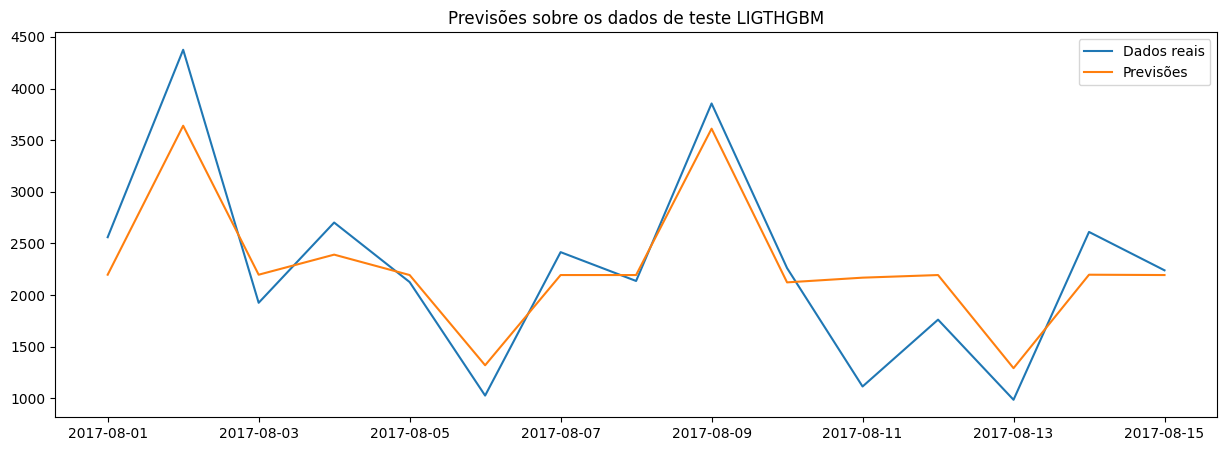

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df[(predictions_df['store_nbr'] == 1) & (predictions_df['family'] == 'PRODUCE')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste LIGTHGBM')
plt.show()

Como suspeitei o modelo precisava de um maior numero de features para uma divisão melhor dos dados entre os ramos da arvore, com essas novas features tive uma melhora muito significativa no modelo. neste ponto poderia pensar em novas features e ver até onde tenho melhoras e onde começa overfitar.

### Regressão Linear 4 - Testando com as novas features.

In [ ]:
# Função para realizar a previsão usando o modelo de regressão linear
def perform_linear_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo de regressão linear
    model = LinearRegression()

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df_lr = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'sales', 'previsao'])

# calculando regressão linear para cada combinação de store_nbr e family
for store_nbr in df_train_resid_teste['store_nbr'].unique():
    for family in df_train_resid_teste['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_train_resid_teste[(df_train_resid_teste['store_nbr'] == store_nbr) & (df_train_resid_teste['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino =  ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                         's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                          'onpromotion','dcoilwtico','dia_mes','ano','preco_oleo_media_28dias','preco_onpromotion_media_7dias',
                           'preco_onpromotion_media_28dias','dia_do_ano','semana_do_ano','Feriado','Feriado_local'
                         ]

        # Fazer a previsão usando o modelo de regressão linear para a combinação atual
        previsoes_sales_original = perform_linear_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Calcular as métricas RMSLE e RMSE
        rmsle_score, rmse_score = calculate_metrics(df_store_family_test['sales'], previsoes_sales_original)

        # Adicionar os resultados ao DataFrame de métricas
        metric_results = metric_results.append({'Store_nbr': store_nbr, 'Família': family, 'RMSLE': rmsle_score, 'RMSE': rmse_score}, ignore_index=True)

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df_lr = pd.concat([predictions_df_lr, df_store_family_test[['id', 'store_nbr', 'family', 'sales', 'previsao']]])

# Calcular a média das métricas RMSLE e RMSE
Media_rmsle = metric_results['RMSLE'].mean()
Media_mse = metric_results['RMSE'].mean()

# Imprimir a média das métricas
print("Média RMSLE:", Media_rmsle)
print("Média RMSE:", Media_mse)

# Imprimir os resultados por store_nbr e family
print("Resultados por store_nbr e family:")
print(metric_results)

# Imprimir o DataFrame de previsões
print("Previsões Finais:")
predictions_df_lr


Média RMSLE: 0.42497450873595005
Média RMSE: 142.55172744617838
Resultados por store_nbr e family:
      Store_nbr                     Família     RMSLE        RMSE
0           1.0                  AUTOMOTIVE  0.514015    2.479091
1           1.0                   BABY CARE  0.000000    0.000000
2           1.0                      BEAUTY  0.455409    2.276254
3           1.0                   BEVERAGES  0.338222  549.898865
4           1.0                       BOOKS  0.262699    0.307526
...         ...                         ...       ...         ...
1777       54.0                     POULTRY  0.207691   12.393572
1778       54.0              PREPARED FOODS  0.232402   23.676826
1779       54.0                     PRODUCE  0.225395  158.277435
1780       54.0  SCHOOL AND OFFICE SUPPLIES  0.404425    0.510702
1781       54.0                     SEAFOOD  0.759531    3.046867

[1782 rows x 4 columns]
Previsões Finais:


,id,store_nbr,family,sales,previsao
2017-08-01,2974158.0,1.0,AUTOMOTIVE,5.0,5.027900
2017-08-02,2975940.0,1.0,AUTOMOTIVE,4.0,4.882375
2017-08-03,2977722.0,1.0,AUTOMOTIVE,3.0,4.097105
2017-08-04,2979504.0,1.0,AUTOMOTIVE,8.0,4.911457
2017-08-05,2981286.0,1.0,AUTOMOTIVE,5.0,5.330360
...,...,...,...,...,...
2017-08-11,2993627.0,54.0,SEAFOOD,0.0,1.111306
2017-08-12,2995409.0,54.0,SEAFOOD,1.0,2.478923
2017-08-13,2997191.0,54.0,SEAFOOD,2.0,2.222964
2017-08-14,2998973.0,54.0,SEAFOOD,0.0,1.711041


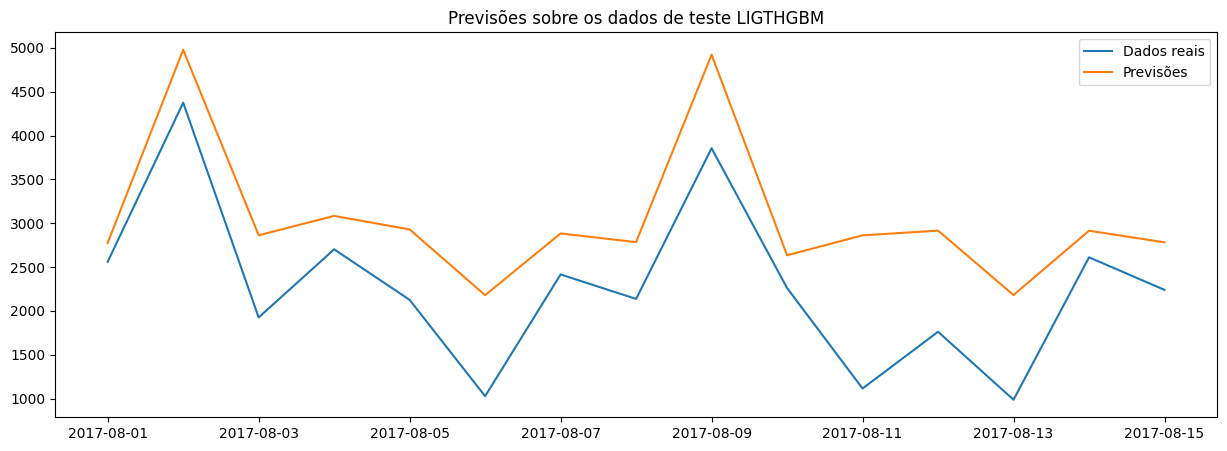

In [ ]:
# Filtrando os dados de teste para store_nbr = 1 e family = 'DAIRY'
prev = predictions_df_lr[(predictions_df_lr['store_nbr'] == 1) & (predictions_df_lr['family'] == 'PRODUCE')]

# Plotando dados previstos
plt.figure(figsize=(15,5))
plt.plot(prev.sales)
plt.plot(prev.previsao)
plt.legend(['Dados reais','Previsões'])
plt.title('Previsões sobre os dados de teste LIGTHGBM')
plt.show()

Para uma ultima comparação, quis testar o modelo de regressão com as features novas, e como ja imaginava o mesmo não desempenhou bem, pelos motivos que ja mencionei anteriormente.

#Preparando o conjunto de teste (Kaggle)

In [ ]:
test_data = pd.read_csv('/content/test.csv')

In [ ]:
oil_data = pd.read_csv('/content/oil.csv')
# Verificando o número total de linhas do DataFrame
total_linhas = len(oil_data)

# Mantendo as últimas 12 linhas
oil_data = oil_data.tail(12)

In [ ]:
# Convertendo a coluna "date" para o tipo datetime64[ns]
test_data['date'] = pd.to_datetime(test_data['date'])
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Criando um DataFrame com todas as datas únicas presentes em test_data, transaction_data e oil_data
all_dates = pd.concat([test_data['date'], oil_data['date']]).drop_duplicates().reset_index(drop=True)

# Mesclando os DataFrames test_data e transactions_data usando todas as datas únicas
df_test = pd.merge(all_dates, test_data, on=["date"], how="left")


# Combinando os demais DataFrames, preenchendo os valores ausentes em oil_data usando forward fill (ffill)
df_test = df_test.merge(oil_data, on="date", how="left").ffill()
df_test = df_test.merge(stores_data, on="store_nbr", how="left") \
                    .sort_values(["date", "store_nbr", "family"], ignore_index=True)


In [ ]:
# Realizando o rolling mean para o preço do óleo
df_test['preco_oleo_media_7dias'] = df_test['dcoilwtico'].rolling(7, min_periods=1).mean()

# Realizando o rolling max para o preço do óleo
df_test['preco_oleo_maximo_7dias'] = df_test['dcoilwtico'].rolling(7, min_periods=1).max()

# Realizando o rolling min para o preço do óleo
df_test['preco_oleo_minimo_7dias'] = df_test['dcoilwtico'].rolling(7, min_periods=1).min()


In [ ]:
df_test = df_test.reset_index()  # Reseta o índice para que "date" torne-se uma coluna novamente

# Extraindo o mês
df_test['mês'] = df_test.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.month)

# Extraindo o dia da semana (0 = segunda-feira, 1 = terça-feira, ..., 6 = domingo)
df_test['dia_semana'] = df_test.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.dayofweek)

# Extraindo o dia do mês
df_test['dia_mes'] = df_test.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.day)

# Extraindo o ano
df_test['ano'] = df_test.groupby(['family', 'store_nbr'])['date'].transform(lambda x: x.dt.year)

# Definindo novamente a coluna "date" como o índice
df_test = df_test.set_index('date')

In [ ]:
# Verificando os valores nulos no DataFrame df_train
df_train_nulos = df_test.isnull()

# Somando os valores nulos por coluna
total_nulos_por_coluna = df_train_nulos.sum()

# Criando um DataFrame com o total de nulos por coluna
df_total_nulos = pd.DataFrame(total_nulos_por_coluna, columns=['Total Nulos'])

# Criando uma coluna adicional para indicar a porcentagem de nulos em relação ao total de linhas
df_total_nulos['Porcentagem de Nulos'] = (total_nulos_por_coluna / len(df_train)) * 100

# Ordenando o DataFrame pelo total de nulos em ordem decrescente
df_total_nulos = df_total_nulos.sort_values(by='Total Nulos', ascending=False)

# Realçando visualmente os valores nulos no DataFrame
df_total_nulos_estilizado = df_total_nulos.style.highlight_null(null_color='red')

# Visualizando o DataFrame com os valores nulos destacados
df_total_nulos_estilizado

,Total Nulos,Porcentagem de Nulos
index,0,0.000000
cluster,0,0.000000
dia_mes,0,0.000000
dia_semana,0,0.000000
mês,0,0.000000
preco_oleo_minimo_7dias,0,0.000000
preco_oleo_maximo_7dias,0,0.000000
preco_oleo_media_7dias,0,0.000000
type,0,0.000000
id,0,0.000000


In [ ]:
# Criando uma instância de CalendarSeasonality para capturar a sazonalidade do dia da semana
week = CalendarSeasonality('D','W').in_sample(df_test.index)

# Adicionando o efeito do CalendarSeasonality ao DataFrame
df_test = pd.concat([df_test, week], axis=1)

In [ ]:
# Criando mais features para dar uma complexidade maior ao LGBM
# Realizando o rolling mean para o preço do óleo e de promoçoes Medias moveis.
df_test['preco_oleo_media_28dias'] = df_test['dcoilwtico'].rolling(28, min_periods=1).mean()

df_test['preco_onpromotion_media_7dias'] = df_test['onpromotion'].rolling(7, min_periods=1).mean()
df_test['preco_onpromotion_media_28dias'] = df_test['onpromotion'].rolling(28, min_periods=1).mean()


#colunas para representar o dia e a semana do ano
df_test['dia_do_ano'] = df_test.index.dayofyear
df_test['semana_do_ano'] = df_test.index.weekofyear

In [ ]:
# Criando uma coluna de Feriados Nacionais
df_test['Feriado'] = 0

#Iterarndo sobre os feriados e marcando as datas correspondentes como feriado (1)
for _, feriado in holidays_data.iterrows():
    date = feriado['date']
    if feriado['locale'] == 'National':
        df_test.loc[df_test.index == date, 'Feriado'] = 1


In [ ]:
# Criando uma coluna de Feriados Locais
df_test['Feriado_local'] = 0

# Iterando sobre os feriados e marcando as datas correspondentes como feriado local (1)
for _, feriado in holidays_data.iterrows():
    date = feriado['date']
    locale_name = feriado['locale_name']
    if feriado['locale'] == 'Local' and df_test['city'].eq(locale_name).any():
        df_test.loc[df_test.index == date, 'Feriado_local'] = 1

In [ ]:
# Dicionário para mapear os nomes atuais para os novos nomes
rename_dict = {
    's(D=1, period=W)': 's_D_1_period_W',
    's(D=2, period=W)': 's_D_2_period_W',
    's(D=3, period=W)': 's_D_3_period_W',
    's(D=4, period=W)': 's_D_4_period_W',
    's(D=5, period=W)': 's_D_5_period_W',
    's(D=6, period=W)': 's_D_6_period_W',
    's(D=7, period=W)': 's_D_7_period_W'
}

# Renomear as colunas com base no dicionário
df_test.rename(columns=rename_dict, inplace=True)

#Prevendo os valores para submissão no conjunto de teste

In [ ]:
# Função para realizar a previsão usando o LightGBM
def perform_lightgbm_regression(train_data, test_data, target_column, feature_columns):
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]
    X_test = test_data[feature_columns]

    # Inicializar o modelo LightGBM para regressão
    model = lgb.LGBMRegressor(n_estimators = 200,max_depth=3,learning_rate=0.01,boosting_type='gbdt')

    # Treinar o modelo usando os dados de treino
    model.fit(X_train, y_train)

    # Fazer as previsões no conjunto de teste
    predictions = model.predict(X_test)

    return predictions

# Função para calcular as métricas RMSLE e RMSE
def calculate_metrics(y_true, y_pred):
    rmsle_score = np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))
    rmse_score = mean_squared_error(y_true, y_pred, squared=False)
    return rmsle_score, rmse_score

# DataFrame para armazenar as métricas por família de produtos
metric_results = pd.DataFrame(columns=['Store_nbr', 'Família', 'RMSLE', 'RMSE'])

# DataFrame para armazenar as previsões por família de produtos e lojas
predictions_df = pd.DataFrame(columns=['id', 'store_nbr', 'family', 'previsao'])

# Calculando previsões usando LightGBM para cada combinação de store_nbr e family
for store_nbr in df_test['store_nbr'].unique():
    for family in df_test['family'].unique():
        df_store_family_train = df_train_resid_treino[(df_train_resid_treino['store_nbr'] == store_nbr) & (df_train_resid_treino['family'] == family)]
        df_store_family_test = df_test[(df_test['store_nbr'] == store_nbr) & (df_test['family'] == family)]

        # Colunas que serão usadas no treinamento do modelo
        colunas_treino = ['preco_oleo_media_7dias', 'preco_oleo_maximo_7dias', 'preco_oleo_minimo_7dias',
                         's_D_1_period_W','s_D_2_period_W','s_D_3_period_W','s_D_4_period_W','s_D_5_period_W','s_D_6_period_W','s_D_7_period_W',
                          'onpromotion','dcoilwtico','dia_mes','ano','preco_oleo_media_28dias','preco_onpromotion_media_7dias','preco_onpromotion_media_28dias','dia_do_ano','semana_do_ano','Feriado','Feriado_local'
                         ]

        # Fazer a previsão usando o modelo LightGBM para a combinação atual
        previsoes_sales_original = perform_lightgbm_regression(df_store_family_train, df_store_family_test, 'sales', colunas_treino)

        # Adicionar as previsões ao DataFrame de previsões
        df_store_family_test['previsao'] = previsoes_sales_original

        # Adicionar os resultados ao DataFrame de previsões finais
        predictions_df = pd.concat([predictions_df, df_store_family_test[['id', 'store_nbr', 'family','previsao']]])


# Imprimir o DataFrame de previsões
print("Previsões Finais:")
print(predictions_df)


Previsões Finais:
                 id store_nbr      family  previsao
2017-08-16  3000888         1  AUTOMOTIVE  3.863854
2017-08-17  3002670         1  AUTOMOTIVE  4.028410
2017-08-18  3004452         1  AUTOMOTIVE  4.352790
2017-08-19  3006234         1  AUTOMOTIVE  4.163683
2017-08-20  3008016         1  AUTOMOTIVE  1.537573
...             ...       ...         ...       ...
2017-08-27  3022139        54     SEAFOOD  2.357272
2017-08-28  3023921        54     SEAFOOD  2.077737
2017-08-29  3025703        54     SEAFOOD  2.220208
2017-08-30  3027485        54     SEAFOOD  2.077737
2017-08-31  3029267        54     SEAFOOD  2.077737

[28512 rows x 4 columns]


In [ ]:
#ordenando os dados por ID e removendo a data do index
predictions_df = predictions_df.sort_values(by='id')
predictions_df.reset_index(inplace= True)

In [ ]:
#removendo as colunas que não são necessarias para submissão
sub = predictions_df.drop(['index','store_nbr','family'],axis = 1)

In [ ]:
#Renomeando a coluna previsão para sales.
sub.rename(columns={'previsao': 'sales'}, inplace=True)

In [ ]:
#visualizando a submissão
sub

,id,sales
0,3000888,3.863854
1,3000889,0.000000
2,3000890,3.549699
3,3000891,2223.396480
4,3000892,0.307883
...,...,...
28507,3029395,415.764334
28508,3029396,97.114338
28509,3029397,1260.690915
28510,3029398,50.141323


In [ ]:
# Salvando o DataFrame sub em um arquivo CSV
sub.to_csv('submissao.csv', index=False)

#Conclusão

Durante a análise exploratória, **foi possível identificar uma tendência de crescimento em vendas ao longo dos anos.** Além disso, **uma correlação negativa entre as vendas e o preço do petróleo foi notada**, o que à primeira vista pode parecer surpreendente, já que a venda de petróleo é uma das principais fontes econômicas do Equador. No entanto, é importante lembrar que houve uma queda global nos preços do petróleo a partir de 2014, um evento não exclusivo ao Equador. Isso oferece uma explicação plausível para a correlação negativa encontrada.

Outra descoberta relevante foi a **correlação positiva entre o número de promoções e as vendas**, indicando que a realização de mais promoções está associada a um aumento nas vendas.

A maioria das **features adicionais foi criada com base em médias móveis e preços de dias anteriores.** Também foram incorporadas características relacionadas ao dia do ano, da semana e do mês, entre outros, com o objetivo de identificar padrões sazonais.

Para lidar com a tendência e sazonalidade das vendas, foi realizada a **remoção destes efeitos** a fim de trabalhar com uma série estacionária. No entanto, **a reconversão da previsão residual para a escala original das vendas apresentou desafios**, o que levou à decisão de não incorporar esse processo por enquanto. No entanto, esta permanece como uma opção de melhoria para o futuro.

Na etapa de modelagem, **foram testados modelos de regressão linear**. Dada a criação de diversas features, o desempenho do modelo de regressão linear foi afetado, possivelmente devido à dificuldade em capturar correlações não-lineares. **Uma abordagem envolveu a redução do número de features, resultando em uma melhoria do desempenho do modelo.**

A abordagem subsequente adotou o modelo **LGBM (Light Gradient Boosting Machine)**, uma árvore de decisão. **Devido ao grande número de features, supôs-se que esse modelo seria mais eficaz do que a regressão.** Inicialmente, os resultados não foram favoráveis, possivelmente devido à falta de features que pudessem explicar as relações de forma mais precisa. **No entanto, após a criação de novas features, incluindo informações sobre feriados e promoções, o modelo LGBM apresentou um desempenho substancialmente melhor**, com as métricas obtidas, torna-se possível realizar previsões futuras com valores que se aproximam significativamente da realidade, contribuindo para que **as equipes possam planejar suas estratégias de forma mais eficaz.**

Este desafio foi realizado como parte de uma competição interna do BeeData, (grupo de estudos do IME-USP). Na competição, obtive a colocação de **2º lugar**. Além disso, submeti o projeto à competição do Kaggle, **onde alcancei a 93ª posição com um score de 0.44148**, uma realização que me deixa satisfeito, especialmente considerando que foi minha primeira experiência em projetos de séries temporais.

#Considerações finais e melhorias futuras.

Apesar de me empenhar na remoção da tendência e da sazonalidade de vendas, a fim de trabalhar com uma série estacionária, encontrei desafios na utilização do valor residual para prever as vendas futuras. Como estava participando de uma competição, optei por deixar essa abordagem, que estava consumindo muito tempo, para uma possível melhoria no futuro.

Uma oportunidade de aprimoramento consiste em aproveitar melhor os dados disponíveis. Havia uma abundância de informações para a criação de variáveis exógenas, como o número de transações e outros dados úteis sobre feriados, entre outras opções. Essas variáveis poderiam ter enriquecido o modelo, tornando-o mais robusto. Infelizmente, devido a limitações de tempo, não pude explorar todas as possibilidades.

A tunagem de hiperparâmetros não foi aplicada após a criação das novas features para o modelo LGBM. Embora eu tenha realizado uma tentativa com um conjunto reduzido de variáveis e não tenha obtido resultados satisfatórios, seria interessante realizar uma nova tunagem abrangendo todas as features utilizadas no melhor modelo.

Ao analisar a função de autocorrelação (ACF), identifiquei que o valor de vendas era influenciado até 400 dias anteriores. Seria instrutivo testar um conjunto de dados limitado a apenas 400 dias para avaliar se o modelo reage de maneira diferente. Mesmo que essa abordagem não resultasse em mudanças significativas, poderia ser útil para reduzir os custos associados à experimentação com modificações no modelo.

Em resumo, percebo que há margem significativa para aprimorar este projeto por meio de uma exploração mais abrangente. A implementação de todas as melhorias mencionadas, juntamente com a consideração de outros modelos não explorados, pode levar a resultados mais sólidos.

- [Meu LinkedIn](https://www.linkedin.com/in/dionesgouvea/)

- [Meus Projetos](https://github.com/DionesGouvea)
